In [13]:
import matplotlib.pyplot as plt # 그래프 그리는 라이브러리
from matplotlib import colors # 그래프 색상 라이브러리
import numpy as np # 행렬 연산 라이브러리
import sys  # 파이썬 인터프리터 제어 라이브러리
sys.executable # 파이썬 인터프리터 경로

'c:\\Users\\quant.QUANT\\Desktop\\QuantWeb-FastAPI-\\.conda\\python.exe'

In [14]:
ACTION_UP = 0 
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3
ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]
ACTION_SYMBOLS = {ACTION_UP: '↑', ACTION_DOWN: '↓', ACTION_LEFT: '←', ACTION_RIGHT: '→'}


# Utils
### - Implement

In [15]:
# state에서 가능한 action을 반환, 방해물이나 벽이 있는 경우 제외
def get_available_actions(state, grid_reward):
    actions = []
    x, y = state

    # 상하좌우로 움직일 수 있는지 확인
    # 상하좌우에 벽이나 장애물이 없으면 actions에 추가
    # 벽이나 장애물이 있으면 actions에 추가하지 않음
    if x > 0 and grid_reward[x-1, y] != -100:
        actions.append(ACTION_UP)
    if x < grid_reward.shape[0] - 1 and grid_reward[x+1, y] != -100:
        actions.append(ACTION_DOWN)
    if y > 0 and grid_reward[x, y-1] != -100:
        actions.append(ACTION_LEFT)
    if y < grid_reward.shape[1] - 1 and grid_reward[x, y+1] != -100:
        actions.append(ACTION_RIGHT)

    return actions

# state에서 action을 취한 후의 다음 state와 reward를 반환
def get_transition(state, action, grid_reward):
    x, y = state
    grid_size = grid_reward.shape[0]

    # action에 따라 다음 state를 결정
    if action == ACTION_UP and x > 0 :
        next_state = (x - 1, y)
    elif action == ACTION_DOWN and x < grid_size - 1:
        next_state = (x + 1, y)
    elif action == ACTION_LEFT and y > 0:
        next_state = (x, y - 1)
    elif action == ACTION_RIGHT and y < grid_size - 1:
        next_state = (x, y + 1)
    else:
        next_state = state  # 경계를 벗어날 경우 현재 위치 유지

    # 다음 state가 장애물인지 확인
    if grid_reward[next_state[0], next_state[1]] == -100:
        next_state = state  # 장애물이 있는 경우 현재 상태를 유지
    
    reward = grid_reward[next_state[0], next_state[1]]  # 장애물이 아니면 다음 상태의 보상 반환

    return next_state, reward


# Utils
### - Given

In [16]:
# grid world를 만들어주는 함수, 매개변수로 장애물의 위치를 받음
def generate_grid_world(obstacles): 
    grid_size = 7 # 7x7 grid world
    grid_reward = np.full((grid_size, grid_size), -1) # reward for each grid, 각 grid의 reward는 -1로 초기화

    # 장애물의 위치의 보상을 -100으로 설정
    for (x, y) in obstacles:
        grid_reward[x, y] = -100

    # Define start and end positions
    start = (0, 0)
    end = (6, 6)

    # 시작 지점의 보상을 -1로 유지하면, 에이전트는 현재 상태에 머무르는 것보다 움직이는 것이 더 이득이 됩니다.
    grid_reward[end[0], end[1]] = 0 # end[0[ = 6, end[1] = 6인 grid의 reward를 0으로 설정

    return grid_reward, start, end # grid_reward, start, end를 반환

# grid world를 시각화하는 함수, policy를 받아서 policy에 따라 grid world를 시각화
# policy에서는 각 grid에서 취해야 할 action을 나타냄
def print_policy(policy):
    grid_size = policy.shape[0] # policy의 shape를 통해 grid의 크기를 알아냄
    policy_symbols = np.full((grid_size, grid_size), ' ') # policy_symbols라는 2차원 배열을 만들고, 모든 원소를 공백으로 초기화

    # 모든 x, y에 대해 policy_symbols[x, y]에 policy[x, y]에 해당하는 action symbol을 저장
    for x in range(grid_size): 
        for y in range(grid_size):
            if (x, y) == (end[0], end[1]):
                # 만약 (x, y)가 end의 위치와 같다면 policy_symbols[x, y]에 'G'를 저장
                policy_symbols[x, y] = 'G'  # Goal
            else:
                # 그렇지 않다면 policy_symbols[x, y]에 policy[x, y]에 해당하는 action symbol을 저장
                # action symbol은 ACTION_SYMBOLS에서 가져오고 없ㄷ면 공백을 저장
                policy_symbols[x, y] = ACTION_SYMBOLS.get(policy[x, y], ' ')
    # policy_symbols를 출력
    for row in policy_symbols:
        print(' '.join(row)) # row를 공백을 기준으로 join하여 출력

# visualize_map 함수는 grid world를 시각화하는 함수
def visualize_map(data, title): 
    plt.imshow(data, cmap='gray', interpolation='nearest') # data를 흑백 이미지로 출력, cmap이란 colormap을 설정, interpolation은 이미지의 보간 방법을 설정
    plt.colorbar(label='Value') # colorbar를 추가하고 label을 'Value'로 설정, 숫자가 클수록 밝은 색으로 표시
    
    # data.shape[0]은 grid의 row 수, data.shape[1]은 grid의 column 수
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            # 각 grid의 value를 텍스트로 출력, 텍스트의 위치는 (j, i)로 설정
            # j,i로 설정하는 이유는 j가 x축, i가 y축이기 때문
            # ha는 horizontal alignment, va는 vertical alignment, color는 Green
            plt.text(j, i, f"{data[i, j]:.1f}", ha="center", va="center", color="Green")

    plt.title(title) # title을 설정
    plt.xlabel('X-axis') # x축의 label을 'X-axis'로 설정
    plt.ylabel('Y-axis') # y축의 label을 'Y-axis'로 설정
    plt.show() # 그래프 출력

# visualize_policy 함수는 policy를 시각화하는 함수
def visualize_policy(policy, start, end, title, israndom):
    grid_size = policy.shape[0] # policy의 shape를 통해 grid의 크기를 알아냄
    policy_symbols = np.full((grid_size, grid_size), ' ', dtype="U10") # policy_symbols라는 2차원 배열을 만들고, 모든 원소를 공백으로 초기화
    
    # 모든 x, y에 대해 policy_symbols[x, y]에 policy[x, y]에 해당하는 action symbol을 저장
    for x in range(grid_size):
        for y in range(grid_size):
            # 시작점과 도착점을 표시
            if (x, y) == (end[0], end[1]):
                policy_symbols[x, y] = 'G'  # Goal
            elif (x, y) == (start[0], start[1]):
                policy_symbols[x, y] = 'S'  # Start
            else:
                # israndom가 True라는 뜻은 policy가 random policy라는 뜻
                if israndom:
                    # policy_symbols[x, y]에 policy[x, y]에 해당하는 action symbol을 저장
                    policy_symbols[x, y] = ACTION_SYMBOLS.get(policy[x, y], ' ')
                # israndom이 False라는 뜻은 policy가 optimal policy라는 뜻
                else:
                    # temp_policy_symbol을 0으로 초기화
                    temp_policy_symbol = 0
                    # policy[x, y]를 문자열로 변환하고, 각 문자열을 int로 변환하여 actions에 저장
                    # 문자열로 변환하는 이유는 policy[x, y]가 2자리 수 이상일 수 있기 때문
                    # ex) policy[x, y] = 12, 12는 1, 2로 이루어진 2자리 수
                    # policy[x, y] = 12일 때, actions = [1, 2]
                    actions = [int(value) for value in str(policy[x, y])]
                    # actions의 각 action에 대해 policy_symbols[x, y]에 action symbol을 저장
                    for i, value in enumerate(actions):
                        # 첫 번째 action이라면 temp_policy_symbol에 action symbol을 저장
                        if i == 0:
                            # ACTION_SYMBOLS에서 value에 해당하는 action symbol을 가져오고, 없다면 공백을 추가
                            temp_policy_symbol = ACTION_SYMBOLS.get(value, ' ')
                        # 그렇지 않다면 temp_policy_symbol에 action symbol을 추가
                        else:
                            # ACTION_SYMBOLS에서 value에 해당하는 action symbol을 가져오고, 없다면 공백을 추가
                            temp_policy_symbol += ACTION_SYMBOLS.get(value, ' ')
                    # policy_symbols[x, y]에 temp_policy_symbol을 저장
                    policy_symbols[x, y] = temp_policy_symbol
    
    # fig란 figure로, 그림이 그려지는 전체 창을 의미
    # ax는 axes로, 하나의 그림 안에 여러 개의 plot을 그릴 수 있게 해줌
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_xlim(0, grid_size) # x축의 범위를 0부터 grid_size까지로 설정
    ax.set_ylim(0, grid_size) # y축의 범위를 0부터 grid_size까지로 설정
    ax.set_xticks(np.arange(0, grid_size+1, 1)) # x축의 눈금을 0부터 grid_size까지 1씩 증가하며 설정
    ax.set_yticks(np.arange(0, grid_size+1, 1)) # y축의 눈금을 0부터 grid_size까지 1씩 증가하며 설정
    ax.set_yticklabels(np.arange(grid_size, -1, -1)) # y축의 눈금 레이블을 grid_size부터 0까지 1씩 감소하며 설정
    ax.grid(True) # grid를 표시

    # 모든 x, y에 대해 policy_symbols[x, y]에 해당하는 action symbol을 출력
    for x in range(grid_size):
        for y in range(grid_size):
            # israndom이 True라면 fontsize를 20으로 설정
            if israndom:
                # policy_symbols[x, y]는 action symbol을 의미, ha는 horizontal alignment, va는 vertical alignment
                # fontsize는 글자 크기, fontsize를 20으로 설정
                # y가 row, x가 column이기 때문에 y축은 grid_size - x - 0.5로 설정
                ax.text(y + 0.5, grid_size - x - 0.5, policy_symbols[x, y],
                        ha='center', va='center', fontsize=20)
            else:
                # israndom이 False라면 fontsize를 10으로 설정
                # 여기서 y축은 grid_size - x - 1로 설정하는 이유는 y축이 반대로 출력되기 때문
                # y축을 반대로 하는 이유는 grid world를 그릴 때, (0, 0)이 왼쪽 아래에 위치하기 때문
                ax.text(y + 0.5, grid_size - x - 0.5, policy_symbols[x, y],
                        ha='center', va='center', fontsize=10)
            # 장애물이 있는 grid는 검은색으로 표시
            if grid[x, y] == -100:
                # 장애물이 있는 grid의 위치를 rect로 생성하고, facecolor를 검은색으로 설정
                # 1, 1은 rect의 너비와 높이를 의미
                rect = plt.Rectangle((y, grid_size - x - 1), 1, 1, facecolor='black')
                ax.add_patch(rect) # rect를 그림
            elif (x, y) == (end[0], end[1]): 
                # 도착점을 표시하기 위해 rect를 생성하고, facecolor를 빨간색으로 설정
                # alpha는 투명도를 나타내며, 0.3으로 설정
                rect = plt.Rectangle((y, grid_size - x - 1), 1, 1, facecolor='green', alpha=0.3) 
                ax.add_patch(rect) # rect를 그림
            elif (x, y) == (start[0], start[1]):
                # 시작점을 표시하기 위해 rect를 생성하고, facecolor를 노란색으로 설정
                # alpha는 투명도를 나타내며, 0.3으로 설정
                rect = plt.Rectangle((y, grid_size - x - 1), 1, 1, facecolor='blue', alpha=0.3)
                ax.add_patch(rect) # rect를 그림

    plt.title(title) # title을 설정 
    plt.show() # 그래프 출력

# Policy initialization
### - Implement

In [17]:
# policy를 생성하는 함수, grid_reward는 grid world의 reward, israndom은 random policy를 생성할지 여부
# isall이 True라면 모든 action을 선택하고, False라면 최적의 action을 선택
# israndom이 True라면 random policy를 생성하고, False라면 optimal policy를 생성
# 여기서 policy는 각 grid에서 취해야 할 action을 나타냄
def policy_generator(grid_reward, israndom, isall=True):
    grid_size = grid_reward.shape[0] # grid의 크기를 구함
    policy = np.zeros((grid_size, grid_size), dtype=int) # policy를 0으로 초기화

    # 모든 x, y에 대해 policy[x, y]를 생성
    for x in range(grid_size):
        for y in range(grid_size):
            # (x, y)가 end의 위치와 같다면 policy[x, y]를 0으로 설정
            # end는 generate_grid_world 함수에서 설정
            if (x, y) == (end[0], end[1]):
                policy[x, y] = 55 # 목표지점
            # (x, y)가 장애물의 위치와 같다면 policy[x, y]를 -1로 설정
            elif grid_reward[x, y] == -100:
                policy[x, y] = 33 # 못 간다걸 의미 
            else:
                # israndom이 True라면 random policy를 생성
                if israndom:
                    # 가능한 action을 모두 선택
                    if isall:
                        # 가능한 action을 모두 선택하고, 그 중 하나를 무작위로 선택
                        policy[x, y] = np.random.choice(ACTIONS)
                    # 가능한 action 중 하나를 무작위로 선택
                    else:
                        # 가능한 action 중 하나를 무작위로 선택
                        policy[x, y] = np.random.choice(get_available_actions((x, y), grid_reward))
                    # israndom이 False라면 optimal policy를 생성
                else:
                    if isall:
                        # 가능한 action을 모두 선택하고, 그 중 하나를 최대값을 가지는 action으로 선택
                        best_action = ACTIONS[0] # best_action을 첫 번째 action으로 설정
                        best_reward = get_transition((x, y), best_action, grid_reward)[1] # best_reward를 첫 번째 action의 reward로 설정
                        for action in ACTIONS: # 가능한 action에 대해 반복
                            _, reward = get_transition((x, y), action, grid_reward) # 다음 state와 reward를 가져옴
                            if reward > best_reward: # reward가 best_reward보다 크다면
                                best_action = action # best_action을 action으로 설정
                                best_reward = reward # best_reward를 reward로 설정
                        policy[x, y] = best_action
                    # 가능한 action 중 하나를 선택
                    else:
                        # 가능한 action 중 하나를 선택
                        available_actions = get_available_actions((x, y), grid_reward)
                        # 가능한 action 중에서 가장 큰 reward를 가지는 action을 선택
                        best_action = available_actions[0] # best_action을 첫 번째 action으로 설정
                        best_reward = get_transition((x, y), best_action, grid_reward)[1] # best_reward를 첫 번째 action의 reward로 설정
                        for action in available_actions: # 가능한 action에 대해 반복
                            _, reward = get_transition((x, y), action, grid_reward) # 다음 state와 reward를 가져옴
                            if reward > best_reward: # reward가 best_reward보다 크다면
                                best_action = action # best_action을 action으로 설정
                                best_reward = reward # best_reward를 reward로 설정
                        policy[x, y] = best_action
    return policy # policy를 반환

# Policy evaluation
### - Implement

In [18]:
def policy_evaluation(grid_reward, policy, discount_factor=0.9, theta=1e-1, israndom=True):
    grid_size = grid_reward.shape[0] # grid의 크기를 구함
    V = np.zeros((grid_size, grid_size)) # V를 0으로 초기화
    print(V)
    visualize_map(V, "Initial Value Function") # 초기 Value Function을 시각화

    delta = float('inf') # delta를 무한대로 설정

    end = (6, 6)  # 목표 지점
    
    while delta >= theta: # delta가 theta보다 크거나 같다면 반복
        for x in range(grid_size): # 모든 x에 대해 반복 
            for y in range(grid_size): # 모든 y에 대해 반복
                if (x, y) == (end[0], end[1]): # (x, y)가 end의 위치와 같다면
                    continue # 다음 반복으로 넘어감
                if grid_reward[x, y] == -100: # grid_reward[x, y]가 -100이라면
                    continue

                v = 0 # v를 0으로 초기화
                if israndom: # israndom이 True라면
                    for action in ACTIONS: # 모든 action에 대해 반복
                        next_state, reward = get_transition((x, y), action, grid_reward) # 다음 state와 reward를 가져옴
                        v += 0.25 * (reward + discount_factor * V[next_state]) # v에 reward와 discount_factor * V[next_state]를 더함
                        print(f"V[{x}, {y}] = 0.25 * ({reward} + {discount_factor} * {V[next_state]}) = {v}, action = {action}")
                    V[x, y] = v # V[x, y]에 v를 저장 
                    print (f"V[{x}, {y}] = {v}")
                else:
                    action = policy[x, y] # policy[x, y]에 해당하는 action을 가져옴
                    if action is None: # action이 None이라면
                        continue # 다음 반복으로 넘어감
                    next_state, reward = get_transition((x, y), action, grid_reward) # 다음 state와 reward를 가져옴
                    if 0 <= next_state[0] < grid_size and 0 <= next_state[1] < grid_size: # next_state가 grid_size보다 작거나 같다면
                        v = reward + discount_factor * V[next_state] # v에 reward와 discount_factor * V[next_state]를 더함
                        V[x, y] = v # V[x, y]에 v를 저장

        delta = max(delta, np.abs(v - V[x, y])) # delta와 v - V[x, y]의 절대값 중 큰 값을 delta에 저장
        yield V
        
    return V

# Policy improvement
### -Implement

In [19]:
def policy_improvement(grid_reward, value_function, discount_factor=0.9, end=(6, 6)):
    grid_size = grid_reward.shape[0]
    new_policy = np.full((grid_size, grid_size), None)
    
    for x in range(grid_size):
        for y in range(grid_size):
            if grid_reward[x, y] == -100 or (x, y) == end: # 장애물이거나 목표 지점이라면
                continue # 다음 반복으로 넘어감
            
            action_values = {} # action_values를 빈 딕셔너리로 초기화
            for action in ACTIONS: # 모든 action에 대해 반복
                next_state, reward = get_transition((x, y), action, grid_reward) # 다음 state와 reward를 가져옴
                if 0 <= next_state[0] < grid_size and 0 <= next_state[1] < grid_size: # next_state가 grid_size보다 작다면
                    action_values[action] = reward + discount_factor * value_function[next_state[0], next_state[1]] # 벨만 방정식을 이용하여 action_values[action]을 계산
                    print(f"action = {action} V[{x}, {y}] = {reward} + {discount_factor} * {value_function[next_state[0], next_state[1]]} = {action_values[action]}")
            if action_values:  # action_values가 비어있지 않다면
                best_action = max(action_values, key=action_values.get) # action_values에서 가장 큰 값을 가지는 action을 best_action으로 설정
                print(f"best_action = {best_action}") # best_action 출력
                new_policy[x, y] = best_action # new_policy[x, y]에 best_action을 저장
    
    return new_policy


# Policy iteration
### - Implement

In [20]:
def policy_iteration(max_iterations=100, discount_factor=0.9, theta=1e-1):
    # Initialize a random policy
    policy = policy_generator(grid, israndom=True) # random policy 생성
    stable = False # stable을 False로 설정
    iteration = 0 # iteration을 0으로 설정
    
    for ing_V in policy_evaluation(grid, policy, discount_factor=discount_factor, theta=theta, israndom=True): # policy_evaluation을 호출
        V = ing_V  # generator의 값을 순차적으로 가져옴 
        visualize_map(V, f"Value Function (iteration {iteration})") # Value Function을 시각화
        iteration += 1 # iteration을 1 증가
    
        # policy_improvement 적용
        new_policy = policy_improvement(grid, V, discount_factor=discount_factor)
        
        # 정책이 안정적인지 확인
        if np.array_equal(policy, new_policy):
            stable = True # stable을 True로 설정
            
        policy = new_policy # policy를 new_policy로 설정

        # if stable or iteration > max_iterations: # stable이 True이거나 iteration이 max_iterations보다 크다면
        #     break
        if iteration > max_iterations:
            break
    V_final = V  # 최종 Value Function 저장

    return policy, V_final # policy와 V_final을 반환


# Value iteration
### - Implement

In [21]:
def value_iteration(grid_reward, discount_factor=0.9, theta=1e-1):
    grid_size = grid_reward.shape[0] # grid의 크기를 구함
    V = np.zeros((grid_size, grid_size)) # V를 0으로 초기화
    policy = np.zeros((grid_size, grid_size), dtype=int) # policy를 0으로 초기화
    iteration = 0 # iteration을 0으로 초기화

    visualize_map(V, "Initial Value Function") # 초기 Value Function을 시각화

    while True: # delta가 theta보다 작다면 반복 종료
        delta = 0 # delta를 0으로 초기화
        # Temporary copy of V to hold updates
        V_new = V.copy() # V_new에 V를 복사
        for x in range(grid_size): # 모든 x에 대해 반복
            for y in range(grid_size): # 모든 y에 대해 반복
                if (x, y) == (end[0], end[1]): # (x, y)가 end의 위치와 같다면
                    continue # 다음 반복으로 넘어감
                if grid_reward[x, y] == -100: # grid_reward[x, y]가 -100이라면
                    continue

                next_rewards = [] # next_rewards를 빈 리스트로 초기화
                for action in ACTIONS: # 모든 action에 대해 반복
                    next_state, reward = get_transition((x, y), action, grid_reward) # 다음 state와 reward를 가져옴
                    next_rewards.append(reward + discount_factor * V[next_state[0], next_state[1]]) # next_rewards에 reward + discount_factor * V[next_state[0], next_state[1]을 추가
                V_new[x, y] = max(next_rewards) # V_new[x, y]에 next_rewards의 최대값을 저장
                delta = max(delta, np.abs(V_new[x, y] - V[x, y])) # delta에 V_new[x, y] - V[x, y]의 절대값과 delta 중 큰 값을 저장
                policy[x, y] = ACTIONS[np.argmax(next_rewards)] # policy[x, y]에 next_rewards의 최대값의 인덱스에 해당하는 action을 저장
        V = V_new # V에 V_new를 저장
        iteration += 1 # iteration을 1 증가
        print(f"iteration {iteration}") # iteration 출력
        visualize_map(V, f"Value Function (iteration {iteration})") # Value Function을 시각화
        if delta < theta: # delta가 theta보다 작다면
            break # 반복 종료
        
    return V, policy


# Initialization
### - Given

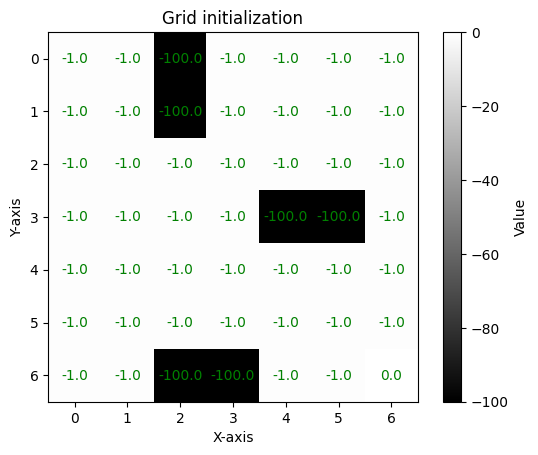

In [22]:
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3
ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT] # 가능한 action
ACTION_SYMBOLS = {ACTION_UP: '↑', ACTION_DOWN: '↓', ACTION_LEFT: '←', ACTION_RIGHT: '→'} # action symbol

border = f"\n{'='*60}\n" # border를 생성
obstacles = [(0, 2), (1, 2), (3, 4), (3, 5), (6, 2), (6, 3)] # 장애물의 위치
grid, start, end = generate_grid_world(obstacles) # grid world 생성
print(border) # border 출력
visualize_map(grid, "Grid initialization") # grid world를 시각화
print(border) # border 출력

# Show policy iteration results
### - Given

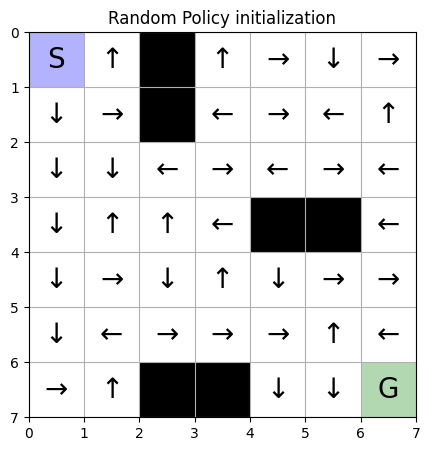

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


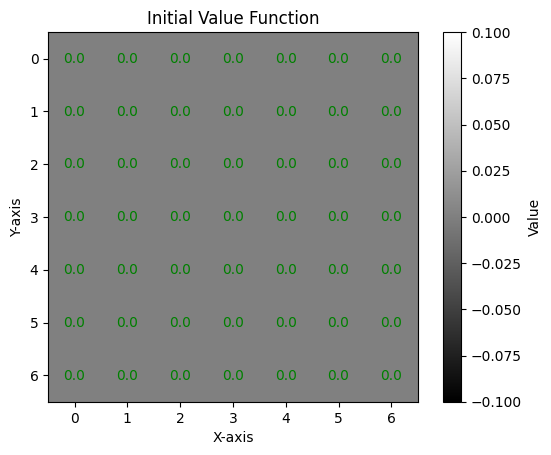

V[0, 0] = 0.25 * (-1 + 0.9 * 0.0) = -0.25, action = 0
V[0, 0] = 0.25 * (-1 + 0.9 * 0.0) = -0.5, action = 1
V[0, 0] = 0.25 * (-1 + 0.9 * 0.0) = -0.75, action = 2
V[0, 0] = 0.25 * (-1 + 0.9 * 0.0) = -1.0, action = 3
V[0, 0] = -1.0
V[0, 1] = 0.25 * (-1 + 0.9 * 0.0) = -0.25, action = 0
V[0, 1] = 0.25 * (-1 + 0.9 * 0.0) = -0.5, action = 1
V[0, 1] = 0.25 * (-1 + 0.9 * -1.0) = -0.975, action = 2
V[0, 1] = 0.25 * (-1 + 0.9 * 0.0) = -1.225, action = 3
V[0, 1] = -1.225
V[0, 3] = 0.25 * (-1 + 0.9 * 0.0) = -0.25, action = 0
V[0, 3] = 0.25 * (-1 + 0.9 * 0.0) = -0.5, action = 1
V[0, 3] = 0.25 * (-1 + 0.9 * 0.0) = -0.75, action = 2
V[0, 3] = 0.25 * (-1 + 0.9 * 0.0) = -1.0, action = 3
V[0, 3] = -1.0
V[0, 4] = 0.25 * (-1 + 0.9 * 0.0) = -0.25, action = 0
V[0, 4] = 0.25 * (-1 + 0.9 * 0.0) = -0.5, action = 1
V[0, 4] = 0.25 * (-1 + 0.9 * -1.0) = -0.975, action = 2
V[0, 4] = 0.25 * (-1 + 0.9 * 0.0) = -1.225, action = 3
V[0, 4] = -1.225
V[0, 5] = 0.25 * (-1 + 0.9 * 0.0) = -0.25, action = 0
V[0, 5] = 0.25 * (

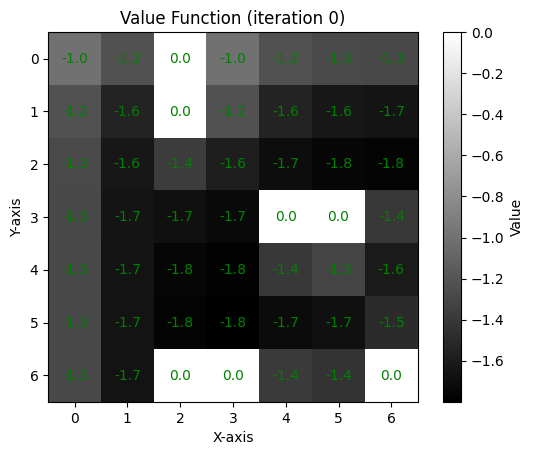

action = 0 V[0, 0] = -1 + 0.9 * -1.0 = -1.9
action = 1 V[0, 0] = -1 + 0.9 * -1.225 = -2.1025
action = 2 V[0, 0] = -1 + 0.9 * -1.0 = -1.9
action = 3 V[0, 0] = -1 + 0.9 * -1.225 = -2.1025
best_action = 0
action = 0 V[0, 1] = -1 + 0.9 * -1.225 = -2.1025
action = 1 V[0, 1] = -1 + 0.9 * -1.55125 = -2.396125
action = 2 V[0, 1] = -1 + 0.9 * -1.0 = -1.9
action = 3 V[0, 1] = -1 + 0.9 * -1.225 = -2.1025
best_action = 2
action = 0 V[0, 3] = -1 + 0.9 * -1.0 = -1.9
action = 1 V[0, 3] = -1 + 0.9 * -1.225 = -2.1025
action = 2 V[0, 3] = -1 + 0.9 * -1.0 = -1.9
action = 3 V[0, 3] = -1 + 0.9 * -1.225 = -2.1025
best_action = 0
action = 0 V[0, 4] = -1 + 0.9 * -1.225 = -2.1025
action = 1 V[0, 4] = -1 + 0.9 * -1.55125 = -2.396125
action = 2 V[0, 4] = -1 + 0.9 * -1.0 = -1.9
action = 3 V[0, 4] = -1 + 0.9 * -1.275625 = -2.1480625
best_action = 2
action = 0 V[0, 5] = -1 + 0.9 * -1.275625 = -2.1480625
action = 1 V[0, 5] = -1 + 0.9 * -1.636046875 = -2.4724421875
action = 2 V[0, 5] = -1 + 0.9 * -1.225 = -2.1025
act

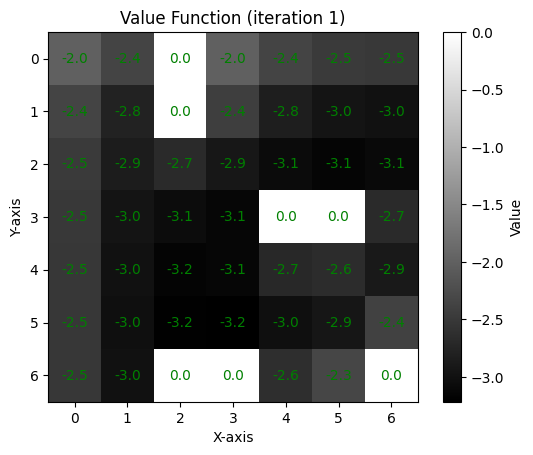

action = 0 V[0, 0] = -1 + 0.9 * -2.0012499999999998 = -2.801125
action = 1 V[0, 0] = -1 + 0.9 * -2.361953125 = -3.1257578125
action = 2 V[0, 0] = -1 + 0.9 * -2.0012499999999998 = -2.801125
action = 3 V[0, 0] = -1 + 0.9 * -2.3505625 = -3.11550625
best_action = 0
action = 0 V[0, 1] = -1 + 0.9 * -2.3505625 = -3.11550625
action = 1 V[0, 1] = -1 + 0.9 * -2.7774578125 = -3.49971203125
action = 2 V[0, 1] = -1 + 0.9 * -2.0012499999999998 = -2.801125
action = 3 V[0, 1] = -1 + 0.9 * -2.3505625 = -3.11550625
best_action = 2
action = 0 V[0, 3] = -1 + 0.9 * -2.0012499999999998 = -2.801125
action = 1 V[0, 3] = -1 + 0.9 * -2.431213721435547 = -3.1880923492919924
action = 2 V[0, 3] = -1 + 0.9 * -2.0012499999999998 = -2.801125
action = 3 V[0, 3] = -1 + 0.9 * -2.3619531250000003 = -3.1257578125000003
best_action = 0
action = 0 V[0, 4] = -1 + 0.9 * -2.3619531250000003 = -3.1257578125000003
action = 1 V[0, 4] = -1 + 0.9 * -2.830267268395996 = -3.5472405415563966
action = 2 V[0, 4] = -1 + 0.9 * -2.00124999

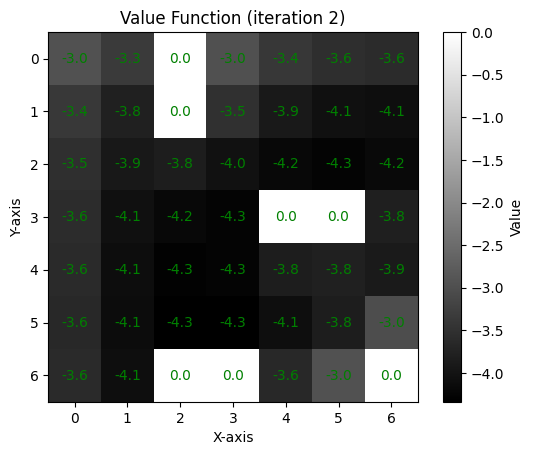

action = 0 V[0, 0] = -1 + 0.9 * -2.9608785156249997 = -3.6647906640624996
action = 1 V[0, 0] = -1 + 0.9 * -3.37969755859375 = -4.041727802734375
action = 2 V[0, 0] = -1 + 0.9 * -2.9608785156249997 = -3.6647906640624996
action = 3 V[0, 0] = -1 + 0.9 * -3.3488787988281246 = -4.0139909189453125
best_action = 0
action = 0 V[0, 1] = -1 + 0.9 * -3.3488787988281246 = -4.0139909189453125
action = 1 V[0, 1] = -1 + 0.9 * -3.7830023923339846 = -4.404702153100587
action = 2 V[0, 1] = -1 + 0.9 * -2.9608785156249997 = -3.6647906640624996
action = 3 V[0, 1] = -1 + 0.9 * -3.3488787988281246 = -4.0139909189453125
best_action = 2
action = 0 V[0, 3] = -1 + 0.9 * -2.9790250404479983 = -3.6811225364031985
action = 1 V[0, 3] = -1 + 0.9 * -3.5123325063694764 = -4.161099255732529
action = 2 V[0, 3] = -1 + 0.9 * -2.9790250404479983 = -3.6811225364031985
action = 3 V[0, 3] = -1 + 0.9 * -3.3956626542555237 = -4.056096388829971
best_action = 0
action = 0 V[0, 4] = -1 + 0.9 * -3.3956626542555237 = -4.0560963888299

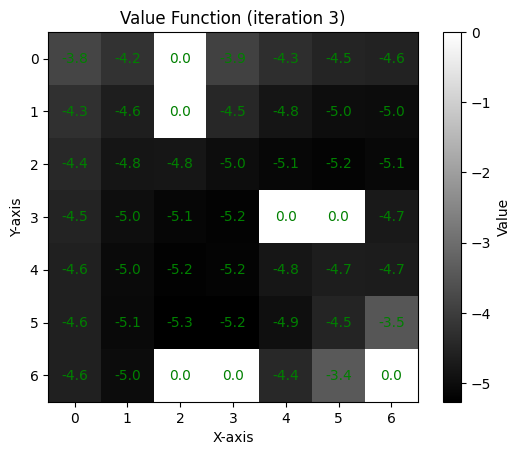

action = 0 V[0, 0] = -1 + 0.9 * -3.8463250124511714 = -4.461692511206055
action = 1 V[0, 0] = -1 + 0.9 * -4.270476122668457 = -4.843428510401612
action = 2 V[0, 0] = -1 + 0.9 * -3.8463250124511714 = -4.461692511206055
action = 3 V[0, 0] = -1 + 0.9 * -4.223594125549317 = -4.801234712994385
best_action = 0
action = 0 V[0, 1] = -1 + 0.9 * -4.223594125549317 = -4.801234712994385
action = 1 V[0, 1] = -1 + 0.9 * -4.6432945509422305 = -5.178965095848008
action = 2 V[0, 1] = -1 + 0.9 * -3.8463250124511714 = -4.461692511206055
action = 3 V[0, 1] = -1 + 0.9 * -4.223594125549317 = -4.801234712994385
best_action = 2
action = 0 V[0, 3] = -1 + 0.9 * -3.894860179342224 = -4.505374161408001
action = 1 V[0, 3] = -1 + 0.9 * -4.457960392950655 = -5.0121643536555895
action = 2 V[0, 3] = -1 + 0.9 * -3.894860179342224 = -4.505374161408001
action = 3 V[0, 3] = -1 + 0.9 * -4.319750596302718 = -4.8877755366724465
best_action = 0
action = 0 V[0, 4] = -1 + 0.9 * -4.319750596302718 = -4.8877755366724465
action = 

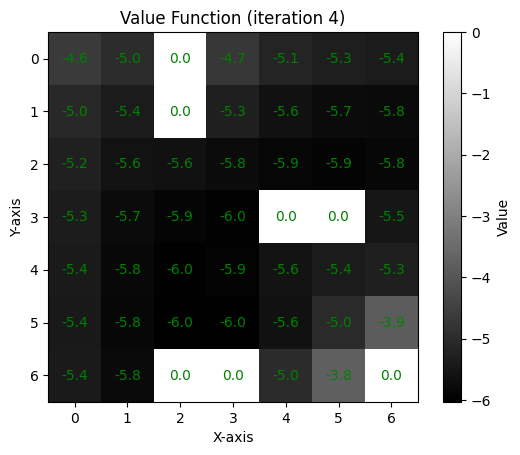

action = 0 V[0, 0] = -1 + 0.9 * -4.642012061452027 = -5.1778108553068245
action = 1 V[0, 0] = -1 + 0.9 * -5.049793119316262 = -5.544813807384636
action = 2 V[0, 0] = -1 + 0.9 * -4.642012061452027 = -5.1778108553068245
action = 3 V[0, 0] = -1 + 0.9 * -4.989811344285901 = -5.490830209857311
best_action = 0
action = 0 V[0, 1] = -1 + 0.9 * -4.989811344285901 = -5.490830209857311
action = 1 V[0, 1] = -1 + 0.9 * -5.387733744659223 = -5.848960370193301
action = 2 V[0, 1] = -1 + 0.9 * -4.642012061452027 = -5.1778108553068245
action = 3 V[0, 1] = -1 + 0.9 * -4.989811344285901 = -5.490830209857311
best_action = 2
action = 0 V[0, 3] = -1 + 0.9 * -4.72767205328601 = -5.25490484795741
action = 1 V[0, 3] = -1 + 0.9 * -5.275883725530807 = -5.748295352977727
action = 2 V[0, 3] = -1 + 0.9 * -4.72767205328601 = -5.25490484795741
action = 3 V[0, 3] = -1 + 0.9 * -5.1345830956128555 = -5.6211247860515705
best_action = 0
action = 0 V[0, 4] = -1 + 0.9 * -5.1345830956128555 = -5.6211247860515705
action = 1 V[

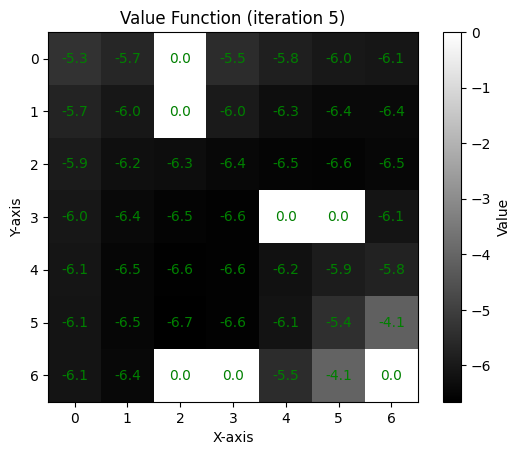

action = 0 V[0, 0] = -1 + 0.9 * -5.347816431963899 = -5.813034788767509
action = 1 V[0, 0] = -1 + 0.9 * -5.730714364175037 = -6.157642927757533
action = 2 V[0, 0] = -1 + 0.9 * -5.347816431963899 = -5.813034788767509
action = 3 V[0, 0] = -1 + 0.9 * -5.660913894668858 = -6.094822505201972
best_action = 0
action = 0 V[0, 1] = -1 + 0.9 * -5.660913894668858 = -6.094822505201972
action = 1 V[0, 1] = -1 + 0.9 * -6.03316454477686 = -6.429848090299174
action = 2 V[0, 1] = -1 + 0.9 * -5.347816431963899 = -5.813034788767509
action = 3 V[0, 1] = -1 + 0.9 * -5.660913894668858 = -6.094822505201972
best_action = 2
action = 0 V[0, 3] = -1 + 0.9 * -5.469807458736029 = -5.922826712862427
action = 1 V[0, 3] = -1 + 0.9 * -5.978554807094969 = -6.380699326385471
action = 2 V[0, 3] = -1 + 0.9 * -5.469807458736029 = -5.922826712862427
action = 3 V[0, 3] = -1 + 0.9 * -5.844141918094498 = -6.259727726285048
best_action = 0
action = 0 V[0, 4] = -1 + 0.9 * -5.844141918094498 = -6.259727726285048
action = 1 V[0, 4

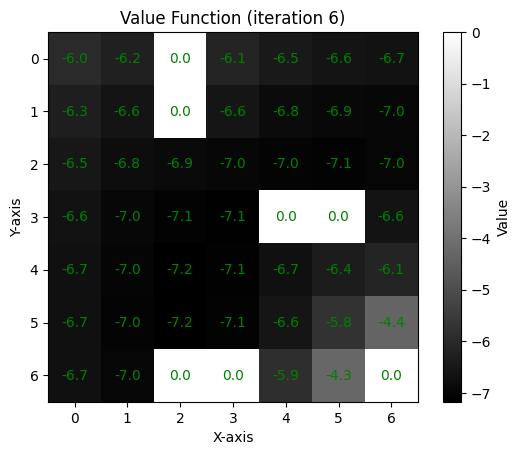

action = 0 V[0, 0] = -1 + 0.9 * -5.969633752623631 = -6.372670377361268
action = 1 V[0, 0] = -1 + 0.9 * -6.324167075155919 = -6.691750367640327
action = 2 V[0, 0] = -1 + 0.9 * -5.969633752623631 = -6.372670377361268
action = 3 V[0, 0] = -1 + 0.9 * -6.248040869516096 = -6.6232367825644864
best_action = 0
action = 0 V[0, 1] = -1 + 0.9 * -6.248040869516096 = -6.6232367825644864
action = 1 V[0, 1] = -1 + 0.9 * -6.592019554505688 = -6.932817599055119
action = 2 V[0, 1] = -1 + 0.9 * -5.969633752623631 = -6.372670377361268
action = 3 V[0, 1] = -1 + 0.9 * -6.248040869516096 = -6.6232367825644864
best_action = 2
action = 0 V[0, 3] = -1 + 0.9 * -6.121520119598843 = -6.509368107638959
action = 1 V[0, 3] = -1 + 0.9 * -6.579845596814922 = -6.9218610371334295
action = 2 V[0, 3] = -1 + 0.9 * -6.121520119598843 = -6.509368107638959
action = 3 V[0, 3] = -1 + 0.9 * -6.45694871606435 = -6.811253844457915
best_action = 0
action = 0 V[0, 4] = -1 + 0.9 * -6.45694871606435 = -6.811253844457915
action = 1 V[0

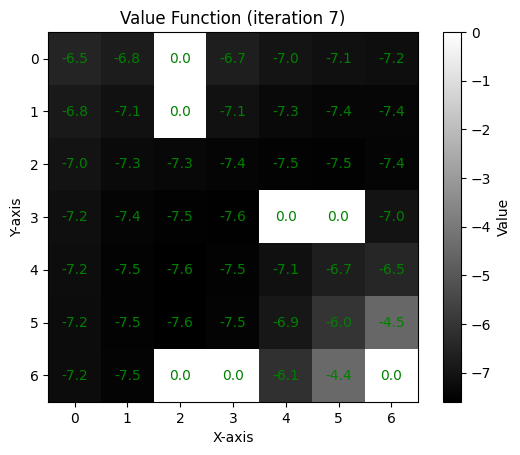

action = 0 V[0, 0] = -1 + 0.9 * -6.515081976231837 = -6.863573778608654
action = 1 V[0, 0] = -1 + 0.9 * -6.839770212437647 = -7.155793191193882
action = 2 V[0, 0] = -1 + 0.9 * -6.515081976231837 = -6.863573778608654
action = 3 V[0, 0] = -1 + 0.9 * -6.760716235698187 = -7.084644612128368
best_action = 0
action = 0 V[0, 1] = -1 + 0.9 * -6.760716235698187 = -7.084644612128368
action = 1 V[0, 1] = -1 + 0.9 * -7.075113568346205 = -7.367602211511584
action = 2 V[0, 1] = -1 + 0.9 * -6.515081976231837 = -6.863573778608654
action = 3 V[0, 1] = -1 + 0.9 * -6.760716235698187 = -7.084644612128368
best_action = 2
action = 0 V[0, 3] = -1 + 0.9 * -6.687962774217316 = -7.0191664967955845
action = 1 V[0, 3] = -1 + 0.9 * -7.093089721748828 = -7.383780749573945
action = 2 V[0, 3] = -1 + 0.9 * -6.687962774217316 = -7.0191664967955845
action = 3 V[0, 3] = -1 + 0.9 * -6.9833837776340175 = -7.285045399870616
best_action = 0
action = 0 V[0, 4] = -1 + 0.9 * -6.9833837776340175 = -7.285045399870616
action = 1 V

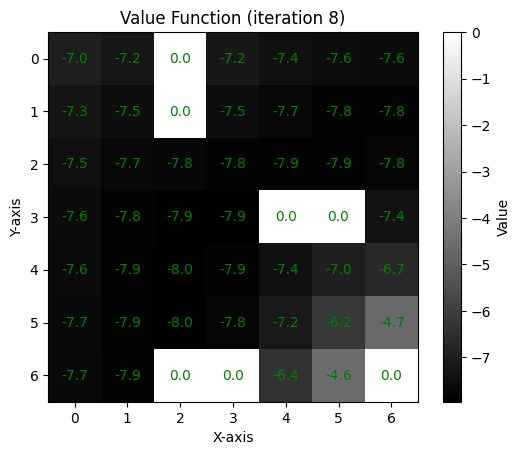

action = 0 V[0, 0] = -1 + 0.9 * -6.99189634013489 = -7.292706706121401
action = 1 V[0, 0] = -1 + 0.9 * -7.286473227679656 = -7.557825904911691
action = 2 V[0, 0] = -1 + 0.9 * -6.99189634013489 = -7.292706706121401
action = 3 V[0, 0] = -1 + 0.9 * -7.2073995354724305 = -7.4866595819251875
best_action = 0
action = 0 V[0, 1] = -1 + 0.9 * -7.2073995354724305 = -7.4866595819251875
action = 1 V[0, 1] = -1 + 0.9 * -7.492021303053666 = -7.742819172748299
action = 2 V[0, 1] = -1 + 0.9 * -6.99189634013489 = -7.292706706121401
action = 3 V[0, 1] = -1 + 0.9 * -7.2073995354724305 = -7.4866595819251875
best_action = 2
action = 0 V[0, 3] = -1 + 0.9 * -7.176789785758932 = -7.4591108071830385
action = 1 V[0, 3] = -1 + 0.9 * -7.530294803962748 = -7.777265323566474
action = 2 V[0, 3] = -1 + 0.9 * -7.176789785758932 = -7.4591108071830385
action = 3 V[0, 3] = -1 + 0.9 * -7.433947615739667 = -7.6905528541657
best_action = 0
action = 0 V[0, 4] = -1 + 0.9 * -7.433947615739667 = -7.6905528541657
action = 1 V[0,

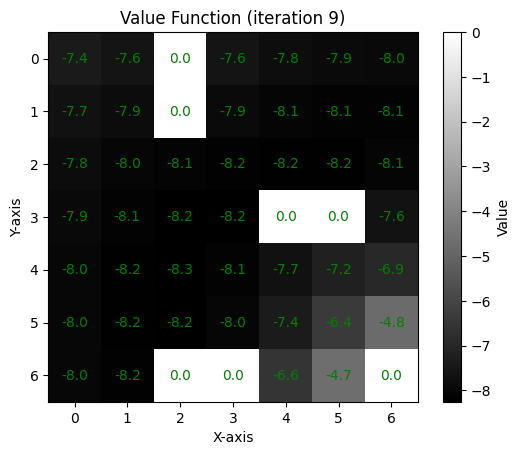

action = 0 V[0, 0] = -1 + 0.9 * -7.40747472476992 = -7.666727252292929
action = 1 V[0, 0] = -1 + 0.9 * -7.67254756845848 = -7.905292811612632
action = 2 V[0, 0] = -1 + 0.9 * -7.40747472476992 = -7.666727252292929
action = 3 V[0, 0] = -1 + 0.9 * -7.595716397222901 = -7.836144757500612
best_action = 0
action = 0 V[0, 1] = -1 + 0.9 * -7.595716397222901 = -7.836144757500612
action = 1 V[0, 1] = -1 + 0.9 * -7.851249210623756 = -8.06612428956138
action = 2 V[0, 1] = -1 + 0.9 * -7.40747472476992 = -7.666727252292929
action = 3 V[0, 1] = -1 + 0.9 * -7.595716397222901 = -7.836144757500612
best_action = 2
action = 0 V[0, 3] = -1 + 0.9 * -7.596509948024563 = -7.836858953222107
action = 1 V[0, 3] = -1 + 0.9 * -7.902049508239729 = -8.111844557415758
action = 2 V[0, 3] = -1 + 0.9 * -7.596509948024563 = -7.836858953222107
action = 3 V[0, 3] = -1 + 0.9 * -7.818482635227863 = -8.036634371705077
best_action = 0
action = 0 V[0, 4] = -1 + 0.9 * -7.818482635227863 = -8.036634371705077
action = 1 V[0, 4] = 

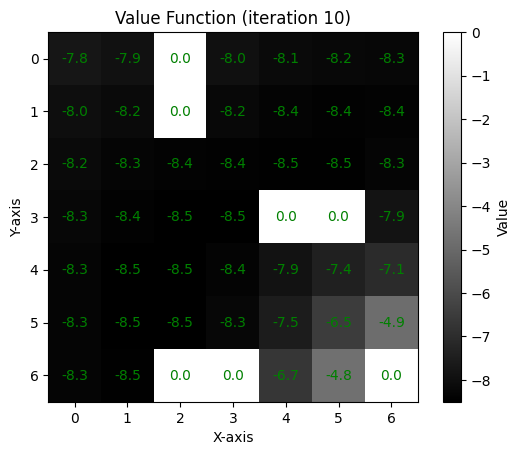

action = 0 V[0, 0] = -1 + 0.9 * -7.768723018424776 = -7.991850716582299
action = 1 V[0, 0] = -1 + 0.9 * -8.00553682021669 = -8.204983138195022
action = 2 V[0, 0] = -1 + 0.9 * -7.768723018424776 = -7.991850716582299
action = 3 V[0, 0] = -1 + 0.9 * -7.932566130286226 = -8.139309517257605
best_action = 0
action = 0 V[0, 1] = -1 + 0.9 * -7.932566130286226 = -8.139309517257605
action = 1 V[0, 1] = -1 + 0.9 * -8.160311890729274 = -8.344280701656347
action = 2 V[0, 1] = -1 + 0.9 * -7.768723018424776 = -7.991850716582299
action = 3 V[0, 1] = -1 + 0.9 * -7.932566130286226 = -8.139309517257605
best_action = 2
action = 0 V[0, 3] = -1 + 0.9 * -7.955549208891262 = -8.159994288002135
action = 1 V[0, 3] = -1 + 0.9 * -8.217623229601084 = -8.395860906640976
action = 2 V[0, 3] = -1 + 0.9 * -7.955549208891262 = -8.159994288002135
action = 3 V[0, 3] = -1 + 0.9 * -8.145900327496042 = -8.331310294746437
best_action = 0
action = 0 V[0, 4] = -1 + 0.9 * -8.145900327496042 = -8.331310294746437
action = 1 V[0, 4

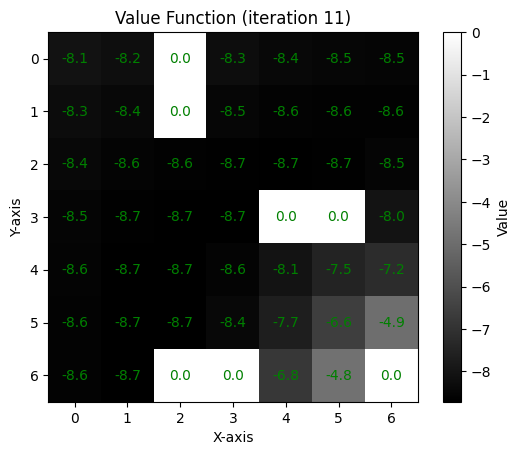

action = 0 V[0, 0] = -1 + 0.9 * -8.081998522154306 = -8.273798669938875
action = 1 V[0, 0] = -1 + 0.9 * -8.292222106153394 = -8.462999895538054
action = 2 V[0, 0] = -1 + 0.9 * -8.081998522154306 = -8.273798669938875
action = 3 V[0, 0] = -1 + 0.9 * -8.224174601527608 = -8.401757141374848
best_action = 0
action = 0 V[0, 1] = -1 + 0.9 * -8.224174601527608 = -8.401757141374848
action = 1 V[0, 1] = -1 + 0.9 * -8.425827378198228 = -8.583244640378407
action = 2 V[0, 1] = -1 + 0.9 * -8.081998522154306 = -8.273798669938875
action = 3 V[0, 1] = -1 + 0.9 * -8.224174601527608 = -8.401757141374848
best_action = 2
action = 0 V[0, 3] = -1 + 0.9 * -8.261789944347921 = -8.43561094991313
action = 1 V[0, 3] = -1 + 0.9 * -8.48509701893789 = -8.6365873170441
action = 2 V[0, 3] = -1 + 0.9 * -8.261789944347921 = -8.43561094991313
action = 3 V[0, 3] = -1 + 0.9 * -8.424127747542261 = -8.581714972788035
best_action = 0
action = 0 V[0, 4] = -1 + 0.9 * -8.424127747542261 = -8.581714972788035
action = 1 V[0, 4] = 

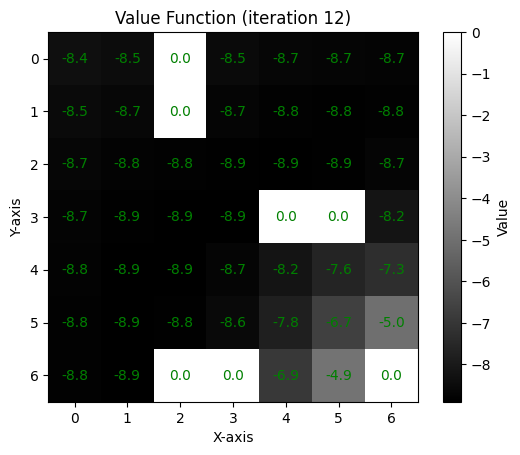

action = 0 V[0, 0] = -1 + 0.9 * -8.353088594197665 = -8.5177797347779
action = 1 V[0, 0] = -1 + 0.9 * -8.538638459976806 = -8.684774613979126
action = 2 V[0, 0] = -1 + 0.9 * -8.353088594197665 = -8.5177797347779
action = 3 V[0, 0] = -1 + 0.9 * -8.4761346644765 = -8.62852119802885
best_action = 0
action = 0 V[0, 1] = -1 + 0.9 * -8.4761346644765 = -8.62852119802885
action = 1 V[0, 1] = -1 + 0.9 * -8.653612066410258 = -8.788250859769231
action = 2 V[0, 1] = -1 + 0.9 * -8.353088594197665 = -8.5177797347779
action = 3 V[0, 1] = -1 + 0.9 * -8.4761346644765 = -8.62852119802885
best_action = 2
action = 0 V[0, 3] = -1 + 0.9 * -8.522381047414598 = -8.670142942673138
action = 1 V[0, 3] = -1 + 0.9 * -8.711489679514107 = -8.840340711562696
action = 2 V[0, 3] = -1 + 0.9 * -8.522381047414598 = -8.670142942673138
action = 3 V[0, 3] = -1 + 0.9 * -8.660142238263623 = -8.79412801443726
best_action = 0
action = 0 V[0, 4] = -1 + 0.9 * -8.660142238263623 = -8.79412801443726
action = 1 V[0, 4] = -1 + 0.9 * -

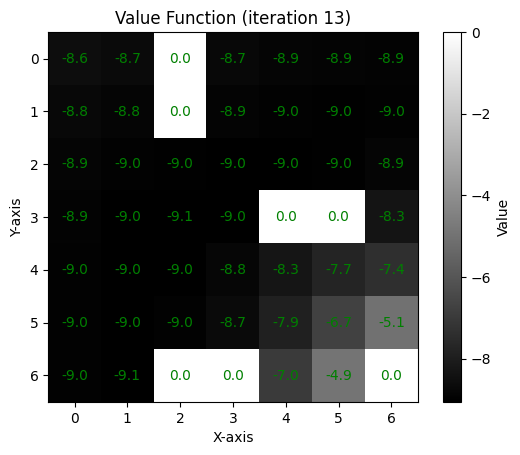

action = 0 V[0, 0] = -1 + 0.9 * -8.587213820390943 = -8.72849243835185
action = 1 V[0, 0] = -1 + 0.9 * -8.750122184806237 = -8.875109966325613
action = 2 V[0, 0] = -1 + 0.9 * -8.587213820390943 = -8.72849243835185
action = 3 V[0, 0] = -1 + 0.9 * -8.693446423544696 = -8.824101781190226
best_action = 0
action = 0 V[0, 1] = -1 + 0.9 * -8.693446423544696 = -8.824101781190226
action = 1 V[0, 1] = -1 + 0.9 * -8.848767276233204 = -8.963890548609884
action = 2 V[0, 1] = -1 + 0.9 * -8.587213820390943 = -8.72849243835185
action = 3 V[0, 1] = -1 + 0.9 * -8.693446423544696 = -8.824101781190226
best_action = 2
action = 0 V[0, 3] = -1 + 0.9 * -8.743688652836559 = -8.869319787552904
action = 1 V[0, 3] = -1 + 0.9 * -8.902874607035569 = -9.012587146332013
action = 2 V[0, 3] = -1 + 0.9 * -8.743688652836559 = -8.869319787552904
action = 3 V[0, 3] = -1 + 0.9 * -8.860040316808934 = -8.97403628512804
best_action = 0
action = 0 V[0, 4] = -1 + 0.9 * -8.860040316808934 = -8.97403628512804
action = 1 V[0, 4] = 

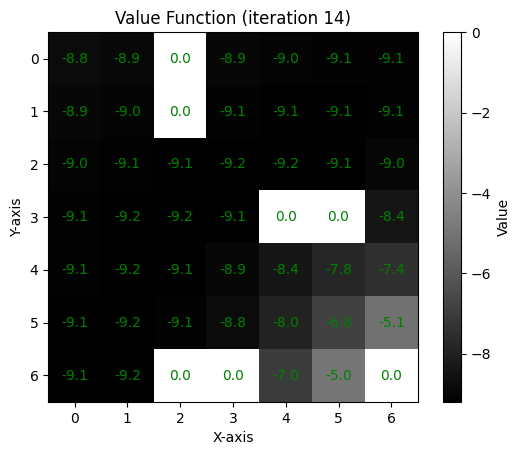

action = 0 V[0, 0] = -1 + 0.9 * -8.789049156054885 = -8.910144240449396
action = 1 V[0, 0] = -1 + 0.9 * -8.93137028484479 = -9.038233256360312
action = 2 V[0, 0] = -1 + 0.9 * -8.789049156054885 = -8.910144240449396
action = 3 V[0, 0] = -1 + 0.9 * -8.880559587859935 = -8.99250362907394
best_action = 0
action = 0 V[0, 1] = -1 + 0.9 * -8.880559587859935 = -8.99250362907394
action = 1 V[0, 1] = -1 + 0.9 * -9.015756938557088 = -9.11418124470138
action = 2 V[0, 1] = -1 + 0.9 * -8.789049156054885 = -8.910144240449396
action = 3 V[0, 1] = -1 + 0.9 * -8.880559587859935 = -8.99250362907394
best_action = 2
action = 0 V[0, 3] = -1 + 0.9 * -8.931315751641465 = -9.03818417647732
action = 1 V[0, 3] = -1 + 0.9 * -9.064488026797585 = -9.158039224117827
action = 2 V[0, 3] = -1 + 0.9 * -8.931315751641465 = -9.03818417647732
action = 3 V[0, 3] = -1 + 0.9 * -9.029118567491311 = -9.12620671074218
best_action = 0
action = 0 V[0, 4] = -1 + 0.9 * -9.029118567491311 = -9.12620671074218
action = 1 V[0, 4] = -1 +

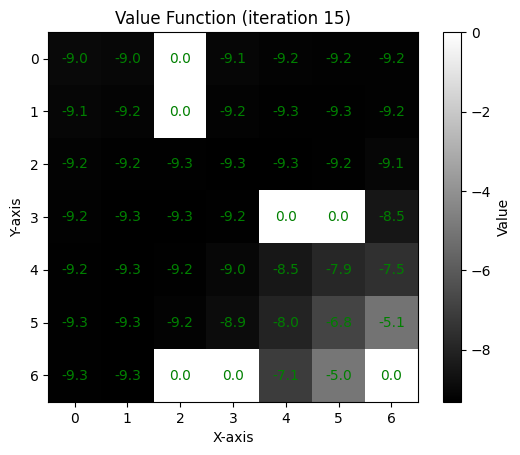

action = 0 V[0, 0] = -1 + 0.9 * -8.962756341583262 = -9.066480707424937
action = 1 V[0, 0] = -1 + 0.9 * -9.086502085127218 = -9.177851876614497
action = 2 V[0, 0] = -1 + 0.9 * -8.962756341583262 = -9.066480707424937
action = 3 V[0, 0] = -1 + 0.9 * -9.04141730256855 = -9.137275572311696
best_action = 0
action = 0 V[0, 1] = -1 + 0.9 * -9.04141730256855 = -9.137275572311696
action = 1 V[0, 1] = -1 + 0.9 * -9.158477654295224 = -9.242629888865702
action = 2 V[0, 1] = -1 + 0.9 * -8.962756341583262 = -9.066480707424937
action = 3 V[0, 1] = -1 + 0.9 * -9.04141730256855 = -9.137275572311696
best_action = 2
action = 0 V[0, 3] = -1 + 0.9 * -9.09015357195366 = -9.181138214758295
action = 1 V[0, 3] = -1 + 0.9 * -9.20082906492414 = -9.280746158431725
action = 2 V[0, 3] = -1 + 0.9 * -9.09015357195366 = -9.181138214758295
action = 3 V[0, 3] = -1 + 0.9 * -9.171956899689818 = -9.254761209720836
best_action = 0
action = 0 V[0, 4] = -1 + 0.9 * -9.171956899689818 = -9.254761209720836
action = 1 V[0, 4] = -

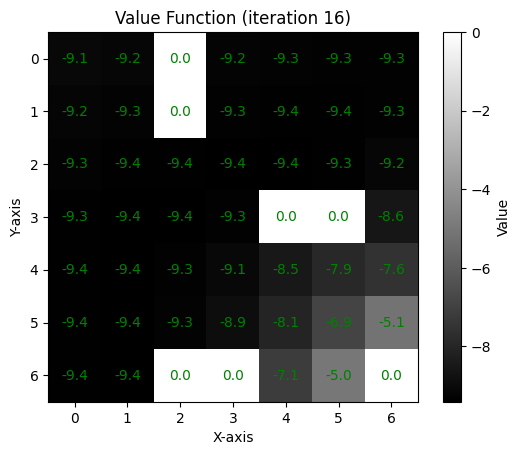

action = 0 V[0, 0] = -1 + 0.9 * -9.112022215944016 = -9.200819994349615
action = 1 V[0, 0] = -1 + 0.9 * -9.219118847461807 = -9.297206962715627
action = 2 V[0, 0] = -1 + 0.9 * -9.112022215944016 = -9.200819994349615
action = 3 V[0, 0] = -1 + 0.9 * -9.179500256959678 = -9.26155023126371
best_action = 0
action = 0 V[0, 1] = -1 + 0.9 * -9.179500256959678 = -9.26155023126371
action = 1 V[0, 1] = -1 + 0.9 * -9.28032229008988 = -9.352290061080891
action = 2 V[0, 1] = -1 + 0.9 * -9.112022215944016 = -9.200819994349615
action = 3 V[0, 1] = -1 + 0.9 * -9.179500256959678 = -9.26155023126371
best_action = 2
action = 0 V[0, 3] = -1 + 0.9 * -9.224445949417287 = -9.302001354475559
action = 1 V[0, 3] = -1 + 0.9 * -9.315751593328164 = -9.384176433995348
action = 2 V[0, 3] = -1 + 0.9 * -9.224445949417287 = -9.302001354475559
action = 3 V[0, 3] = -1 + 0.9 * -9.29249954957372 = -9.363249594616347
best_action = 0
action = 0 V[0, 4] = -1 + 0.9 * -9.29249954957372 = -9.363249594616347
action = 1 V[0, 4] = -

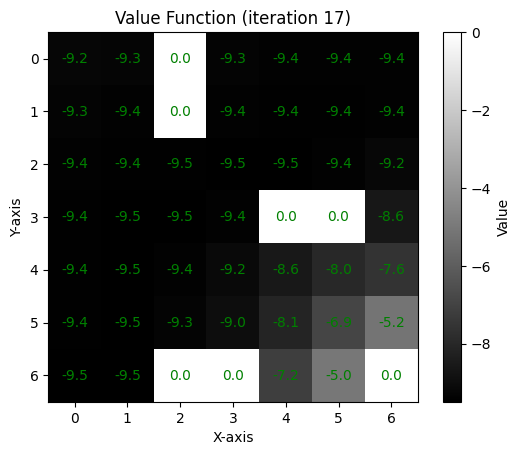

action = 0 V[0, 0] = -1 + 0.9 * -9.240099295669642 = -9.316089366102679
action = 1 V[0, 0] = -1 + 0.9 * -9.332359803184083 = -9.399123822865675
action = 2 V[0, 0] = -1 + 0.9 * -9.240099295669642 = -9.316089366102679
action = 3 V[0, 0] = -1 + 0.9 * -9.297869972427748 = -9.368082975184974
best_action = 0
action = 0 V[0, 1] = -1 + 0.9 * -9.297869972427748 = -9.368082975184974
action = 1 V[0, 1] = -1 + 0.9 * -9.384237851000895 = -9.445814065900805
action = 2 V[0, 1] = -1 + 0.9 * -9.240099295669642 = -9.316089366102679
action = 3 V[0, 1] = -1 + 0.9 * -9.297869972427748 = -9.368082975184974
best_action = 2
action = 0 V[0, 3] = -1 + 0.9 * -9.337857184390703 = -9.404071465951633
action = 1 V[0, 3] = -1 + 0.9 * -9.41254768808065 = -9.471292919272585
action = 2 V[0, 3] = -1 + 0.9 * -9.337857184390703 = -9.404071465951633
action = 3 V[0, 3] = -1 + 0.9 * -9.394131431226425 = -9.454718288103782
best_action = 0
action = 0 V[0, 4] = -1 + 0.9 * -9.394131431226425 = -9.454718288103782
action = 1 V[0, 4

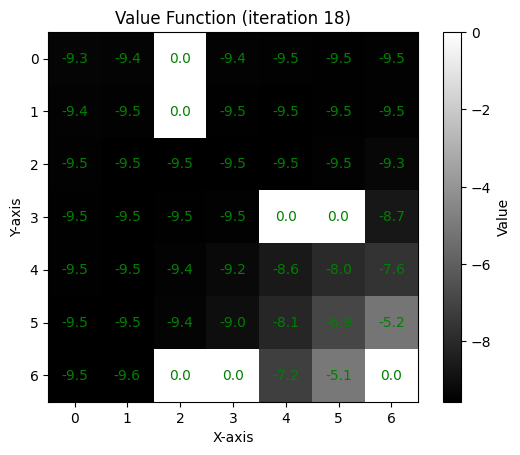

action = 0 V[0, 0] = -1 + 0.9 * -9.349846382564003 = -9.414861744307602
action = 1 V[0, 0] = -1 + 0.9 * -9.428954062410309 = -9.486058656169279
action = 2 V[0, 0] = -1 + 0.9 * -9.349846382564003 = -9.414861744307602
action = 3 V[0, 0] = -1 + 0.9 * -9.39921044014459 = -9.459289396130131
best_action = 0
action = 0 V[0, 1] = -1 + 0.9 * -9.39921044014459 = -9.459289396130131
action = 1 V[0, 1] = -1 + 0.9 * -9.472778072474815 = -9.525500265227334
action = 2 V[0, 1] = -1 + 0.9 * -9.349846382564003 = -9.414861744307602
action = 3 V[0, 1] = -1 + 0.9 * -9.39921044014459 = -9.459289396130131
best_action = 2
action = 0 V[0, 3] = -1 + 0.9 * -9.433538534819908 = -9.490184681337917
action = 1 V[0, 3] = -1 + 0.9 * -9.494022686278313 = -9.544620417650483
action = 2 V[0, 3] = -1 + 0.9 * -9.433538534819908 = -9.490184681337917
action = 3 V[0, 3] = -1 + 0.9 * -9.47974859150175 = -9.531773732351574
best_action = 0
action = 0 V[0, 4] = -1 + 0.9 * -9.47974859150175 = -9.531773732351574
action = 1 V[0, 4] = 

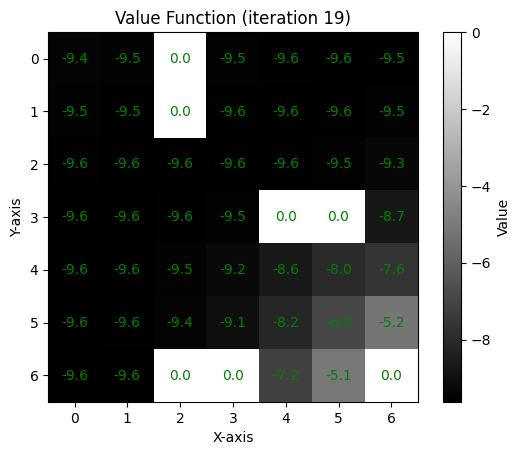

action = 0 V[0, 0] = -1 + 0.9 * -9.443767885228654 = -9.49939109670579
action = 1 V[0, 0] = -1 + 0.9 * -9.511268252516137 = -9.560141427264524
action = 2 V[0, 0] = -1 + 0.9 * -9.443767885228654 = -9.49939109670579
action = 3 V[0, 0] = -1 + 0.9 * -9.485867538548348 = -9.537280784693513
best_action = 0
action = 0 V[0, 1] = -1 + 0.9 * -9.485867538548348 = -9.537280784693513
action = 1 V[0, 1] = -1 + 0.9 * -9.548151029161993 = -9.593335926245794
action = 2 V[0, 1] = -1 + 0.9 * -9.443767885228654 = -9.49939109670579
action = 3 V[0, 1] = -1 + 0.9 * -9.485867538548348 = -9.537280784693513
best_action = 2
action = 0 V[0, 3] = -1 + 0.9 * -9.514190878169472 = -9.562771790352526
action = 1 V[0, 3] = -1 + 0.9 * -9.562562041040513 = -9.606305836936462
action = 2 V[0, 3] = -1 + 0.9 * -9.514190878169472 = -9.562771790352526
action = 3 V[0, 3] = -1 + 0.9 * -9.55182220398283 = -9.596639983584547
best_action = 0
action = 0 V[0, 4] = -1 + 0.9 * -9.55182220398283 = -9.596639983584547
action = 1 V[0, 4] = 

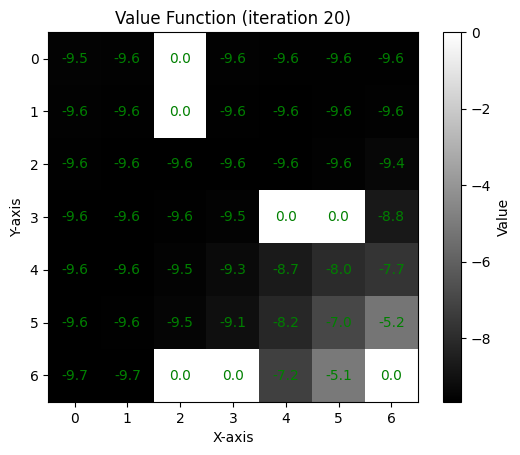

action = 0 V[0, 0] = -1 + 0.9 * -9.524051101342403 = -9.571645991208163
action = 1 V[0, 0] = -1 + 0.9 * -9.581349901654338 = -9.623214911488905
action = 2 V[0, 0] = -1 + 0.9 * -9.524051101342403 = -9.571645991208163
action = 3 V[0, 0] = -1 + 0.9 * -9.559885871710247 = -9.603897284539222
best_action = 0
action = 0 V[0, 1] = -1 + 0.9 * -9.559885871710247 = -9.603897284539222
action = 1 V[0, 1] = -1 + 0.9 * -9.612262014474915 = -9.651035813027423
action = 2 V[0, 1] = -1 + 0.9 * -9.524051101342403 = -9.571645991208163
action = 3 V[0, 1] = -1 + 0.9 * -9.559885871710247 = -9.603897284539222
best_action = 2
action = 0 V[0, 3] = -1 + 0.9 * -9.582122350306514 = -9.623910115275864
action = 1 V[0, 3] = -1 + 0.9 * -9.620190366501895 = -9.658171329851706
action = 2 V[0, 3] = -1 + 0.9 * -9.582122350306514 = -9.623910115275864
action = 3 V[0, 3] = -1 + 0.9 * -9.612455974873887 = -9.651210377386498
best_action = 0
action = 0 V[0, 4] = -1 + 0.9 * -9.612455974873887 = -9.651210377386498
action = 1 V[0, 

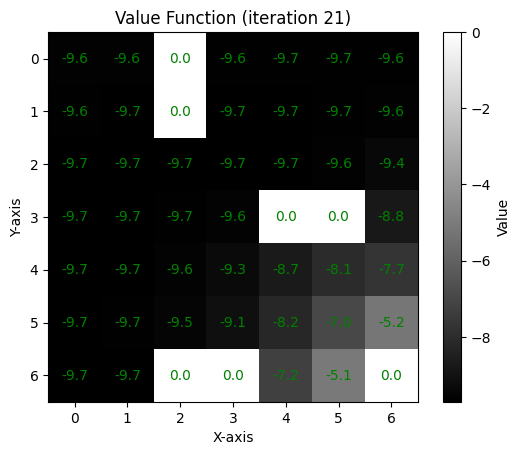

action = 0 V[0, 0] = -1 + 0.9 * -9.592601044611113 = -9.633340940150003
action = 1 V[0, 0] = -1 + 0.9 * -9.64096667172053 = -9.676870004548478
action = 2 V[0, 0] = -1 + 0.9 * -9.592601044611113 = -9.633340940150003
action = 3 V[0, 0] = -1 + 0.9 * -9.623042830563968 = -9.660738547507572
best_action = 0
action = 0 V[0, 1] = -1 + 0.9 * -9.623042830563968 = -9.660738547507572
action = 1 V[0, 1] = -1 + 0.9 * -9.666751950496145 = -9.700076755446531
action = 2 V[0, 1] = -1 + 0.9 * -9.592601044611113 = -9.633340940150003
action = 3 V[0, 1] = -1 + 0.9 * -9.623042830563968 = -9.660738547507572
best_action = 2
action = 0 V[0, 3] = -1 + 0.9 * -9.639300484447483 = -9.675370436002735
action = 1 V[0, 3] = -1 + 0.9 * -9.66862320305314 = -9.701760882747827
action = 2 V[0, 3] = -1 + 0.9 * -9.639300484447483 = -9.675370436002735
action = 3 V[0, 3] = -1 + 0.9 * -9.663437120182474 = -9.697093408164227
best_action = 0
action = 0 V[0, 4] = -1 + 0.9 * -9.663437120182474 = -9.697093408164227
action = 1 V[0, 4]

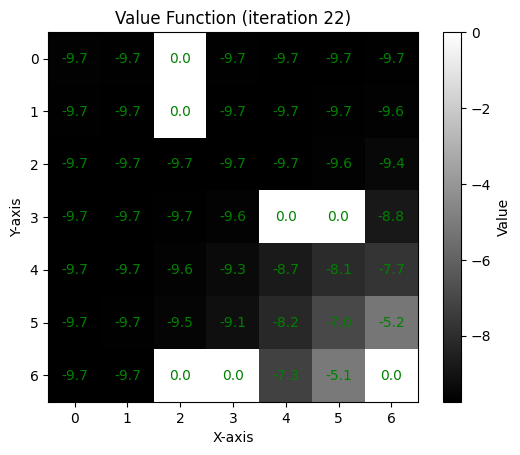

action = 0 V[0, 0] = -1 + 0.9 * -9.651072608089015 = -9.685965347280113
action = 1 V[0, 0] = -1 + 0.9 * -9.691641607623126 = -9.722477446860813
action = 2 V[0, 0] = -1 + 0.9 * -9.651072608089015 = -9.685965347280113
action = 3 V[0, 0] = -1 + 0.9 * -9.676879799435447 = -9.709191819491902
best_action = 0
action = 0 V[0, 1] = -1 + 0.9 * -9.676879799435447 = -9.709191819491902
action = 1 V[0, 1] = -1 + 0.9 * -9.713031609997156 = -9.74172844899744
action = 2 V[0, 1] = -1 + 0.9 * -9.651072608089015 = -9.685965347280113
action = 3 V[0, 1] = -1 + 0.9 * -9.676879799435447 = -9.709191819491902
best_action = 2
action = 0 V[0, 3] = -1 + 0.9 * -9.687398790729382 = -9.718658911656444
action = 1 V[0, 3] = -1 + 0.9 * -9.709312115424497 = -9.738380903882048
action = 2 V[0, 3] = -1 + 0.9 * -9.687398790729382 = -9.718658911656444
action = 3 V[0, 3] = -1 + 0.9 * -9.706281256140834 = -9.735653130526751
best_action = 0
action = 0 V[0, 4] = -1 + 0.9 * -9.706281256140834 = -9.735653130526751
action = 1 V[0, 4

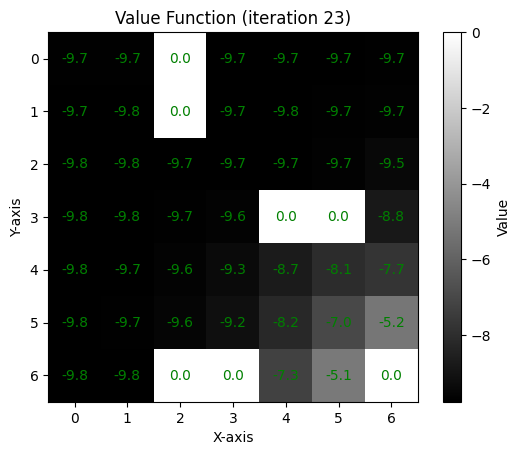

action = 0 V[0, 0] = -1 + 0.9 * -9.700899990228235 = -9.730809991205412
action = 1 V[0, 0] = -1 + 0.9 * -9.73468461741279 = -9.761216155671512
action = 2 V[0, 0] = -1 + 0.9 * -9.700899990228235 = -9.730809991205412
action = 3 V[0, 0] = -1 + 0.9 * -9.722730519796663 = -9.750457467816997
best_action = 0
action = 0 V[0, 1] = -1 + 0.9 * -9.722730519796663 = -9.750457467816997
action = 1 V[0, 1] = -1 + 0.9 * -9.752311953788782 = -9.777080758409904
action = 2 V[0, 1] = -1 + 0.9 * -9.700899990228235 = -9.730809991205412
action = 3 V[0, 1] = -1 + 0.9 * -9.722730519796663 = -9.750457467816997
best_action = 2
action = 0 V[0, 3] = -1 + 0.9 * -9.727837964430423 = -9.75505416798738
action = 1 V[0, 3] = -1 + 0.9 * -9.74348377160657 = -9.769135394445913
action = 2 V[0, 3] = -1 + 0.9 * -9.727837964430423 = -9.75505416798738
action = 3 V[0, 3] = -1 + 0.9 * -9.742271652902913 = -9.768044487612622
best_action = 0
action = 0 V[0, 4] = -1 + 0.9 * -9.742271652902913 = -9.768044487612622
action = 1 V[0, 4] =

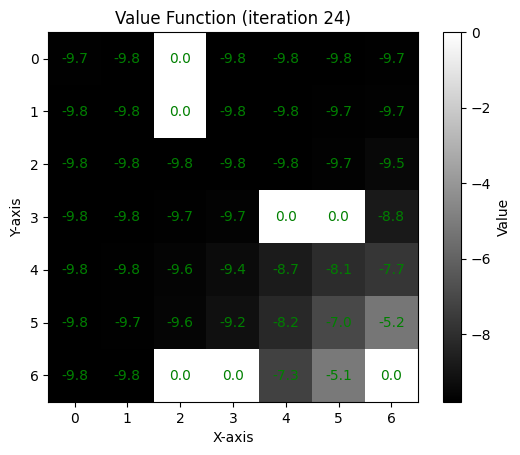

action = 0 V[0, 0] = -1 + 0.9 * -9.743323401474832 = -9.76899106132735
action = 1 V[0, 0] = -1 + 0.9 * -9.771220432292395 = -9.794098389063157
action = 2 V[0, 0] = -1 + 0.9 * -9.743323401474832 = -9.76899106132735
action = 3 V[0, 0] = -1 + 0.9 * -9.761746688842813 = -9.785572019958531
best_action = 0
action = 0 V[0, 1] = -1 + 0.9 * -9.761746688842813 = -9.785572019958531
action = 1 V[0, 1] = -1 + 0.9 * -9.78563090022687 = -9.807067810204183
action = 2 V[0, 1] = -1 + 0.9 * -9.743323401474832 = -9.76899106132735
action = 3 V[0, 1] = -1 + 0.9 * -9.761746688842813 = -9.785572019958531
best_action = 2
action = 0 V[0, 3] = -1 + 0.9 * -9.761822054508324 = -9.78563984905749
action = 1 V[0, 3] = -1 + 0.9 * -9.772173650832938 = -9.794956285749645
action = 2 V[0, 3] = -1 + 0.9 * -9.761822054508324 = -9.78563984905749
action = 3 V[0, 3] = -1 + 0.9 * -9.77249335618058 = -9.79524402056252
best_action = 0
action = 0 V[0, 4] = -1 + 0.9 * -9.77249335618058 = -9.79524402056252
action = 1 V[0, 4] = -1 + 

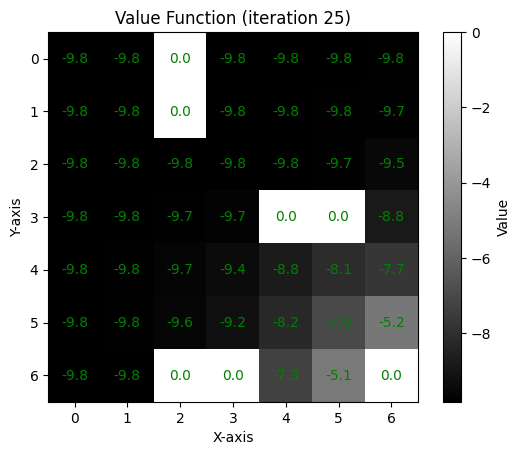

action = 0 V[0, 0] = -1 + 0.9 * -9.779413132919096 = -9.801471819627187
action = 1 V[0, 0] = -1 + 0.9 * -9.802213317111274 = -9.821991985400148
action = 2 V[0, 0] = -1 + 0.9 * -9.779413132919096 = -9.801471819627187
action = 3 V[0, 0] = -1 + 0.9 * -9.794920917437107 = -9.815428825693397
best_action = 0
action = 0 V[0, 1] = -1 + 0.9 * -9.794920917437107 = -9.815428825693397
action = 1 V[0, 1] = -1 + 0.9 * -9.813876847692876 = -9.832489162923588
action = 2 V[0, 1] = -1 + 0.9 * -9.779413132919096 = -9.801471819627187
action = 3 V[0, 1] = -1 + 0.9 * -9.794920917437107 = -9.815428825693397
best_action = 2
action = 0 V[0, 3] = -1 + 0.9 * -9.790370001106787 = -9.81133300099611
action = 1 V[0, 3] = -1 + 0.9 * -9.796255004812599 = -9.816629504331338
action = 2 V[0, 3] = -1 + 0.9 * -9.790370001106787 = -9.81133300099611
action = 3 V[0, 3] = -1 + 0.9 * -9.797862698501236 = -9.818076428651112
best_action = 0
action = 0 V[0, 4] = -1 + 0.9 * -9.797862698501236 = -9.818076428651112
action = 1 V[0, 4]

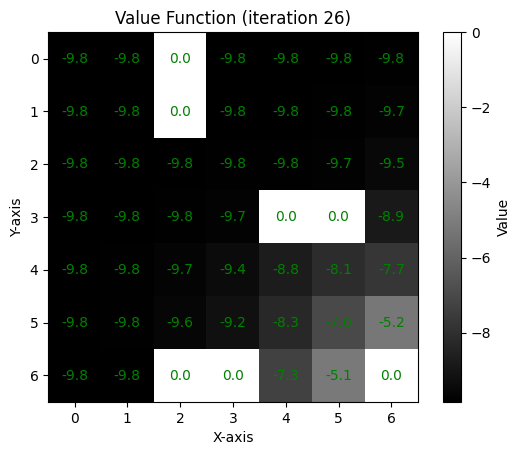

action = 0 V[0, 0] = -1 + 0.9 * -9.81009111258698 = -9.829082001328281
action = 1 V[0, 0] = -1 + 0.9 * -9.828488811810612 = -9.84563993062955
action = 2 V[0, 0] = -1 + 0.9 * -9.81009111258698 = -9.829082001328281
action = 3 V[0, 0] = -1 + 0.9 * -9.823107203909666 = -9.8407964835187
best_action = 0
action = 0 V[0, 1] = -1 + 0.9 * -9.823107203909666 = -9.8407964835187
action = 1 V[0, 1] = -1 + 0.9 * -9.8378092660767 = -9.85402833946903
action = 2 V[0, 1] = -1 + 0.9 * -9.81009111258698 = -9.829082001328281
action = 3 V[0, 1] = -1 + 0.9 * -9.823107203909666 = -9.8407964835187
best_action = 2
action = 0 V[0, 3] = -1 + 0.9 * -9.814342983743666 = -9.832908685369299
action = 1 V[0, 3] = -1 + 0.9 * -9.816463656983185 = -9.834817291284867
action = 2 V[0, 3] = -1 + 0.9 * -9.814342983743666 = -9.832908685369299
action = 3 V[0, 3] = -1 + 0.9 * -9.819152713217687 = -9.837237441895919
best_action = 0
action = 0 V[0, 4] = -1 + 0.9 * -9.819152713217687 = -9.837237441895919
action = 1 V[0, 4] = -1 + 0.9

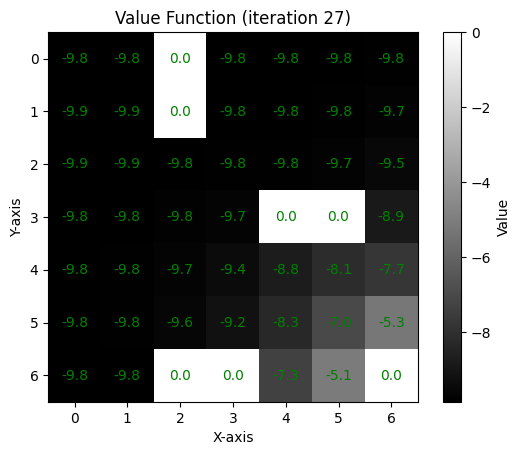

action = 0 V[0, 0] = -1 + 0.9 * -9.836150104201204 = -9.852535093781084
action = 1 V[0, 0] = -1 + 0.9 * -9.850752784339251 = -9.865677505905326
action = 2 V[0, 0] = -1 + 0.9 * -9.836150104201204 = -9.852535093781084
action = 3 V[0, 0] = -1 + 0.9 * -9.847039100071878 = -9.862335190064691
best_action = 0
action = 0 V[0, 1] = -1 + 0.9 * -9.847039100071878 = -9.862335190064691
action = 1 V[0, 1] = -1 + 0.9 * -9.858076661510635 = -9.872268995359573
action = 2 V[0, 1] = -1 + 0.9 * -9.836150104201204 = -9.852535093781084
action = 3 V[0, 1] = -1 + 0.9 * -9.847039100071878 = -9.862335190064691
best_action = 2
action = 0 V[0, 3] = -1 + 0.9 * -9.834468025979845 = -9.851021223381862
action = 1 V[0, 3] = -1 + 0.9 * -9.833419176504986 = -9.850077258854487
action = 2 V[0, 3] = -1 + 0.9 * -9.834468025979845 = -9.851021223381862
action = 3 V[0, 3] = -1 + 0.9 * -9.837014939319204 = -9.853313445387284
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.837014939319204 = -9.853313445387284
action = 1 V[0, 

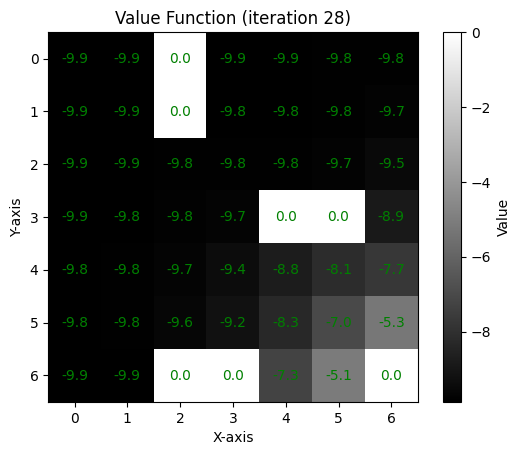

action = 0 V[0, 0] = -1 + 0.9 * -9.858270720883047 = -9.872443648794743
action = 1 V[0, 0] = -1 + 0.9 * -9.869608068002503 = -9.882647261202253
action = 2 V[0, 0] = -1 + 0.9 * -9.858270720883047 = -9.872443648794743
action = 3 V[0, 0] = -1 + 0.9 * -9.867345756070925 = -9.880611180463832
best_action = 0
action = 0 V[0, 1] = -1 + 0.9 * -9.867345756070925 = -9.880611180463832
action = 1 V[0, 1] = -1 + 0.9 * -9.875232201820417 = -9.887708981638376
action = 2 V[0, 1] = -1 + 0.9 * -9.858270720883047 = -9.872443648794743
action = 3 V[0, 1] = -1 + 0.9 * -9.867345756070925 = -9.880611180463832
best_action = 2
action = 0 V[0, 3] = -1 + 0.9 * -9.851358287751374 = -9.866222458976237
action = 1 V[0, 3] = -1 + 0.9 * -9.847642911900966 = -9.86287862071087
action = 2 V[0, 3] = -1 + 0.9 * -9.851358287751374 = -9.866222458976237
action = 3 V[0, 3] = -1 + 0.9 * -9.851998070135982 = -9.866798263122384
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.851998070135982 = -9.866798263122384
action = 1 V[0, 4

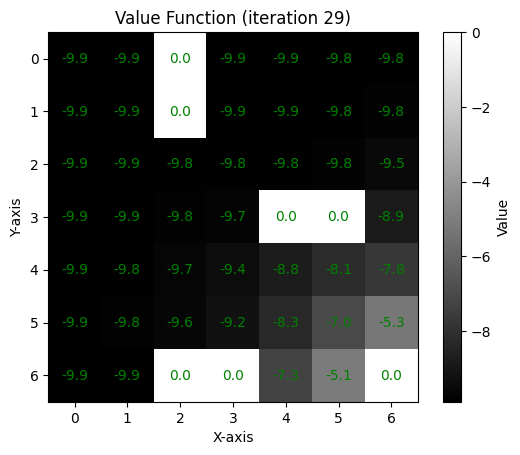

action = 0 V[0, 0] = -1 + 0.9 * -9.877036434813892 = -9.889332791332503
action = 1 V[0, 0] = -1 + 0.9 * -9.885568943172846 = -9.897012048855562
action = 2 V[0, 0] = -1 + 0.9 * -9.877036434813892 = -9.889332791332503
action = 3 V[0, 0] = -1 + 0.9 * -9.884566033474636 = -9.896109430127172
best_action = 0
action = 0 V[0, 1] = -1 + 0.9 * -9.884566033474636 = -9.896109430127172
action = 1 V[0, 1] = -1 + 0.9 * -9.889747270168161 = -9.900772543151346
action = 2 V[0, 1] = -1 + 0.9 * -9.877036434813892 = -9.889332791332503
action = 3 V[0, 1] = -1 + 0.9 * -9.884566033474636 = -9.896109430127172
best_action = 2
action = 0 V[0, 3] = -1 + 0.9 * -9.865530450446432 = -9.87897740540179
action = 1 V[0, 3] = -1 + 0.9 * -9.85957331702964 = -9.873615985326676
action = 2 V[0, 3] = -1 + 0.9 * -9.865530450446432 = -9.87897740540179
action = 3 V[0, 3] = -1 + 0.9 * -9.864563858981983 = -9.878107473083785
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.864563858981983 = -9.878107473083785
action = 1 V[0, 4] 

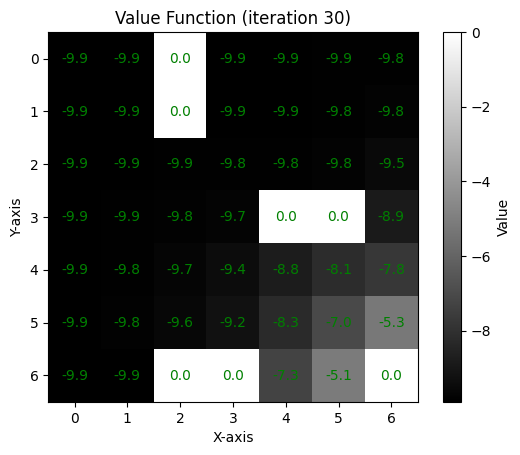

action = 0 V[0, 0] = -1 + 0.9 * -9.892946765411935 = -9.903652088870741
action = 1 V[0, 0] = -1 + 0.9 * -9.899073706643083 = -9.909166335978774
action = 2 V[0, 0] = -1 + 0.9 * -9.892946765411935 = -9.903652088870741
action = 3 V[0, 0] = -1 + 0.9 * -9.899160873069107 = -9.909244785762196
best_action = 0
action = 0 V[0, 1] = -1 + 0.9 * -9.899160873069107 = -9.909244785762196
action = 1 V[0, 1] = -1 + 0.9 * -9.902023192640758 = -9.911820873376683
action = 2 V[0, 1] = -1 + 0.9 * -9.892946765411935 = -9.903652088870741
action = 3 V[0, 1] = -1 + 0.9 * -9.899160873069107 = -9.909244785762196
best_action = 2
action = 0 V[0, 3] = -1 + 0.9 * -9.87741956730351 = -9.889677610573159
action = 1 V[0, 3] = -1 + 0.9 * -9.869578951660479 = -9.88262105649443
action = 2 V[0, 3] = -1 + 0.9 * -9.87741956730351 = -9.889677610573159
action = 3 V[0, 3] = -1 + 0.9 * -9.875100652983475 = -9.887590587685128
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.875100652983475 = -9.887590587685128
action = 1 V[0, 4] 

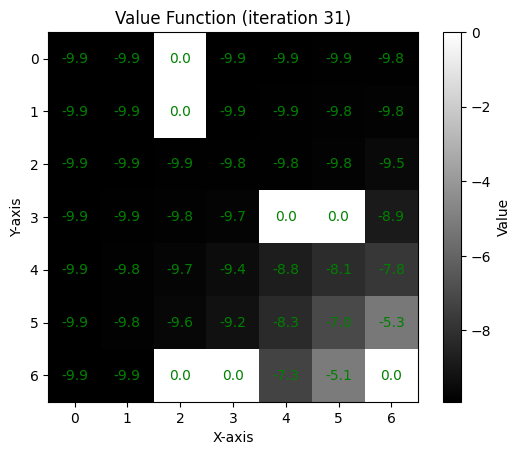

action = 0 V[0, 0] = -1 + 0.9 * -9.906428824870614 = -9.915785942383554
action = 1 V[0, 0] = -1 + 0.9 * -9.91049555315908 = -9.919445997843173
action = 2 V[0, 0] = -1 + 0.9 * -9.906428824870614 = -9.915785942383554
action = 3 V[0, 0] = -1 + 0.9 * -9.911524096821157 = -9.920371687139042
best_action = 0
action = 0 V[0, 1] = -1 + 0.9 * -9.911524096821157 = -9.920371687139042
action = 1 V[0, 1] = -1 + 0.9 * -9.912401363228295 = -9.921161226905465
action = 2 V[0, 1] = -1 + 0.9 * -9.906428824870614 = -9.915785942383554
action = 3 V[0, 1] = -1 + 0.9 * -9.911524096821157 = -9.920371687139042
best_action = 2
action = 0 V[0, 3] = -1 + 0.9 * -9.887391716331468 = -9.898652544698322
action = 1 V[0, 3] = -1 + 0.9 * -9.87796949165839 = -9.890172542492552
action = 2 V[0, 3] = -1 + 0.9 * -9.887391716331468 = -9.898652544698322
action = 3 V[0, 3] = -1 + 0.9 * -9.88393488504129 = -9.895541396537162
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.88393488504129 = -9.895541396537162
action = 1 V[0, 4] =

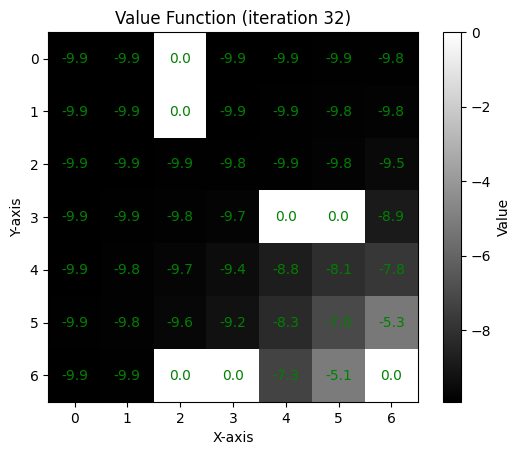

action = 0 V[0, 0] = -1 + 0.9 * -9.91784739243733 = -9.926062653193599
action = 1 V[0, 0] = -1 + 0.9 * -9.92015197400618 = -9.928136776605562
action = 2 V[0, 0] = -1 + 0.9 * -9.91784739243733 = -9.926062653193599
action = 3 V[0, 0] = -1 + 0.9 * -9.921991813594286 = -9.929792632234857
best_action = 0
action = 0 V[0, 1] = -1 + 0.9 * -9.921991813594286 = -9.929792632234857
action = 1 V[0, 1] = -1 + 0.9 * -9.921171967579006 = -9.929054770821105
action = 2 V[0, 1] = -1 + 0.9 * -9.91784739243733 = -9.926062653193599
action = 3 V[0, 1] = -1 + 0.9 * -9.921991813594286 = -9.929792632234857
best_action = 2
action = 0 V[0, 3] = -1 + 0.9 * -9.89575475710659 = -9.90617928139593
action = 1 V[0, 3] = -1 + 0.9 * -9.885005040416132 = -9.89650453637452
action = 2 V[0, 3] = -1 + 0.9 * -9.89575475710659 = -9.90617928139593
action = 3 V[0, 3] = -1 + 0.9 * -9.891340814513756 = -9.90220673306238
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.891340814513756 = -9.90220673306238
action = 1 V[0, 4] = -1 + 0

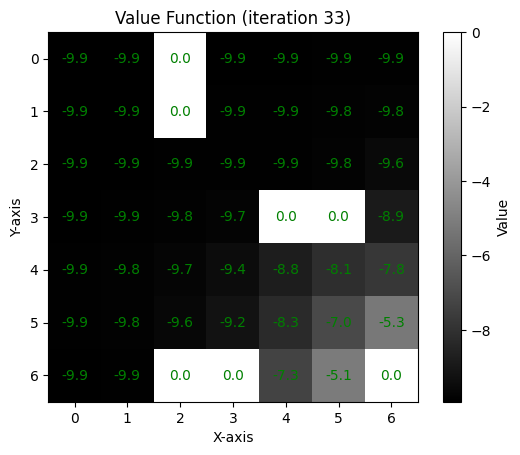

action = 0 V[0, 0] = -1 + 0.9 * -9.927513678806903 = -9.934762310926214
action = 1 V[0, 0] = -1 + 0.9 * -9.928312857810683 = -9.935481572029614
action = 2 V[0, 0] = -1 + 0.9 * -9.927513678806903 = -9.934762310926214
action = 3 V[0, 0] = -1 + 0.9 * -9.930850586554257 = -9.937765527898831
best_action = 0
action = 0 V[0, 1] = -1 + 0.9 * -9.930850586554257 = -9.937765527898831
action = 1 V[0, 1] = -1 + 0.9 * -9.928581485694906 = -9.935723337125415
action = 2 V[0, 1] = -1 + 0.9 * -9.927513678806903 = -9.934762310926214
action = 3 V[0, 1] = -1 + 0.9 * -9.930850586554257 = -9.937765527898831
best_action = 2
action = 0 V[0, 3] = -1 + 0.9 * -9.90276745805719 = -9.91249071225147
action = 1 V[0, 3] = -1 + 0.9 * -9.890903994019126 = -9.901813594617215
action = 2 V[0, 3] = -1 + 0.9 * -9.90276745805719 = -9.91249071225147
action = 3 V[0, 3] = -1 + 0.9 * -9.897548770638364 = -9.907793893574528
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.897548770638364 = -9.907793893574528
action = 1 V[0, 4] =

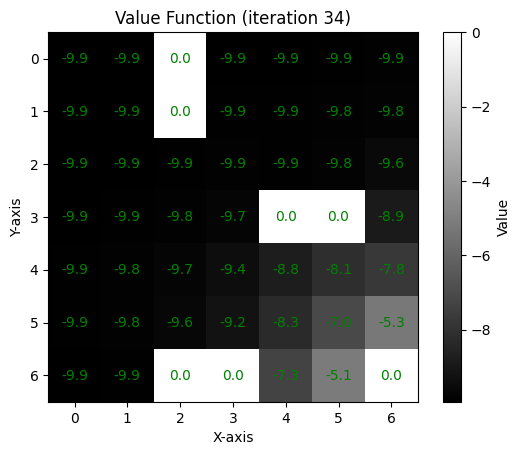

action = 0 V[0, 0] = -1 + 0.9 * -9.935692930445217 = -9.942123637400696
action = 1 V[0, 0] = -1 + 0.9 * -9.935207459569474 = -9.941686713612526
action = 2 V[0, 0] = -1 + 0.9 * -9.935692930445217 = -9.942123637400696
action = 3 V[0, 0] = -1 + 0.9 * -9.938344507580943 = -9.94451005682285
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.938344507580943 = -9.94451005682285
action = 1 V[0, 1] = -1 + 0.9 * -9.93483913372859 = -9.94135522035573
action = 2 V[0, 1] = -1 + 0.9 * -9.935692930445217 = -9.942123637400696
action = 3 V[0, 1] = -1 + 0.9 * -9.938344507580943 = -9.94451005682285
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.90864722817367 = -9.917782505356303
action = 1 V[0, 3] = -1 + 0.9 * -9.895849677717937 = -9.906264709946143
action = 2 V[0, 3] = -1 + 0.9 * -9.90864722817367 = -9.917782505356303
action = 3 V[0, 3] = -1 + 0.9 * -9.902752119372266 = -9.91247690743504
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.902752119372266 = -9.91247690743504
action = 1 V[0, 4] = -1 +

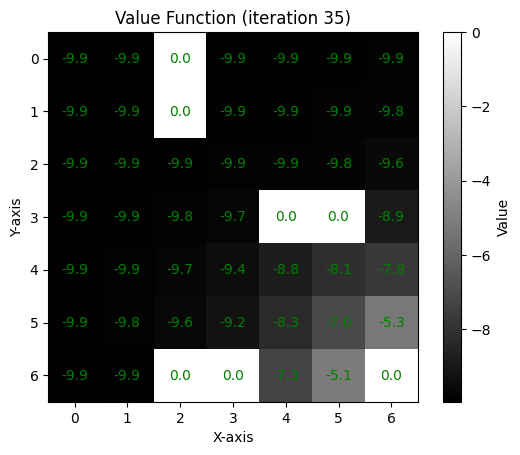

action = 0 V[0, 0] = -1 + 0.9 * -9.942611011309193 = -9.948349910178274
action = 1 V[0, 0] = -1 + 0.9 * -9.941030385747402 = -9.946927347172661
action = 2 V[0, 0] = -1 + 0.9 * -9.942611011309193 = -9.948349910178274
action = 3 V[0, 0] = -1 + 0.9 * -9.944681311044926 = -9.950213179940434
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.944681311044926 = -9.950213179940434
action = 1 V[0, 1] = -1 + 0.9 * -9.940122386484537 = -9.946110147836084
action = 2 V[0, 1] = -1 + 0.9 * -9.942611011309193 = -9.948349910178274
action = 3 V[0, 1] = -1 + 0.9 * -9.944681311044926 = -9.950213179940434
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.913576657023448 = -9.922218991321104
action = 1 V[0, 3] = -1 + 0.9 * -9.899995940468528 = -9.909996346421677
action = 2 V[0, 3] = -1 + 0.9 * -9.913576657023448 = -9.922218991321104
action = 3 V[0, 3] = -1 + 0.9 * -9.907113144377153 = -9.916401829939439
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.907113144377153 = -9.916401829939439
action = 1 V[0, 

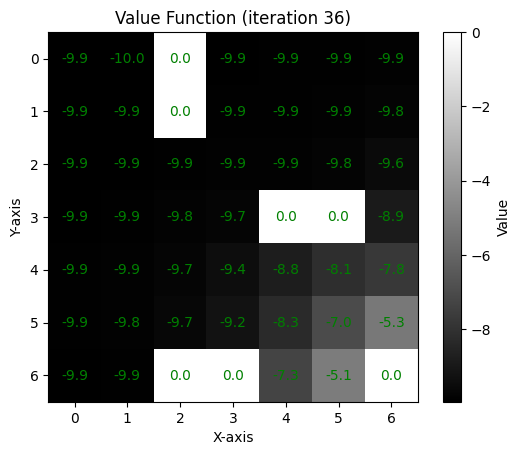

action = 0 V[0, 0] = -1 + 0.9 * -9.94846008686741 = -9.953614078180669
action = 1 V[0, 0] = -1 + 0.9 * -9.945946726336608 = -9.951352053702948
action = 2 V[0, 0] = -1 + 0.9 * -9.94846008686741 = -9.953614078180669
action = 3 V[0, 0] = -1 + 0.9 * -9.950037646474405 = -9.955033881826964
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.950037646474405 = -9.955033881826964
action = 1 V[0, 1] = -1 + 0.9 * -9.94458170523011 = -9.9501235347071
action = 2 V[0, 1] = -1 + 0.9 * -9.94846008686741 = -9.953614078180669
action = 3 V[0, 1] = -1 + 0.9 * -9.950037646474405 = -9.955033881826964
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.91770903975083 = -9.925938135775748
action = 1 V[0, 3] = -1 + 0.9 * -9.903471867317634 = -9.913124680585872
action = 2 V[0, 3] = -1 + 0.9 * -9.91770903975083 = -9.925938135775748
action = 3 V[0, 3] = -1 + 0.9 * -9.910768006266027 = -9.919691205639424
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.910768006266027 = -9.919691205639424
action = 1 V[0, 4] = -1 

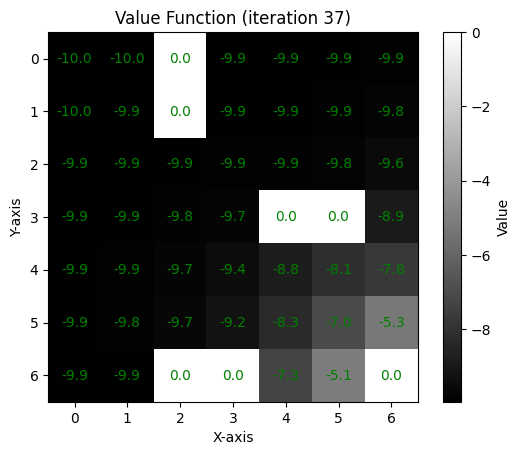

action = 0 V[0, 0] = -1 + 0.9 * -9.953403522972813 = -9.958063170675532
action = 1 V[0, 0] = -1 + 0.9 * -9.950096449190195 = -9.955086804271176
action = 2 V[0, 0] = -1 + 0.9 * -9.953403522972813 = -9.958063170675532
action = 3 V[0, 0] = -1 + 0.9 * -9.95456361725914 = -9.959107255533226
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.95456361725914 = -9.959107255533226
action = 1 V[0, 1] = -1 + 0.9 * -9.948344580010854 = -9.953510122009769
action = 2 V[0, 1] = -1 + 0.9 * -9.953403522972813 = -9.958063170675532
action = 3 V[0, 1] = -1 + 0.9 * -9.95456361725914 = -9.959107255533226
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.921173039444199 = -9.929055735499778
action = 1 V[0, 3] = -1 + 0.9 * -9.906385745938955 = -9.91574717134506
action = 2 V[0, 3] = -1 + 0.9 * -9.921173039444199 = -9.929055735499778
action = 3 V[0, 3] = -1 + 0.9 * -9.913830920809716 = -9.922447828728744
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.913830920809716 = -9.922447828728744
action = 1 V[0, 4] =

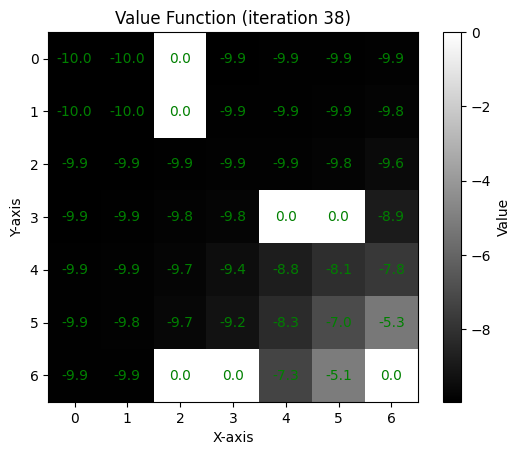

action = 0 V[0, 0] = -1 + 0.9 * -9.957580100288865 = -9.961822090259979
action = 1 V[0, 0] = -1 + 0.9 * -9.953598157774525 = -9.958238341997074
action = 2 V[0, 0] = -1 + 0.9 * -9.957580100288865 = -9.961822090259979
action = 3 V[0, 0] = -1 + 0.9 * -9.95838668083405 = -9.962548012750645
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.95838668083405 = -9.962548012750645
action = 1 V[0, 1] = -1 + 0.9 * -9.951518981812548 = -9.956367083631294
action = 2 V[0, 1] = -1 + 0.9 * -9.957580100288865 = -9.961822090259979
action = 3 V[0, 1] = -1 + 0.9 * -9.95838668083405 = -9.962548012750645
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.92407661776834 = -9.931668955991507
action = 1 V[0, 3] = -1 + 0.9 * -9.908828403320085 = -9.917945562988077
action = 2 V[0, 3] = -1 + 0.9 * -9.92407661776834 = -9.931668955991507
action = 3 V[0, 3] = -1 + 0.9 * -9.916397676341717 = -9.924757908707546
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.916397676341717 = -9.924757908707546
action = 1 V[0, 4] = 

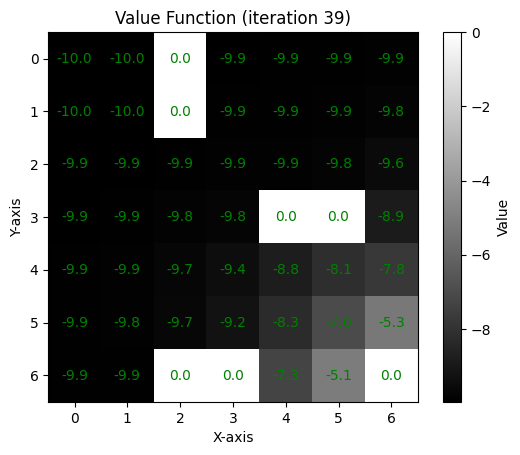

action = 0 V[0, 0] = -1 + 0.9 * -9.961107633816919 = -9.964996870435227
action = 1 V[0, 0] = -1 + 0.9 * -9.95655230071955 = -9.960897070647595
action = 2 V[0, 0] = -1 + 0.9 * -9.961107633816919 = -9.964996870435227
action = 3 V[0, 0] = -1 + 0.9 * -9.961614994891953 = -9.965453495402757
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.961614994891953 = -9.965453495402757
action = 1 V[0, 1] = -1 + 0.9 * -9.954196307549603 = -9.958776676794644
action = 2 V[0, 1] = -1 + 0.9 * -9.961107633816919 = -9.964996870435227
action = 3 V[0, 1] = -1 + 0.9 * -9.961614994891953 = -9.965453495402757
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.92651034591966 = -9.933859311327694
action = 1 V[0, 3] = -1 + 0.9 * -9.910876011112899 = -9.91978841000161
action = 2 V[0, 3] = -1 + 0.9 * -9.92651034591966 = -9.933859311327694
action = 3 V[0, 3] = -1 + 0.9 * -9.918548592836913 = -9.926693733553222
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.918548592836913 = -9.926693733553222
action = 1 V[0, 4] =

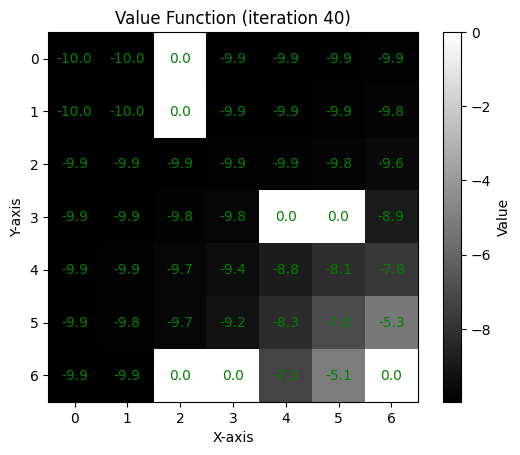

action = 0 V[0, 0] = -1 + 0.9 * -9.9640860767302 = -9.96767746905718
action = 1 V[0, 0] = -1 + 0.9 * -9.959043910133756 = -9.96313951912038
action = 2 V[0, 0] = -1 + 0.9 * -9.9640860767302 = -9.96767746905718
action = 3 V[0, 0] = -1 + 0.9 * -9.964340284164335 = -9.967906255747902
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.964340284164335 = -9.967906255747902
action = 1 V[0, 1] = -1 + 0.9 * -9.956453889893014 = -9.960808500903713
action = 2 V[0, 1] = -1 + 0.9 * -9.9640860767302 = -9.96767746905718
action = 3 V[0, 1] = -1 + 0.9 * -9.964340284164335 = -9.967906255747902
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.928550191552555 = -9.935695172397299
action = 1 V[0, 3] = -1 + 0.9 * -9.912592443158701 = -9.92133319884283
action = 2 V[0, 3] = -1 + 0.9 * -9.928550191552555 = -9.935695172397299
action = 3 V[0, 3] = -1 + 0.9 * -9.920351009797088 = -9.92831590881738
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.920351009797088 = -9.92831590881738
action = 1 V[0, 4] = -1 + 0.9

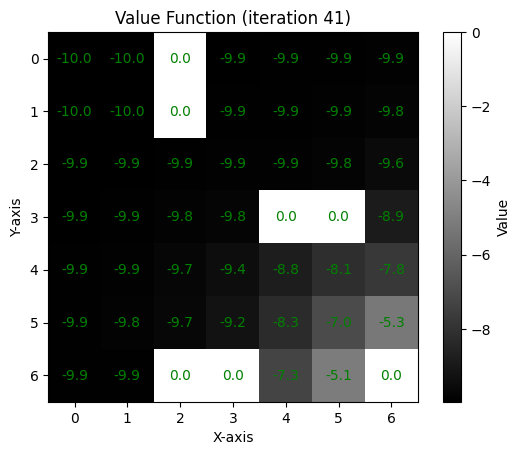

action = 0 V[0, 0] = -1 + 0.9 * -9.96660017824566 = -9.969940160421094
action = 1 V[0, 0] = -1 + 0.9 * -9.961144935512046 = -9.965030441960842
action = 2 V[0, 0] = -1 + 0.9 * -9.96660017824566 = -9.969940160421094
action = 3 V[0, 0] = -1 + 0.9 * -9.966640293205153 = -9.969976263884638
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.966640293205153 = -9.969976263884638
action = 1 V[0, 1] = -1 + 0.9 * -9.95835713427402 = -9.962521420846619
action = 2 V[0, 1] = -1 + 0.9 * -9.96660017824566 = -9.969940160421094
action = 3 V[0, 1] = -1 + 0.9 * -9.966640293205153 = -9.969976263884638
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.930259863113703 = -9.937233876802333
action = 1 V[0, 3] = -1 + 0.9 * -9.914031255871782 = -9.922628130284604
action = 2 V[0, 3] = -1 + 0.9 * -9.930259863113703 = -9.937233876802333
action = 3 V[0, 3] = -1 + 0.9 * -9.921861376881289 = -9.92967523919316
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.921861376881289 = -9.92967523919316
action = 1 V[0, 4] = -

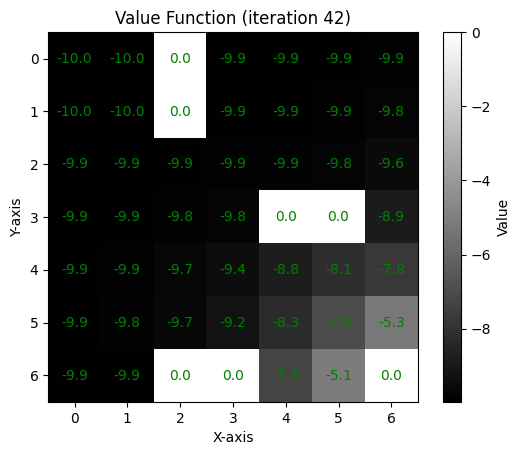

action = 0 V[0, 0] = -1 + 0.9 * -9.968721756671918 = -9.971849581004728
action = 1 V[0, 0] = -1 + 0.9 * -9.962916231108412 = -9.966624607997572
action = 2 V[0, 0] = -1 + 0.9 * -9.968721756671918 = -9.971849581004728
action = 3 V[0, 0] = -1 + 0.9 * -9.968580882405156 = -9.971722794164641
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.968580882405156 = -9.971722794164641
action = 1 V[0, 1] = -1 + 0.9 * -9.959961336898967 = -9.96396520320907
action = 2 V[0, 1] = -1 + 0.9 * -9.968721756671918 = -9.971849581004728
action = 3 V[0, 1] = -1 + 0.9 * -9.968580882405156 = -9.971722794164641
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.931692780770607 = -9.938523502693547
action = 1 V[0, 3] = -1 + 0.9 * -9.915237351227264 = -9.923713616104537
action = 2 V[0, 3] = -1 + 0.9 * -9.931692780770607 = -9.938523502693547
action = 3 V[0, 3] = -1 + 0.9 * -9.92312700991313 = -9.930814308921818
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.92312700991313 = -9.930814308921818
action = 1 V[0, 4] 

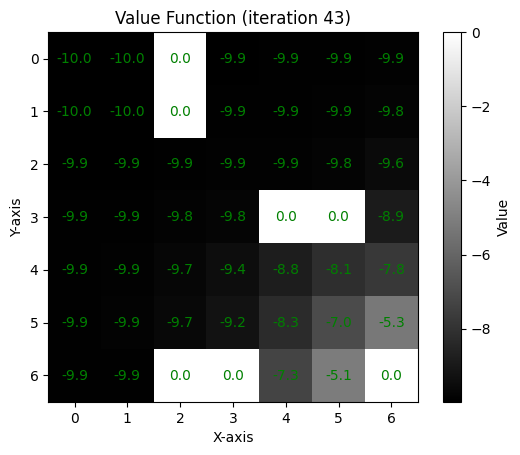

action = 0 V[0, 0] = -1 + 0.9 * -9.970511641042917 = -9.973460476938625
action = 1 V[0, 0] = -1 + 0.9 * -9.964409246770366 = -9.967968322093329
action = 2 V[0, 0] = -1 + 0.9 * -9.970511641042917 = -9.973460476938625
action = 3 V[0, 0] = -1 + 0.9 * -9.970217817119245 = -9.973196035407321
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.970217817119245 = -9.973196035407321
action = 1 V[0, 1] = -1 + 0.9 * -9.961313230173076 = -9.965181907155769
action = 2 V[0, 1] = -1 + 0.9 * -9.970511641042917 = -9.973460476938625
action = 3 V[0, 1] = -1 + 0.9 * -9.970217817119245 = -9.973196035407321
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.932893732603363 = -9.939604359343027
action = 1 V[0, 3] = -1 + 0.9 * -9.916248372794392 = -9.924623535514954
action = 2 V[0, 3] = -1 + 0.9 * -9.932893732603363 = -9.939604359343027
action = 3 V[0, 3] = -1 + 0.9 * -9.92418756523972 = -9.931768808715749
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.92418756523972 = -9.931768808715749
action = 1 V[0, 4]

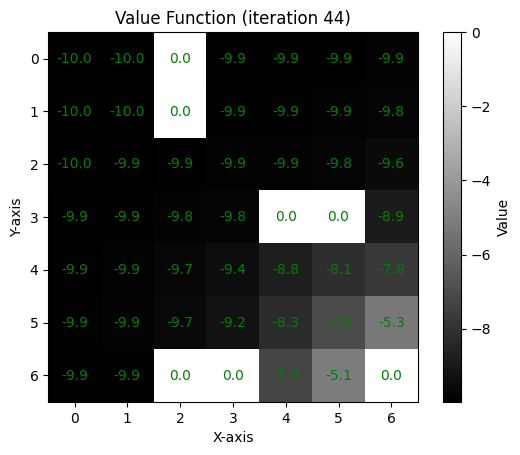

action = 0 V[0, 0] = -1 + 0.9 * -9.972021327844475 = -9.974819195060027
action = 1 V[0, 0] = -1 + 0.9 * -9.965667465336736 = -9.969100718803062
action = 2 V[0, 0] = -1 + 0.9 * -9.972021327844475 = -9.974819195060027
action = 3 V[0, 0] = -1 + 0.9 * -9.971598293257609 = -9.974438463931849
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.971598293257609 = -9.974438463931849
action = 1 V[0, 1] = -1 + 0.9 * -9.96245229544571 = -9.96620706590114
action = 2 V[0, 1] = -1 + 0.9 * -9.972021327844475 = -9.974819195060027
action = 3 V[0, 1] = -1 + 0.9 * -9.971598293257609 = -9.974438463931849
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.93390026572919 = -9.940510239156271
action = 1 V[0, 3] = -1 + 0.9 * -9.917095877357635 = -9.925386289621873
action = 2 V[0, 3] = -1 + 0.9 * -9.93390026572919 = -9.940510239156271
action = 3 V[0, 3] = -1 + 0.9 * -9.925076277189806 = -9.932568649470825
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.925076277189806 = -9.932568649470825
action = 1 V[0, 4] =

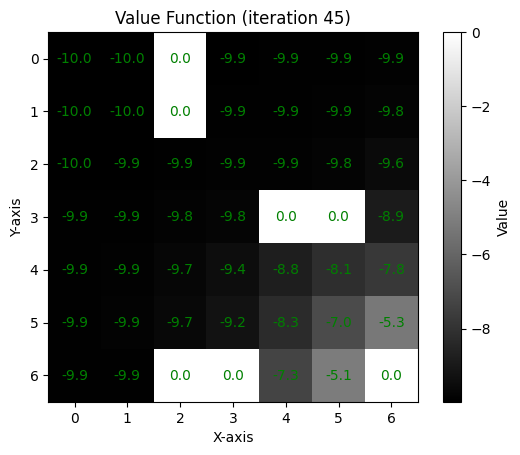

action = 0 V[0, 0] = -1 + 0.9 * -9.973294393213742 = -9.975964953892367
action = 1 V[0, 0] = -1 + 0.9 * -9.966727623684712 = -9.97005486131624
action = 2 V[0, 0] = -1 + 0.9 * -9.973294393213742 = -9.975964953892367
action = 3 V[0, 0] = -1 + 0.9 * -9.972762236914301 = -9.975486013222872
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.972762236914301 = -9.975486013222872
action = 1 V[0, 1] = -1 + 0.9 * -9.963411877352588 = -9.96707068961733
action = 2 V[0, 1] = -1 + 0.9 * -9.973294393213742 = -9.975964953892367
action = 3 V[0, 1] = -1 + 0.9 * -9.972762236914301 = -9.975486013222872
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.93474385435131 = -9.94126946891618
action = 1 V[0, 3] = -1 + 0.9 * -9.917806317974097 = -9.926025686176688
action = 2 V[0, 3] = -1 + 0.9 * -9.93474385435131 = -9.94126946891618
action = 3 V[0, 3] = -1 + 0.9 * -9.925820996386234 = -9.93323889674761
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.925820996386234 = -9.93323889674761
action = 1 V[0, 4] = -1 

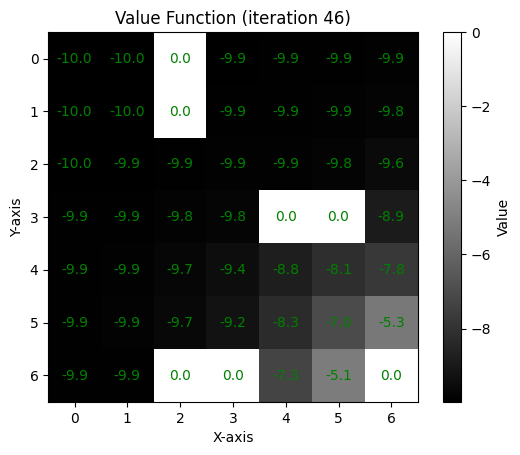

action = 0 V[0, 0] = -1 + 0.9 * -9.97436769558096 = -9.976930926022865
action = 1 V[0, 0] = -1 + 0.9 * -9.967620749280245 = -9.97085867435222
action = 2 V[0, 0] = -1 + 0.9 * -9.97436769558096 = -9.976930926022865
action = 3 V[0, 0] = -1 + 0.9 * -9.973743410521484 = -9.976369069469335
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.973743410521484 = -9.976369069469335
action = 1 V[0, 1] = -1 + 0.9 * -9.96422012914387 = -9.967798116229483
action = 2 V[0, 1] = -1 + 0.9 * -9.97436769558096 = -9.976930926022865
action = 3 V[0, 1] = -1 + 0.9 * -9.973743410521484 = -9.976369069469335
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.935450880189165 = -9.94190579217025
action = 1 V[0, 3] = -1 + 0.9 * -9.91840186865193 = -9.926561681786737
action = 2 V[0, 3] = -1 + 0.9 * -9.935450880189165 = -9.94190579217025
action = 3 V[0, 3] = -1 + 0.9 * -9.926445060736242 = -9.933800554662618
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.926445060736242 = -9.933800554662618
action = 1 V[0, 4] = -1 

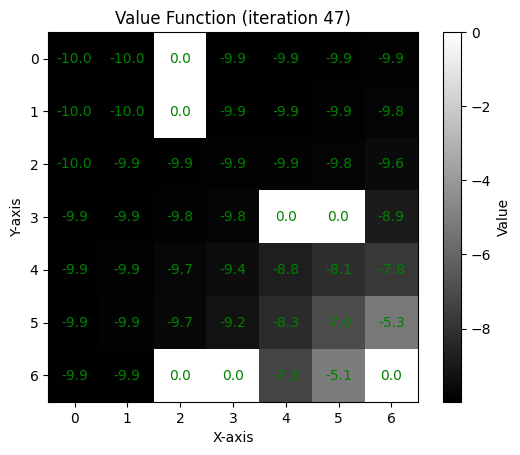

action = 0 V[0, 0] = -1 + 0.9 * -9.97527239896682 = -9.977745159070139
action = 1 V[0, 0] = -1 + 0.9 * -9.968373039549082 = -9.971535735594173
action = 2 V[0, 0] = -1 + 0.9 * -9.97527239896682 = -9.977745159070139
action = 3 V[0, 0] = -1 + 0.9 * -9.974570353559573 = -9.977113318203616
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.974570353559573 = -9.977113318203616
action = 1 V[0, 1] = -1 + 0.9 * -9.964900814161512 = -9.96841073274536
action = 2 V[0, 1] = -1 + 0.9 * -9.97527239896682 = -9.977745159070139
action = 3 V[0, 1] = -1 + 0.9 * -9.974570353559573 = -9.977113318203616
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.936043455197463 = -9.942439109677718
action = 1 V[0, 3] = -1 + 0.9 * -9.918901116048257 = -9.927011004443433
action = 2 V[0, 3] = -1 + 0.9 * -9.936043455197463 = -9.942439109677718
action = 3 V[0, 3] = -1 + 0.9 * -9.926968025900315 = -9.934271223310285
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.926968025900315 = -9.934271223310285
action = 1 V[0, 4] =

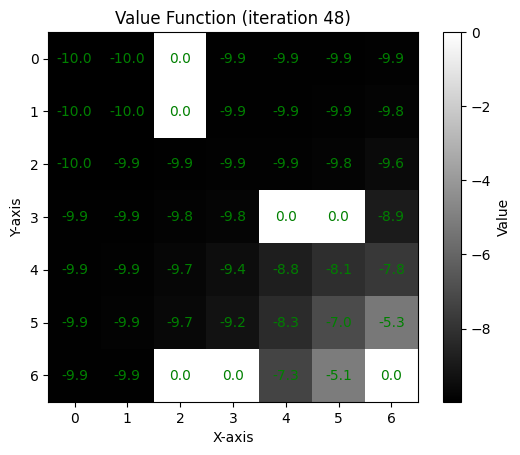

action = 0 V[0, 0] = -1 + 0.9 * -9.976034842984516 = -9.978431358686064
action = 1 V[0, 0] = -1 + 0.9 * -9.969006607461205 = -9.972105946715084
action = 2 V[0, 0] = -1 + 0.9 * -9.976034842984516 = -9.978431358686064
action = 3 V[0, 0] = -1 + 0.9 * -9.975267181959664 = -9.977740463763698
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.975267181959664 = -9.977740463763698
action = 1 V[0, 1] = -1 + 0.9 * -9.965473984983452 = -9.968926586485107
action = 2 V[0, 1] = -1 + 0.9 * -9.976034842984516 = -9.978431358686064
action = 3 V[0, 1] = -1 + 0.9 * -9.975267181959664 = -9.977740463763698
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.936540111777289 = -9.94288610059956
action = 1 V[0, 3] = -1 + 0.9 * -9.919319639545474 = -9.927387675590927
action = 2 V[0, 3] = -1 + 0.9 * -9.936540111777289 = -9.94288610059956
action = 3 V[0, 3] = -1 + 0.9 * -9.927406277793166 = -9.93466565001385
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.927406277793166 = -9.93466565001385
action = 1 V[0, 4] =

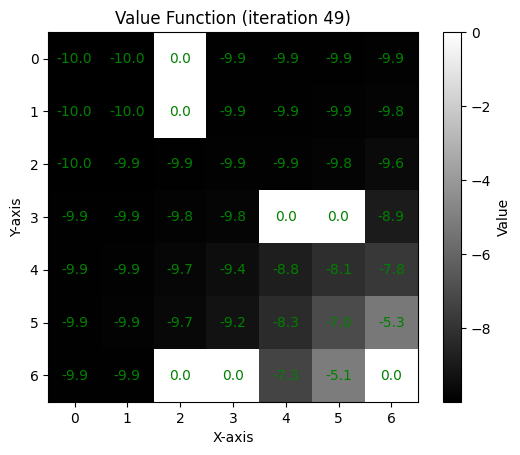

action = 0 V[0, 0] = -1 + 0.9 * -9.97667728196273 = -9.979009553766456
action = 1 V[0, 0] = -1 + 0.9 * -9.96954011333439 = -9.972586102000951
action = 2 V[0, 0] = -1 + 0.9 * -9.97667728196273 = -9.979009553766456
action = 3 V[0, 0] = -1 + 0.9 * -9.97585426694474 = -9.978268840250266
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.97585426694474 = -9.978268840250266
action = 1 V[0, 1] = -1 + 0.9 * -9.965956558612689 = -9.96936090275142
action = 2 V[0, 1] = -1 + 0.9 * -9.97667728196273 = -9.979009553766456
action = 3 V[0, 1] = -1 + 0.9 * -9.97585426694474 = -9.978268840250266
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.936956381700973 = -9.943260743530876
action = 1 V[0, 3] = -1 + 0.9 * -9.919670497658334 = -9.927703447892501
action = 2 V[0, 3] = -1 + 0.9 * -9.936956381700973 = -9.943260743530876
action = 3 V[0, 3] = -1 + 0.9 * -9.927773546083873 = -9.934996191475486
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.927773546083873 = -9.934996191475486
action = 1 V[0, 4] = -1 

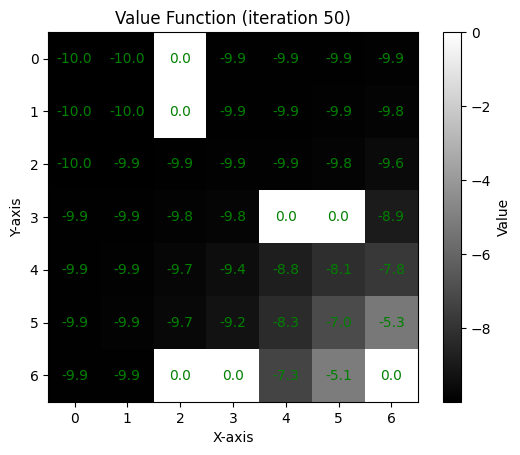

action = 0 V[0, 0] = -1 + 0.9 * -9.977218512446033 = -9.97949666120143
action = 1 V[0, 0] = -1 + 0.9 * -9.969989299945443 = -9.9729903699509
action = 2 V[0, 0] = -1 + 0.9 * -9.977218512446033 = -9.97949666120143
action = 3 V[0, 0] = -1 + 0.9 * -9.976348811113345 = -9.97871393000201
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.976348811113345 = -9.97871393000201
action = 1 V[0, 1] = -1 + 0.9 * -9.966362803390814 = -9.969726523051733
action = 2 V[0, 1] = -1 + 0.9 * -9.977218512446033 = -9.97949666120143
action = 3 V[0, 1] = -1 + 0.9 * -9.976348811113345 = -9.97871393000201
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.937305281607435 = -9.943574753446692
action = 1 V[0, 3] = -1 + 0.9 * -9.919964635854553 = -9.927968172269098
action = 2 V[0, 3] = -1 + 0.9 * -9.937305281607435 = -9.943574753446692
action = 3 V[0, 3] = -1 + 0.9 * -9.928081334636882 = -9.935273201173194
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.928081334636882 = -9.935273201173194
action = 1 V[0, 4] = -1 

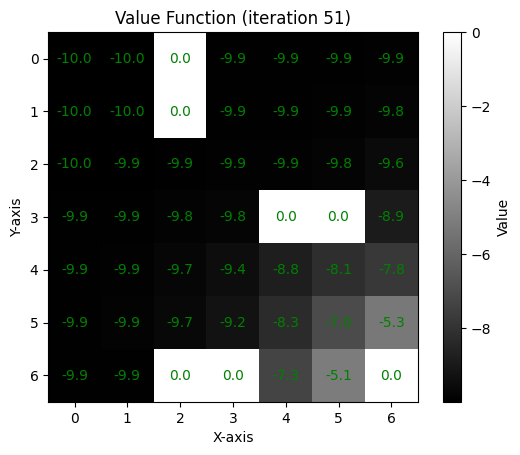

action = 0 V[0, 0] = -1 + 0.9 * -9.977674405588942 = -9.979906965030048
action = 1 V[0, 0] = -1 + 0.9 * -9.970367445529646 = -9.973330700976682
action = 2 V[0, 0] = -1 + 0.9 * -9.977674405588942 = -9.979906965030048
action = 3 V[0, 0] = -1 + 0.9 * -9.97676533702145 = -9.979088803319305
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.97676533702145 = -9.979088803319305
action = 1 V[0, 1] = -1 + 0.9 * -9.966704750999815 = -9.970034275899835
action = 2 V[0, 1] = -1 + 0.9 * -9.977674405588942 = -9.979906965030048
action = 3 V[0, 1] = -1 + 0.9 * -9.97676533702145 = -9.979088803319305
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.93759772008392 = -9.943837948075528
action = 1 V[0, 3] = -1 + 0.9 * -9.92021122845557 = -9.928190105610012
action = 2 V[0, 3] = -1 + 0.9 * -9.93759772008392 = -9.943837948075528
action = 3 V[0, 3] = -1 + 0.9 * -9.92833928228603 = -9.935505354057428
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.92833928228603 = -9.935505354057428
action = 1 V[0, 4] = -1 

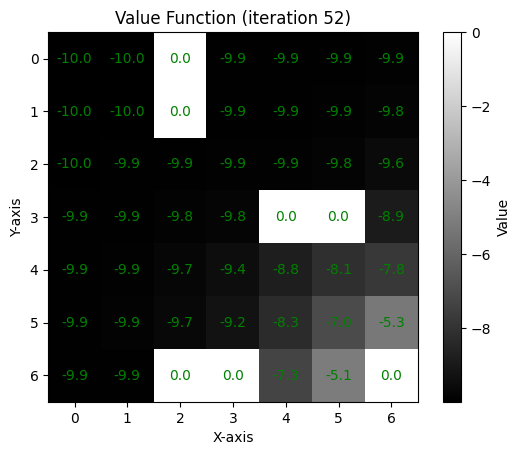

action = 0 V[0, 0] = -1 + 0.9 * -9.97805835858902 = -9.980252522730119
action = 1 V[0, 0] = -1 + 0.9 * -9.970685747096375 = -9.973617172386739
action = 2 V[0, 0] = -1 + 0.9 * -9.97805835858902 = -9.980252522730119
action = 3 V[0, 0] = -1 + 0.9 * -9.977116101317142 = -9.979404491185427
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.977116101317142 = -9.979404491185427
action = 1 V[0, 1] = -1 + 0.9 * -9.966992544931653 = -9.970293290438487
action = 2 V[0, 1] = -1 + 0.9 * -9.97805835858902 = -9.980252522730119
action = 3 V[0, 1] = -1 + 0.9 * -9.977116101317142 = -9.979404491185427
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.937842838954623 = -9.944058555059161
action = 1 V[0, 3] = -1 + 0.9 * -9.920417965251737 = -9.928376168726563
action = 2 V[0, 3] = -1 + 0.9 * -9.937842838954623 = -9.944058555059161
action = 3 V[0, 3] = -1 + 0.9 * -9.928555465187198 = -9.93569991866848
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.928555465187198 = -9.93569991866848
action = 1 V[0, 4] = 

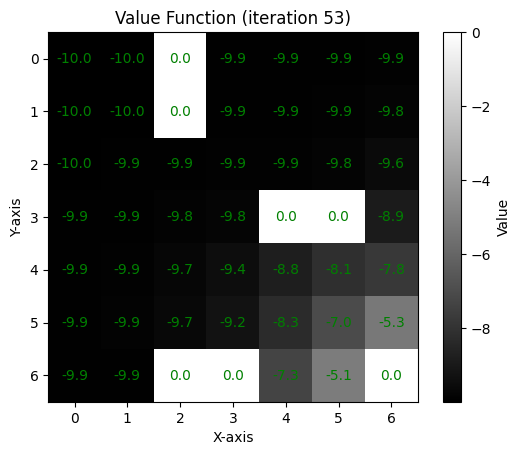

action = 0 V[0, 0] = -1 + 0.9 * -9.9783816772581 = -9.980543509532291
action = 1 V[0, 0] = -1 + 0.9 * -9.970953644644226 = -9.973858280179803
action = 2 V[0, 0] = -1 + 0.9 * -9.9783816772581 = -9.980543509532291
action = 3 V[0, 0] = -1 + 0.9 * -9.977411445585409 = -9.979670301026868
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.977411445585409 = -9.979670301026868
action = 1 V[0, 1] = -1 + 0.9 * -9.96723473510718 = -9.970511261596462
action = 2 V[0, 1] = -1 + 0.9 * -9.9783816772581 = -9.980543509532291
action = 3 V[0, 1] = -1 + 0.9 * -9.977411445585409 = -9.979670301026868
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.938048299378341 = -9.944243469440508
action = 1 V[0, 3] = -1 + 0.9 * -9.920591291757159 = -9.928532162581444
action = 2 V[0, 3] = -1 + 0.9 * -9.938048299378341 = -9.944243469440508
action = 3 V[0, 3] = -1 + 0.9 * -9.928736650189018 = -9.935862985170116
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.928736650189018 = -9.935862985170116
action = 1 V[0, 4] = -1

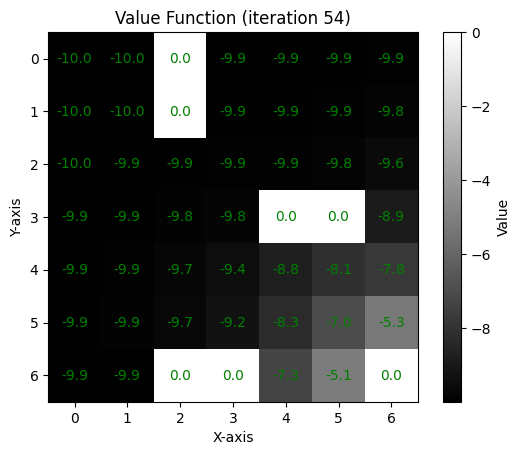

action = 0 V[0, 0] = -1 + 0.9 * -9.978653900067812 = -9.98078851006103
action = 1 V[0, 0] = -1 + 0.9 * -9.97117909528024 = -9.974061185752216
action = 2 V[0, 0] = -1 + 0.9 * -9.978653900067812 = -9.98078851006103
action = 3 V[0, 0] = -1 + 0.9 * -9.977660093427808 = -9.979894084085027
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.977660093427808 = -9.979894084085027
action = 1 V[0, 1] = -1 + 0.9 * -9.967438526874812 = -9.970694674187332
action = 2 V[0, 1] = -1 + 0.9 * -9.978653900067812 = -9.98078851006103
action = 3 V[0, 1] = -1 + 0.9 * -9.977660093427808 = -9.979894084085027
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.938220521658144 = -9.944398469492329
action = 1 V[0, 3] = -1 + 0.9 * -9.920736610593146 = -9.928662949533832
action = 2 V[0, 3] = -1 + 0.9 * -9.938220521658144 = -9.944398469492329
action = 3 V[0, 3] = -1 + 0.9 * -9.928888507142444 = -9.9359996564282
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.928888507142444 = -9.9359996564282
action = 1 V[0, 4] = -1 

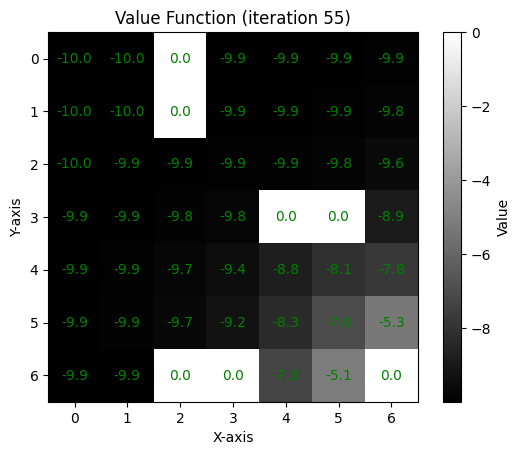

action = 0 V[0, 0] = -1 + 0.9 * -9.978883072489825 = -9.980994765240844
action = 1 V[0, 0] = -1 + 0.9 * -9.971368804898535 = -9.974231924408683
action = 2 V[0, 0] = -1 + 0.9 * -9.978883072489825 = -9.980994765240844
action = 3 V[0, 0] = -1 + 0.9 * -9.977869401899557 = -9.980082461709602
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.977869401899557 = -9.980082461709602
action = 1 V[0, 1] = -1 + 0.9 * -9.967609991380609 = -9.970848992242548
action = 2 V[0, 1] = -1 + 0.9 * -9.978883072489825 = -9.980994765240844
action = 3 V[0, 1] = -1 + 0.9 * -9.977869401899557 = -9.980082461709602
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.938364886236673 = -9.944528397613006
action = 1 V[0, 3] = -1 + 0.9 * -9.920858450282903 = -9.928772605254613
action = 2 V[0, 3] = -1 + 0.9 * -9.938364886236673 = -9.944528397613006
action = 3 V[0, 3] = -1 + 0.9 * -9.929015786793789 = -9.936114208114411
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929015786793789 = -9.936114208114411
action = 1 V[0, 

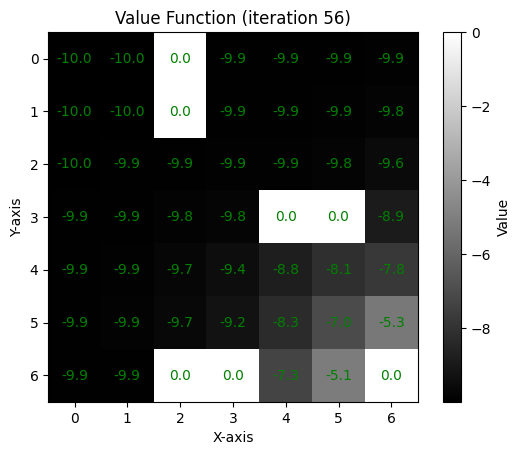

action = 0 V[0, 0] = -1 + 0.9 * -9.979075979149993 = -9.981168381234994
action = 1 V[0, 0] = -1 + 0.9 * -9.9715284239217 = -9.97437558152953
action = 2 V[0, 0] = -1 + 0.9 * -9.979075979149993 = -9.981168381234994
action = 3 V[0, 0] = -1 + 0.9 * -9.978045574224186 = -9.980241016801768
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978045574224186 = -9.980241016801768
action = 1 V[0, 1] = -1 + 0.9 * -9.967754243244975 = -9.970978818920479
action = 2 V[0, 1] = -1 + 0.9 * -9.979075979149993 = -9.981168381234994
action = 3 V[0, 1] = -1 + 0.9 * -9.978045574224186 = -9.980241016801768
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.93848590214876 = -9.944637311933883
action = 1 V[0, 3] = -1 + 0.9 * -9.920960606726856 = -9.928864546054172
action = 2 V[0, 3] = -1 + 0.9 * -9.93848590214876 = -9.944637311933883
action = 3 V[0, 3] = -1 + 0.9 * -9.929122469833887 = -9.936210222850498
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929122469833887 = -9.936210222850498
action = 1 V[0, 4] = 

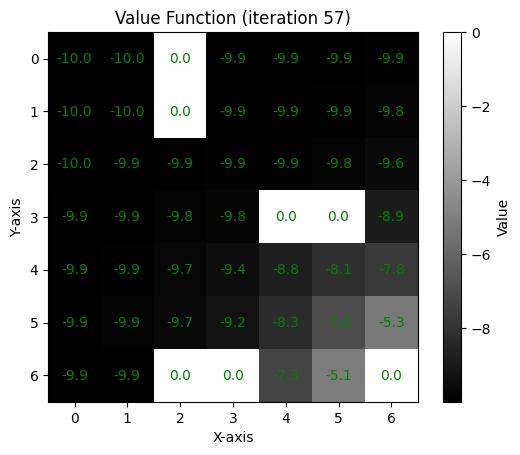

action = 0 V[0, 0] = -1 + 0.9 * -9.979238340200322 = -9.98131450618029
action = 1 V[0, 0] = -1 + 0.9 * -9.971662712625873 = -9.974496441363286
action = 2 V[0, 0] = -1 + 0.9 * -9.979238340200322 = -9.98131450618029
action = 3 V[0, 0] = -1 + 0.9 * -9.978193839676077 = -9.98037445570847
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978193839676077 = -9.98037445570847
action = 1 V[0, 1] = -1 + 0.9 * -9.967875590581315 = -9.971088031523184
action = 2 V[0, 1] = -1 + 0.9 * -9.979238340200322 = -9.98131450618029
action = 3 V[0, 1] = -1 + 0.9 * -9.978193839676077 = -9.98037445570847
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.938587348193108 = -9.944728613373798
action = 1 V[0, 3] = -1 + 0.9 * -9.921046261777636 = -9.928941635599873
action = 2 V[0, 3] = -1 + 0.9 * -9.938587348193108 = -9.944728613373798
action = 3 V[0, 3] = -1 + 0.9 * -9.929211891776044 = -9.93629070259844
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929211891776044 = -9.93629070259844
action = 1 V[0, 4] = -1 

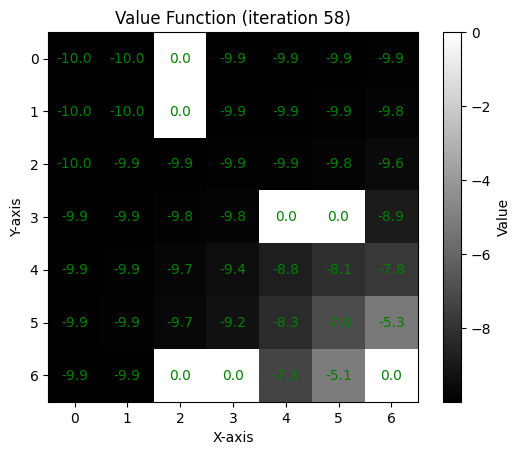

action = 0 V[0, 0] = -1 + 0.9 * -9.979374977358084 = -9.981437479622276
action = 1 V[0, 0] = -1 + 0.9 * -9.971775680733462 = -9.974598112660116
action = 2 V[0, 0] = -1 + 0.9 * -9.979374977358084 = -9.981437479622276
action = 3 V[0, 0] = -1 + 0.9 * -9.978318605640599 = -9.98048674507654
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978318605640599 = -9.98048674507654
action = 1 V[0, 1] = -1 + 0.9 * -9.96797766162583 = -9.971179895463248
action = 2 V[0, 1] = -1 + 0.9 * -9.979374977358084 = -9.981437479622276
action = 3 V[0, 1] = -1 + 0.9 * -9.978318605640599 = -9.98048674507654
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.938672391236476 = -9.94480515211283
action = 1 V[0, 3] = -1 + 0.9 * -9.921118082620081 = -9.929006274358073
action = 2 V[0, 3] = -1 + 0.9 * -9.938672391236476 = -9.94480515211283
action = 3 V[0, 3] = -1 + 0.9 * -9.92928684758006 = -9.936358162822055
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.92928684758006 = -9.936358162822055
action = 1 V[0, 4] = -1 

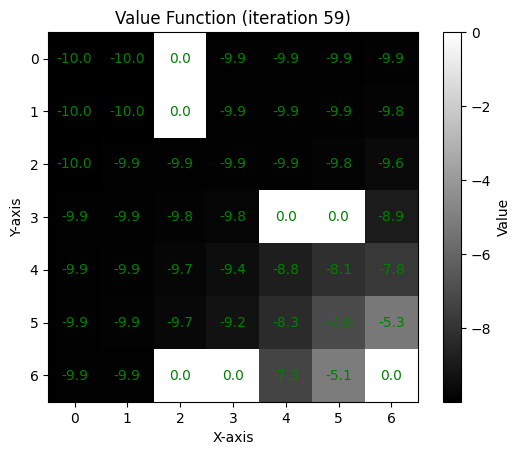

action = 0 V[0, 0] = -1 + 0.9 * -9.979489954245302 = -9.981540958820773
action = 1 V[0, 0] = -1 + 0.9 * -9.971870705245003 = -9.974683634720503
action = 2 V[0, 0] = -1 + 0.9 * -9.979489954245302 = -9.981540958820773
action = 3 V[0, 0] = -1 + 0.9 * -9.978423586109276 = -9.980581227498348
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978423586109276 = -9.980581227498348
action = 1 V[0, 1] = -1 + 0.9 * -9.968063511596283 = -9.971257160436654
action = 2 V[0, 1] = -1 + 0.9 * -9.979489954245302 = -9.981540958820773
action = 3 V[0, 1] = -1 + 0.9 * -9.978423586109276 = -9.980581227498348
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.938743685351445 = -9.944869316816302
action = 1 V[0, 3] = -1 + 0.9 * -9.921178305062766 = -9.92906047455649
action = 2 V[0, 3] = -1 + 0.9 * -9.938743685351445 = -9.944869316816302
action = 3 V[0, 3] = -1 + 0.9 * -9.929349679305902 = -9.936414711375312
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929349679305902 = -9.936414711375312
action = 1 V[0, 4

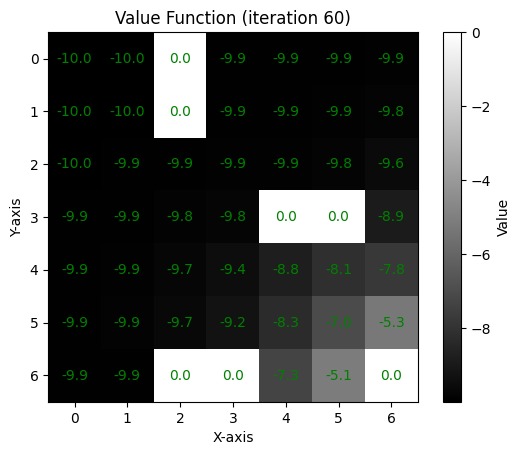

action = 0 V[0, 0] = -1 + 0.9 * -9.9795866949651 = -9.98162802546859
action = 1 V[0, 0] = -1 + 0.9 * -9.971950629875648 = -9.974755566888083
action = 2 V[0, 0] = -1 + 0.9 * -9.9795866949651 = -9.98162802546859
action = 3 V[0, 0] = -1 + 0.9 * -9.978511910225485 = -9.980660719202938
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978511910225485 = -9.980660719202938
action = 1 V[0, 1] = -1 + 0.9 * -9.968135712843772 = -9.971322141559394
action = 2 V[0, 1] = -1 + 0.9 * -9.9795866949651 = -9.98162802546859
action = 3 V[0, 1] = -1 + 0.9 * -9.978511910225485 = -9.980660719202938
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.9388034548911 = -9.94492310940199
action = 1 V[0, 3] = -1 + 0.9 * -9.921228803345347 = -9.929105923010813
action = 2 V[0, 3] = -1 + 0.9 * -9.9388034548911 = -9.94492310940199
action = 3 V[0, 3] = -1 + 0.9 * -9.929402349548946 = -9.936462114594052
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929402349548946 = -9.936462114594052
action = 1 V[0, 4] = -1 + 0.9 *

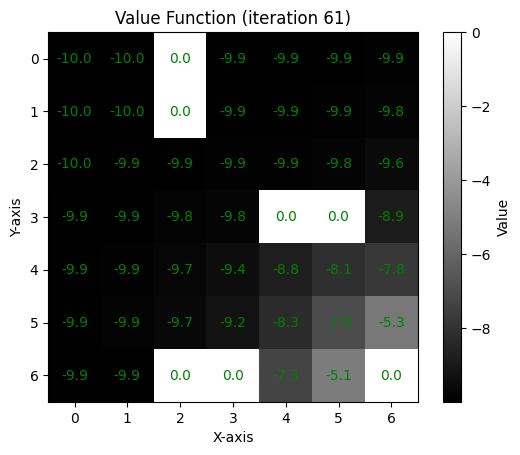

action = 0 V[0, 0] = -1 + 0.9 * -9.97966808425705 = -9.981701275831345
action = 1 V[0, 0] = -1 + 0.9 * -9.972017848946926 = -9.974816064052234
action = 2 V[0, 0] = -1 + 0.9 * -9.97966808425705 = -9.981701275831345
action = 3 V[0, 0] = -1 + 0.9 * -9.978586213949153 = -9.980727592554238
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978586213949153 = -9.980727592554238
action = 1 V[0, 1] = -1 + 0.9 * -9.968196430891558 = -9.971376787802402
action = 2 V[0, 1] = -1 + 0.9 * -9.97966808425705 = -9.981701275831345
action = 3 V[0, 1] = -1 + 0.9 * -9.978586213949153 = -9.980727592554238
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.938853564102212 = -9.944968207691991
action = 1 V[0, 3] = -1 + 0.9 * -9.921271148644733 = -9.92914403378026
action = 2 V[0, 3] = -1 + 0.9 * -9.938853564102212 = -9.944968207691991
action = 3 V[0, 3] = -1 + 0.9 * -9.929446502963007 = -9.936501852666707
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929446502963007 = -9.936501852666707
action = 1 V[0, 4] =

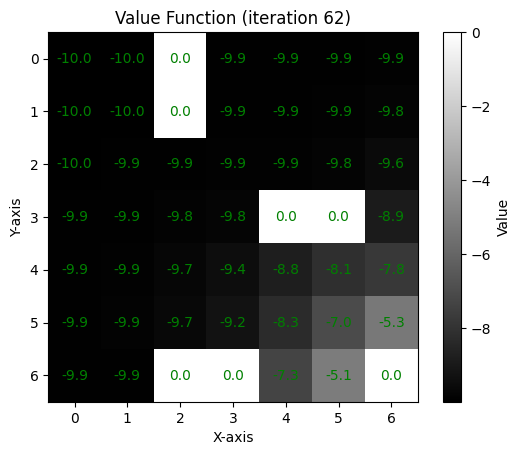

action = 0 V[0, 0] = -1 + 0.9 * -9.97973655206729 = -9.981762896860563
action = 1 V[0, 0] = -1 + 0.9 * -9.972074378146901 = -9.97486694033221
action = 2 V[0, 0] = -1 + 0.9 * -9.97973655206729 = -9.981762896860563
action = 3 V[0, 0] = -1 + 0.9 * -9.97864871744286 = -9.980783845698575
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.97864871744286 = -9.980783845698575
action = 1 V[0, 1] = -1 + 0.9 * -9.96824748855581 = -9.97142273970023
action = 2 V[0, 1] = -1 + 0.9 * -9.97973655206729 = -9.981762896860563
action = 3 V[0, 1] = -1 + 0.9 * -9.97864871744286 = -9.980783845698575
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.938895575457737 = -9.945006017911963
action = 1 V[0, 3] = -1 + 0.9 * -9.921306658109883 = -9.929175992298894
action = 2 V[0, 3] = -1 + 0.9 * -9.938895575457737 = -9.945006017911963
action = 3 V[0, 3] = -1 + 0.9 * -9.929483517803565 = -9.936535166023209
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929483517803565 = -9.936535166023209
action = 1 V[0, 4] = -1 +

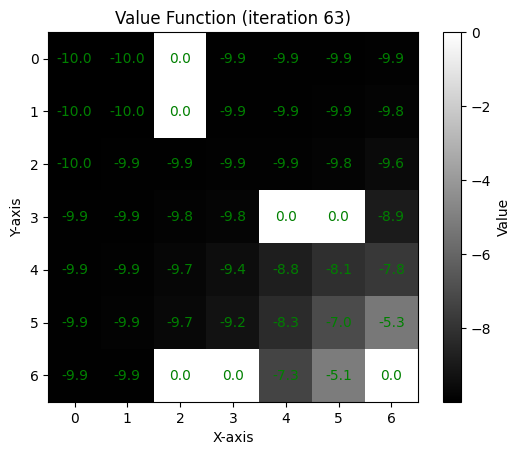

action = 0 V[0, 0] = -1 + 0.9 * -9.979794144937976 = -9.98181473044418
action = 1 V[0, 0] = -1 + 0.9 * -9.972121914200896 = -9.974909722780806
action = 2 V[0, 0] = -1 + 0.9 * -9.979794144937976 = -9.98181473044418
action = 3 V[0, 0] = -1 + 0.9 * -9.97870129038539 = -9.98083116134685
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.97870129038539 = -9.98083116134685
action = 1 V[0, 1] = -1 + 0.9 * -9.968290420004886 = -9.971461378004397
action = 2 V[0, 1] = -1 + 0.9 * -9.979794144937976 = -9.98181473044418
action = 3 V[0, 1] = -1 + 0.9 * -9.97870129038539 = -9.98083116134685
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.938930798536507 = -9.945037718682856
action = 1 V[0, 3] = -1 + 0.9 * -9.921336435958864 = -9.929202792362977
action = 2 V[0, 3] = -1 + 0.9 * -9.938930798536507 = -9.945037718682856
action = 3 V[0, 3] = -1 + 0.9 * -9.929514549110337 = -9.936563094199304
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929514549110337 = -9.936563094199304
action = 1 V[0, 4] = -1 +

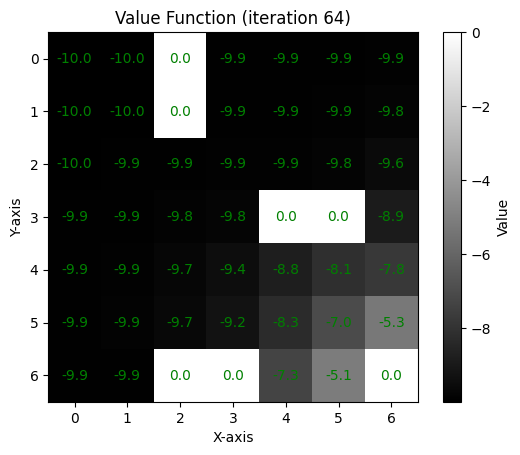

action = 0 V[0, 0] = -1 + 0.9 * -9.979842586254003 = -9.981858327628602
action = 1 V[0, 0] = -1 + 0.9 * -9.972161885180004 = -9.974945696662004
action = 2 V[0, 0] = -1 + 0.9 * -9.979842586254003 = -9.981858327628602
action = 3 V[0, 0] = -1 + 0.9 * -9.978745507081674 = -9.980870956373508
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978745507081674 = -9.980870956373508
action = 1 V[0, 1] = -1 + 0.9 * -9.968326516326774 = -9.971493864694096
action = 2 V[0, 1] = -1 + 0.9 * -9.979842586254003 = -9.981858327628602
action = 3 V[0, 1] = -1 + 0.9 * -9.978745507081674 = -9.980870956373508
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.938960330981999 = -9.9450642978838
action = 1 V[0, 3] = -1 + 0.9 * -9.921361407923516 = -9.929225267131166
action = 2 V[0, 3] = -1 + 0.9 * -9.938960330981999 = -9.9450642978838
action = 3 V[0, 3] = -1 + 0.9 * -9.92954056488572 = -9.936586508397149
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.92954056488572 = -9.936586508397149
action = 1 V[0, 4] = -

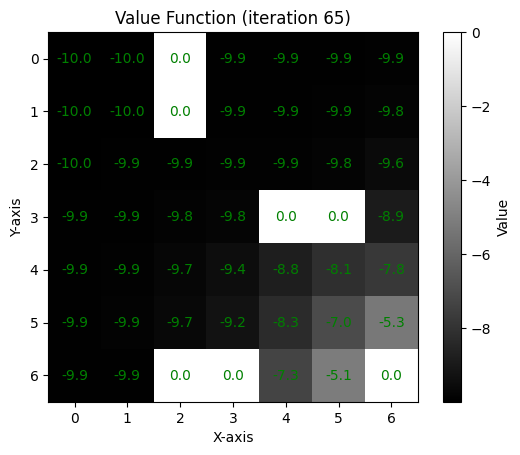

action = 0 V[0, 0] = -1 + 0.9 * -9.979883327073178 = -9.981894994365861
action = 1 V[0, 0] = -1 + 0.9 * -9.972195492907831 = -9.974975943617048
action = 2 V[0, 0] = -1 + 0.9 * -9.979883327073178 = -9.981894994365861
action = 3 V[0, 0] = -1 + 0.9 * -9.978782692951743 = -9.980904423656568
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978782692951743 = -9.980904423656568
action = 1 V[0, 1] = -1 + 0.9 * -9.968356863931444 = -9.9715211775383
action = 2 V[0, 1] = -1 + 0.9 * -9.979883327073178 = -9.981894994365861
action = 3 V[0, 1] = -1 + 0.9 * -9.978782692951743 = -9.980904423656568
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.938985092823978 = -9.945086583541581
action = 1 V[0, 3] = -1 + 0.9 * -9.921382350118957 = -9.929244115107062
action = 2 V[0, 3] = -1 + 0.9 * -9.938985092823978 = -9.945086583541581
action = 3 V[0, 3] = -1 + 0.9 * -9.929562376405602 = -9.936606138765043
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929562376405602 = -9.936606138765043
action = 1 V[0, 4]

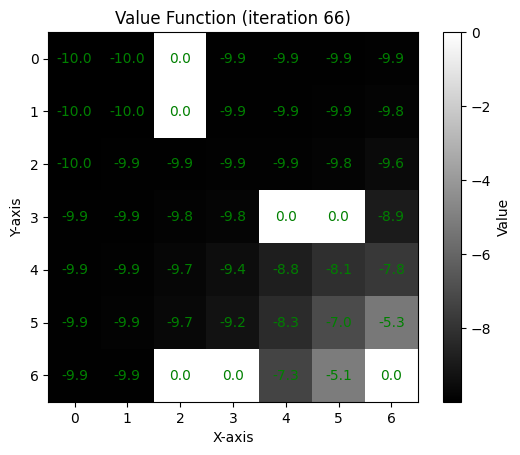

action = 0 V[0, 0] = -1 + 0.9 * -9.979917589001335 = -9.981925830101202
action = 1 V[0, 0] = -1 + 0.9 * -9.972223748699838 = -9.975001373829855
action = 2 V[0, 0] = -1 + 0.9 * -9.979917589001335 = -9.981925830101202
action = 3 V[0, 0] = -1 + 0.9 * -9.97881396373816 = -9.980932567364345
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.97881396373816 = -9.980932567364345
action = 1 V[0, 1] = -1 + 0.9 * -9.968382376908934 = -9.971544139218041
action = 2 V[0, 1] = -1 + 0.9 * -9.979917589001335 = -9.981925830101202
action = 3 V[0, 1] = -1 + 0.9 * -9.97881396373816 = -9.980932567364345
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.939005855238817 = -9.945105269714935
action = 1 V[0, 3] = -1 + 0.9 * -9.921399913240709 = -9.929259921916639
action = 2 V[0, 3] = -1 + 0.9 * -9.939005855238817 = -9.945105269714935
action = 3 V[0, 3] = -1 + 0.9 * -9.92958066361464 = -9.936622597253177
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.92958066361464 = -9.936622597253177
action = 1 V[0, 4] = 

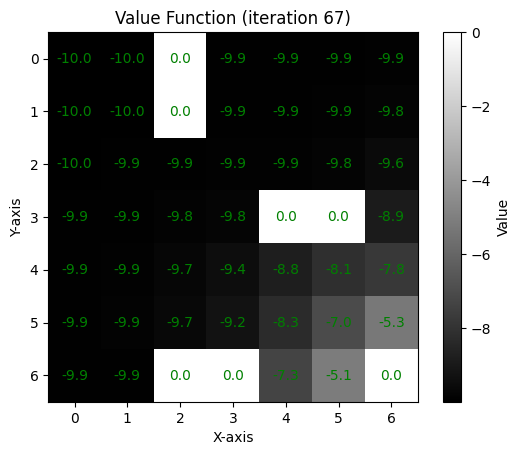

action = 0 V[0, 0] = -1 + 0.9 * -9.979946400349153 = -9.981951760314239
action = 1 V[0, 0] = -1 + 0.9 * -9.972247503478176 = -9.975022753130359
action = 2 V[0, 0] = -1 + 0.9 * -9.979946400349153 = -9.981951760314239
action = 3 V[0, 0] = -1 + 0.9 * -9.978840258565242 = -9.980956232708719
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978840258565242 = -9.980956232708719
action = 1 V[0, 1] = -1 + 0.9 * -9.968403824289933 = -9.97156344186094
action = 2 V[0, 1] = -1 + 0.9 * -9.979946400349153 = -9.981951760314239
action = 3 V[0, 1] = -1 + 0.9 * -9.978840258565242 = -9.980956232708719
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.939023264649922 = -9.94512093818493
action = 1 V[0, 3] = -1 + 0.9 * -9.921414642846017 = -9.929273178561415
action = 2 V[0, 3] = -1 + 0.9 * -9.939023264649922 = -9.94512093818493
action = 3 V[0, 3] = -1 + 0.9 * -9.929595996403553 = -9.936636396763198
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929595996403553 = -9.936636396763198
action = 1 V[0, 4] 

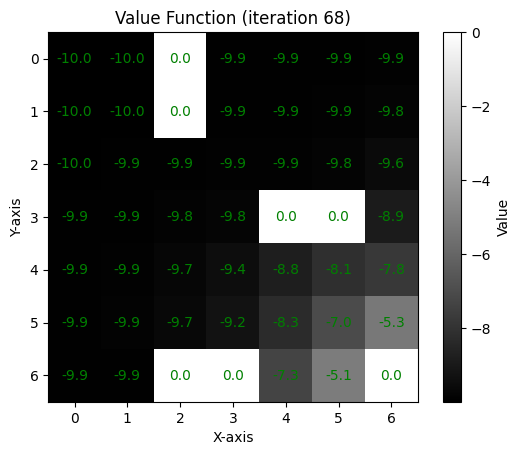

action = 0 V[0, 0] = -1 + 0.9 * -9.97997062661689 = -9.9819735639552
action = 1 V[0, 0] = -1 + 0.9 * -9.97226747314291 = -9.97504072582862
action = 2 V[0, 0] = -1 + 0.9 * -9.97997062661689 = -9.9819735639552
action = 3 V[0, 0] = -1 + 0.9 * -9.978862367808395 = -9.980976131027555
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978862367808395 = -9.980976131027555
action = 1 V[0, 1] = -1 + 0.9 * -9.96842185300823 = -9.971579667707408
action = 2 V[0, 1] = -1 + 0.9 * -9.97997062661689 = -9.9819735639552
action = 3 V[0, 1] = -1 + 0.9 * -9.978862367808395 = -9.980976131027555
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.939037862923618 = -9.945134076631255
action = 1 V[0, 3] = -1 + 0.9 * -9.921426996353388 = -9.929284296718048
action = 2 V[0, 3] = -1 + 0.9 * -9.939037862923618 = -9.945134076631255
action = 3 V[0, 3] = -1 + 0.9 * -9.929608852436624 = -9.936647967192963
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929608852436624 = -9.936647967192963
action = 1 V[0, 4] = -1 + 0.

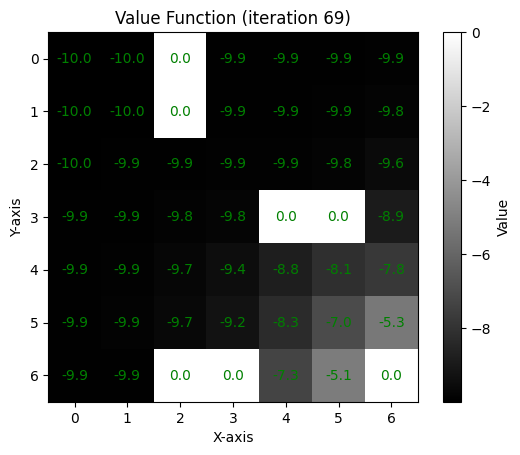

action = 0 V[0, 0] = -1 + 0.9 * -9.979990996191644 = -9.98199189657248
action = 1 V[0, 0] = -1 + 0.9 * -9.972284259943432 = -9.975055833949089
action = 2 V[0, 0] = -1 + 0.9 * -9.979990996191644 = -9.98199189657248
action = 3 V[0, 0] = -1 + 0.9 * -9.97888095658375 = -9.980992860925374
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.97888095658375 = -9.980992860925374
action = 1 V[0, 1] = -1 + 0.9 * -9.968437007239798 = -9.971593306515818
action = 2 V[0, 1] = -1 + 0.9 * -9.979990996191644 = -9.98199189657248
action = 3 V[0, 1] = -1 + 0.9 * -9.97888095658375 = -9.980992860925374
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.939050104293381 = -9.945145093864044
action = 1 V[0, 3] = -1 + 0.9 * -9.921437357291696 = -9.929293621562527
action = 2 V[0, 3] = -1 + 0.9 * -9.939050104293381 = -9.945145093864044
action = 3 V[0, 3] = -1 + 0.9 * -9.929619632089072 = -9.936657668880164
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929619632089072 = -9.936657668880164
action = 1 V[0, 4] = -

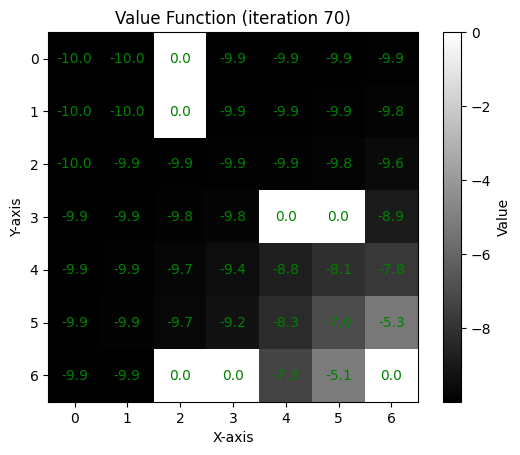

action = 0 V[0, 0] = -1 + 0.9 * -9.980008122004856 = -9.98200730980437
action = 1 V[0, 0] = -1 + 0.9 * -9.972298370477912 = -9.975068533430122
action = 2 V[0, 0] = -1 + 0.9 * -9.980008122004856 = -9.98200730980437
action = 3 V[0, 0] = -1 + 0.9 * -9.978896584542733 = -9.98100692608846
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978896584542733 = -9.98100692608846
action = 1 V[0, 1] = -1 + 0.9 * -9.968449744687913 = -9.971604770219122
action = 2 V[0, 1] = -1 + 0.9 * -9.980008122004856 = -9.98200730980437
action = 3 V[0, 1] = -1 + 0.9 * -9.978896584542733 = -9.98100692608846
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.939060369542695 = -9.945154332588425
action = 1 V[0, 3] = -1 + 0.9 * -9.921446047244117 = -9.929301442519707
action = 2 V[0, 3] = -1 + 0.9 * -9.939060369542695 = -9.945154332588425
action = 3 V[0, 3] = -1 + 0.9 * -9.929628670963156 = -9.936665803866841
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929628670963156 = -9.936665803866841
action = 1 V[0, 4] = -

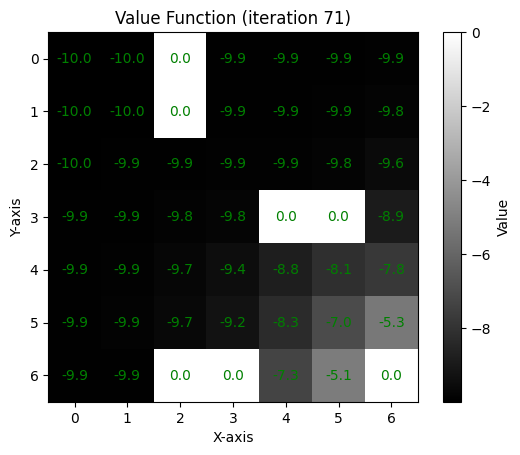

action = 0 V[0, 0] = -1 + 0.9 * -9.98002251978183 = -9.982020267803648
action = 1 V[0, 0] = -1 + 0.9 * -9.972310230850658 = -9.975079207765592
action = 2 V[0, 0] = -1 + 0.9 * -9.98002251978183 = -9.982020267803648
action = 3 V[0, 0] = -1 + 0.9 * -9.978909722549922 = -9.98101875029493
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978909722549922 = -9.98101875029493
action = 1 V[0, 1] = -1 + 0.9 * -9.968460450294765 = -9.971614405265289
action = 2 V[0, 1] = -1 + 0.9 * -9.98002251978183 = -9.982020267803648
action = 3 V[0, 1] = -1 + 0.9 * -9.978909722549922 = -9.98101875029493
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.939068977890848 = -9.945162080101763
action = 1 V[0, 3] = -1 + 0.9 * -9.921453335860065 = -9.929308002274059
action = 2 V[0, 3] = -1 + 0.9 * -9.939068977890848 = -9.945162080101763
action = 3 V[0, 3] = -1 + 0.9 * -9.929636250375802 = -9.936672625338222
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929636250375802 = -9.936672625338222
action = 1 V[0, 4] = -

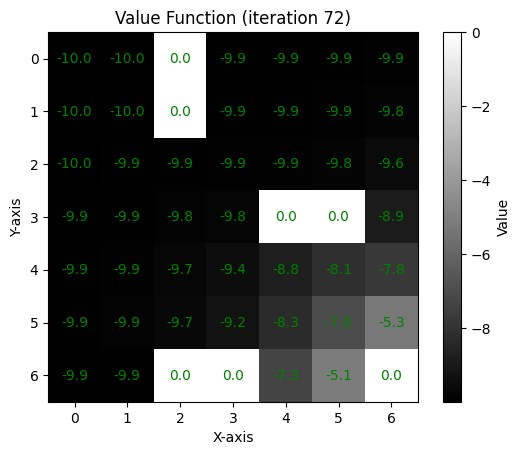

action = 0 V[0, 0] = -1 + 0.9 * -9.980034623416955 = -9.98203116107526
action = 1 V[0, 0] = -1 + 0.9 * -9.972320199434405 = -9.975088179490964
action = 2 V[0, 0] = -1 + 0.9 * -9.980034623416955 = -9.98203116107526
action = 3 V[0, 0] = -1 + 0.9 * -9.978920766732603 = -9.981028690059343
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978920766732603 = -9.981028690059343
action = 1 V[0, 1] = -1 + 0.9 * -9.968469447784738 = -9.971622503006264
action = 2 V[0, 1] = -1 + 0.9 * -9.980034623416955 = -9.98203116107526
action = 3 V[0, 1] = -1 + 0.9 * -9.978920766732603 = -9.981028690059343
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.939076196953952 = -9.945168577258556
action = 1 V[0, 3] = -1 + 0.9 * -9.921459449247834 = -9.929313504323051
action = 2 V[0, 3] = -1 + 0.9 * -9.939076196953952 = -9.945168577258556
action = 3 V[0, 3] = -1 + 0.9 * -9.929642606146716 = -9.936678345532044
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929642606146716 = -9.936678345532044
action = 1 V[0, 4] 

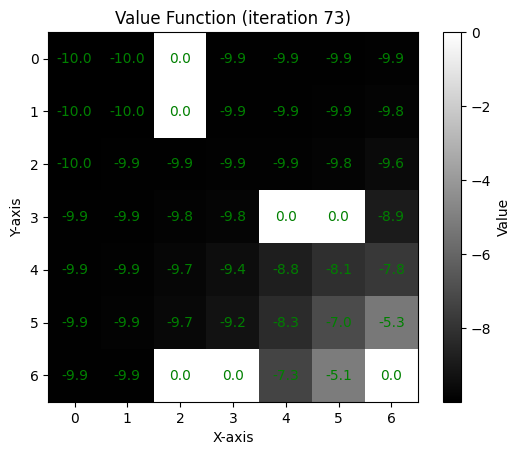

action = 0 V[0, 0] = -1 + 0.9 * -9.980044797925206 = -9.982040318132686
action = 1 V[0, 0] = -1 + 0.9 * -9.97232857761464 = -9.975095719853176
action = 2 V[0, 0] = -1 + 0.9 * -9.980044797925206 = -9.982040318132686
action = 3 V[0, 0] = -1 + 0.9 * -9.978930050314409 = -9.981037045282967
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978930050314409 = -9.981037045282967
action = 1 V[0, 1] = -1 + 0.9 * -9.968477009381083 = -9.971629308442974
action = 2 V[0, 1] = -1 + 0.9 * -9.980044797925206 = -9.982040318132686
action = 3 V[0, 1] = -1 + 0.9 * -9.978930050314409 = -9.981037045282967
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.939082251093051 = -9.945174025983746
action = 1 V[0, 3] = -1 + 0.9 * -9.921464577010024 = -9.929318119309022
action = 2 V[0, 3] = -1 + 0.9 * -9.939082251093051 = -9.945174025983746
action = 3 V[0, 3] = -1 + 0.9 * -9.929647935962644 = -9.936683142366379
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929647935962644 = -9.936683142366379
action = 1 V[0, 4

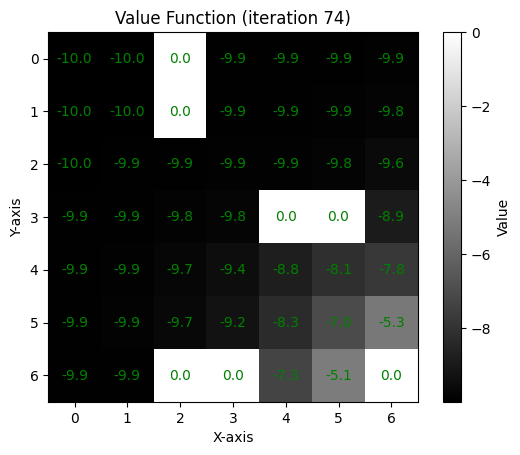

action = 0 V[0, 0] = -1 + 0.9 * -9.980053350350378 = -9.98204801531534
action = 1 V[0, 0] = -1 + 0.9 * -9.9723356188339 = -9.975102056950512
action = 2 V[0, 0] = -1 + 0.9 * -9.980053350350378 = -9.98204801531534
action = 3 V[0, 0] = -1 + 0.9 * -9.978937853581062 = -9.981044068222957
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978937853581062 = -9.981044068222957
action = 1 V[0, 1] = -1 + 0.9 * -9.968483363984102 = -9.971635027585693
action = 2 V[0, 1] = -1 + 0.9 * -9.980053350350378 = -9.98204801531534
action = 3 V[0, 1] = -1 + 0.9 * -9.978937853581062 = -9.981044068222957
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.939087328410723 = -9.94517859556965
action = 1 V[0, 3] = -1 + 0.9 * -9.921468878141386 = -9.929321990327248
action = 2 V[0, 3] = -1 + 0.9 * -9.939087328410723 = -9.94517859556965
action = 3 V[0, 3] = -1 + 0.9 * -9.929652405548621 = -9.93668716499376
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929652405548621 = -9.93668716499376
action = 1 V[0, 4] = -1 +

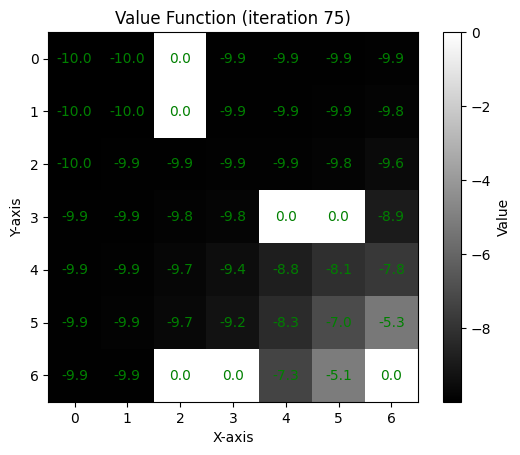

action = 0 V[0, 0] = -1 + 0.9 * -9.980060538951038 = -9.982054485055935
action = 1 V[0, 0] = -1 + 0.9 * -9.972341536204205 = -9.975107382583785
action = 2 V[0, 0] = -1 + 0.9 * -9.980060538951038 = -9.982054485055935
action = 3 V[0, 0] = -1 + 0.9 * -9.978944412271884 = -9.981049971044696
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978944412271884 = -9.981049971044696
action = 1 V[0, 1] = -1 + 0.9 * -9.968488704053659 = -9.971639833648293
action = 2 V[0, 1] = -1 + 0.9 * -9.980060538951038 = -9.982054485055935
action = 3 V[0, 1] = -1 + 0.9 * -9.978944412271884 = -9.981049971044696
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.939091586615078 = -9.94518242795357
action = 1 V[0, 3] = -1 + 0.9 * -9.921472485973146 = -9.929325237375831
action = 2 V[0, 3] = -1 + 0.9 * -9.939091586615078 = -9.94518242795357
action = 3 V[0, 3] = -1 + 0.9 * -9.929656153839677 = -9.936690538455709
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929656153839677 = -9.936690538455709
action = 1 V[0, 4]

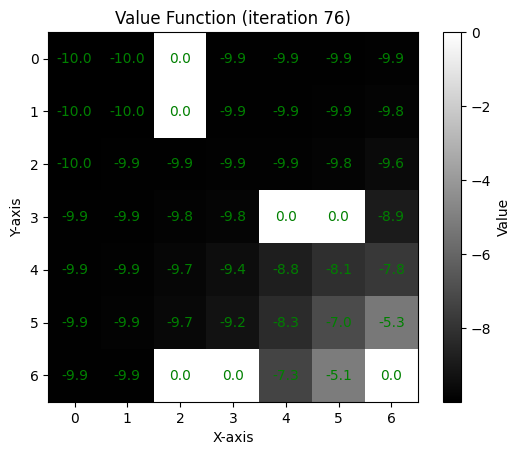

action = 0 V[0, 0] = -1 + 0.9 * -9.980066580935087 = -9.982059922841579
action = 1 V[0, 0] = -1 + 0.9 * -9.97234650891355 = -9.975111858022196
action = 2 V[0, 0] = -1 + 0.9 * -9.980066580935087 = -9.982059922841579
action = 3 V[0, 0] = -1 + 0.9 * -9.978949924644816 = -9.981054932180335
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978949924644816 = -9.981054932180335
action = 1 V[0, 1] = -1 + 0.9 * -9.968493191400702 = -9.971643872260632
action = 2 V[0, 1] = -1 + 0.9 * -9.980066580935087 = -9.982059922841579
action = 3 V[0, 1] = -1 + 0.9 * -9.978949924644816 = -9.981054932180335
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.93909515793467 = -9.945185642141203
action = 1 V[0, 3] = -1 + 0.9 * -9.921475512318088 = -9.92932796108628
action = 2 V[0, 3] = -1 + 0.9 * -9.93909515793467 = -9.945185642141203
action = 3 V[0, 3] = -1 + 0.9 * -9.929659297314986 = -9.936693367583487
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929659297314986 = -9.936693367583487
action = 1 V[0, 4] =

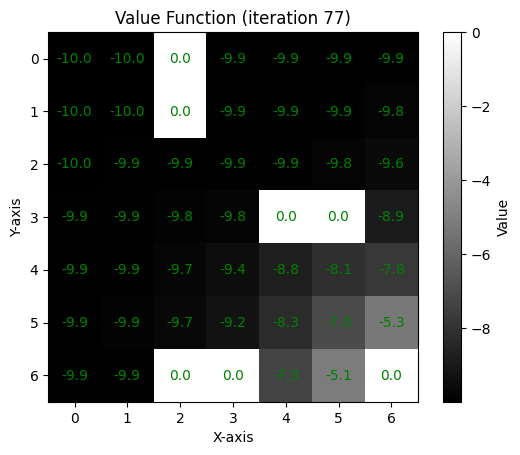

action = 0 V[0, 0] = -1 + 0.9 * -9.980071658971422 = -9.98206449307428
action = 1 V[0, 0] = -1 + 0.9 * -9.972350687617002 = -9.975115618855302
action = 2 V[0, 0] = -1 + 0.9 * -9.980071658971422 = -9.98206449307428
action = 3 V[0, 0] = -1 + 0.9 * -9.978954557423895 = -9.981059101681506
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978954557423895 = -9.981059101681506
action = 1 V[0, 1] = -1 + 0.9 * -9.968496962060271 = -9.971647265854244
action = 2 V[0, 1] = -1 + 0.9 * -9.980071658971422 = -9.98206449307428
action = 3 V[0, 1] = -1 + 0.9 * -9.978954557423895 = -9.981059101681506
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.939098153238044 = -9.94518833791424
action = 1 V[0, 3] = -1 + 0.9 * -9.921478050945673 = -9.929330245851107
action = 2 V[0, 3] = -1 + 0.9 * -9.939098153238044 = -9.94518833791424
action = 3 V[0, 3] = -1 + 0.9 * -9.929661933630259 = -9.936695740267233
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929661933630259 = -9.936695740267233
action = 1 V[0, 4] = 

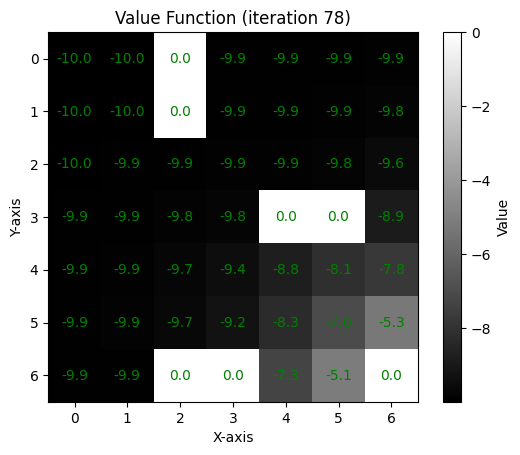

action = 0 V[0, 0] = -1 + 0.9 * -9.980075926671342 = -9.982068334004207
action = 1 V[0, 0] = -1 + 0.9 * -9.972354198972848 = -9.975118779075563
action = 2 V[0, 0] = -1 + 0.9 * -9.980075926671342 = -9.982068334004207
action = 3 V[0, 0] = -1 + 0.9 * -9.978958450805365 = -9.981062605724828
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978958450805365 = -9.981062605724828
action = 1 V[0, 1] = -1 + 0.9 * -9.968500130391257 = -9.971650117352132
action = 2 V[0, 1] = -1 + 0.9 * -9.980075926671342 = -9.982068334004207
action = 3 V[0, 1] = -1 + 0.9 * -9.978958450805365 = -9.981062605724828
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.939100665486706 = -9.945190598938035
action = 1 V[0, 3] = -1 + 0.9 * -9.921480180495557 = -9.929332162446002
action = 2 V[0, 3] = -1 + 0.9 * -9.939100665486706 = -9.945190598938035
action = 3 V[0, 3] = -1 + 0.9 * -9.929664144662064 = -9.936697730195858
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929664144662064 = -9.936697730195858
action = 1 V[0, 

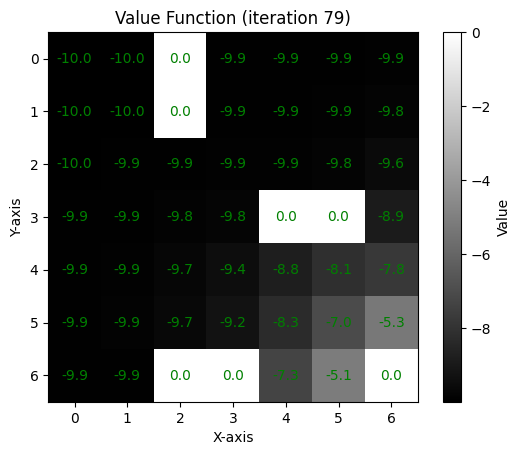

action = 0 V[0, 0] = -1 + 0.9 * -9.9800795132022 = -9.98207156188198
action = 1 V[0, 0] = -1 + 0.9 * -9.972357149459024 = -9.975121434513122
action = 2 V[0, 0] = -1 + 0.9 * -9.9800795132022 = -9.98207156188198
action = 3 V[0, 0] = -1 + 0.9 * -9.978961722670942 = -9.981065550403848
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978961722670942 = -9.981065550403848
action = 1 V[0, 1] = -1 + 0.9 * -9.968502792525314 = -9.971652513272783
action = 2 V[0, 1] = -1 + 0.9 * -9.9800795132022 = -9.98207156188198
action = 3 V[0, 1] = -1 + 0.9 * -9.978961722670942 = -9.981065550403848
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.939102772629482 = -9.945192495366534
action = 1 V[0, 3] = -1 + 0.9 * -9.921481966920325 = -9.929333770228293
action = 2 V[0, 3] = -1 + 0.9 * -9.939102772629482 = -9.945192495366534
action = 3 V[0, 3] = -1 + 0.9 * -9.929665999059388 = -9.936699399153449
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929665999059388 = -9.936699399153449
action = 1 V[0, 4] = -1 +

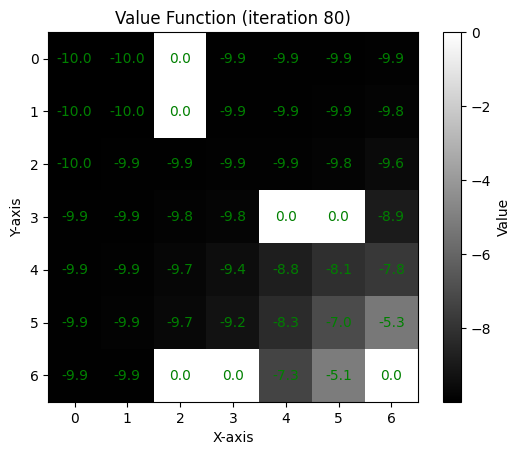

action = 0 V[0, 0] = -1 + 0.9 * -9.980082527170232 = -9.98207427445321
action = 1 V[0, 0] = -1 + 0.9 * -9.972359628583732 = -9.97512366572536
action = 2 V[0, 0] = -1 + 0.9 * -9.980082527170232 = -9.98207427445321
action = 3 V[0, 0] = -1 + 0.9 * -9.978964472133422 = -9.981068024920079
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978964472133422 = -9.981068024920079
action = 1 V[0, 1] = -1 + 0.9 * -9.968505029268002 = -9.971654526341203
action = 2 V[0, 1] = -1 + 0.9 * -9.980082527170232 = -9.98207427445321
action = 3 V[0, 1] = -1 + 0.9 * -9.978964472133422 = -9.981068024920079
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.939104540028703 = -9.945194086025833
action = 1 V[0, 3] = -1 + 0.9 * -9.921483465533596 = -9.929335118980237
action = 2 V[0, 3] = -1 + 0.9 * -9.939104540028703 = -9.945194086025833
action = 3 V[0, 3] = -1 + 0.9 * -9.929667554382252 = -9.936700798944027
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929667554382252 = -9.936700798944027
action = 1 V[0, 4] =

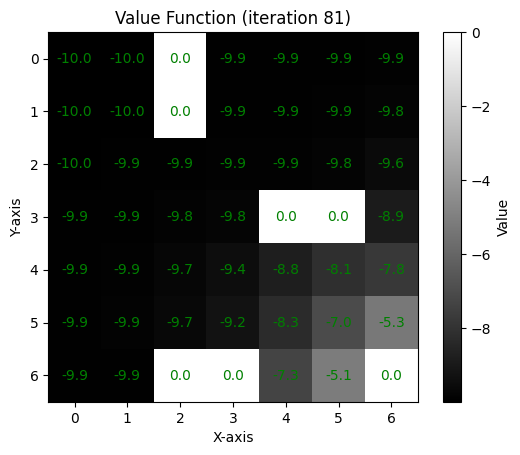

action = 0 V[0, 0] = -1 + 0.9 * -9.980085059887964 = -9.982076553899168
action = 1 V[0, 0] = -1 + 0.9 * -9.972361711586212 = -9.975125540427591
action = 2 V[0, 0] = -1 + 0.9 * -9.980085059887964 = -9.982076553899168
action = 3 V[0, 0] = -1 + 0.9 * -9.978966782520132 = -9.981070104268118
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978966782520132 = -9.981070104268118
action = 1 V[0, 1] = -1 + 0.9 * -9.968506908538965 = -9.971656217685068
action = 2 V[0, 1] = -1 + 0.9 * -9.980085059887964 = -9.982076553899168
action = 3 V[0, 1] = -1 + 0.9 * -9.978966782520132 = -9.981070104268118
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.939106022493982 = -9.945195420244584
action = 1 V[0, 3] = -1 + 0.9 * -9.921484722727257 = -9.929336250454531
action = 2 V[0, 3] = -1 + 0.9 * -9.939106022493982 = -9.945195420244584
action = 3 V[0, 3] = -1 + 0.9 * -9.929668858894281 = -9.936701973004853
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929668858894281 = -9.936701973004853
action = 1 V[0, 

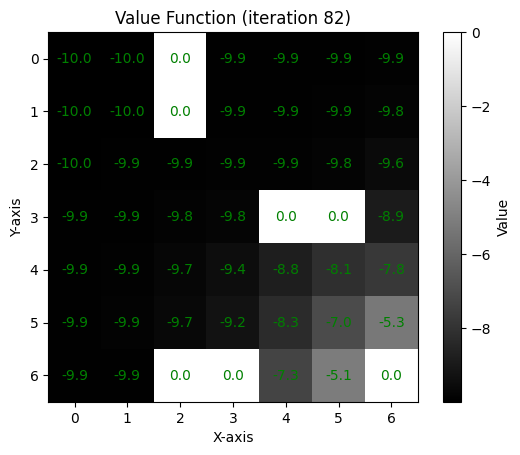

action = 0 V[0, 0] = -1 + 0.9 * -9.980087188123512 = -9.982078469311162
action = 1 V[0, 0] = -1 + 0.9 * -9.972363461708385 = -9.975127115537546
action = 2 V[0, 0] = -1 + 0.9 * -9.980087188123512 = -9.982078469311162
action = 3 V[0, 0] = -1 + 0.9 * -9.978968723883117 = -9.981071851494805
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978968723883117 = -9.981071851494805
action = 1 V[0, 1] = -1 + 0.9 * -9.968508487424229 = -9.971657638681807
action = 2 V[0, 1] = -1 + 0.9 * -9.980087188123512 = -9.982078469311162
action = 3 V[0, 1] = -1 + 0.9 * -9.978968723883117 = -9.981071851494805
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.939107265987138 = -9.945196539388425
action = 1 V[0, 3] = -1 + 0.9 * -9.921485777411355 = -9.92933719967022
action = 2 V[0, 3] = -1 + 0.9 * -9.939107265987138 = -9.945196539388425
action = 3 V[0, 3] = -1 + 0.9 * -9.929669953065265 = -9.936702957758738
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929669953065265 = -9.936702957758738
action = 1 V[0, 4

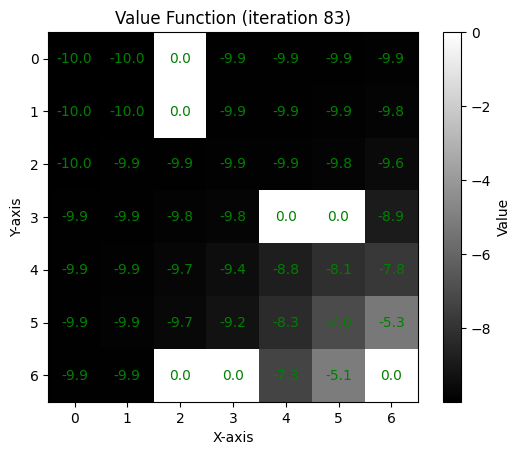

action = 0 V[0, 0] = -1 + 0.9 * -9.980088976413668 = -9.982080078772302
action = 1 V[0, 0] = -1 + 0.9 * -9.972364932105473 = -9.975128438894926
action = 2 V[0, 0] = -1 + 0.9 * -9.980088976413668 = -9.982080078772302
action = 3 V[0, 0] = -1 + 0.9 * -9.97897035511093 = -9.981073319599837
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.97897035511093 = -9.981073319599837
action = 1 V[0, 1] = -1 + 0.9 * -9.968509813902143 = -9.97165883251193
action = 2 V[0, 1] = -1 + 0.9 * -9.980088976413668 = -9.982080078772302
action = 3 V[0, 1] = -1 + 0.9 * -9.97897035511093 = -9.981073319599837
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.939108309051452 = -9.945197478146307
action = 1 V[0, 3] = -1 + 0.9 * -9.921486662221422 = -9.92933799599928
action = 2 V[0, 3] = -1 + 0.9 * -9.939108309051452 = -9.945197478146307
action = 3 V[0, 3] = -1 + 0.9 * -9.929670870830652 = -9.936703783747587
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929670870830652 = -9.936703783747587
action = 1 V[0, 4] = 

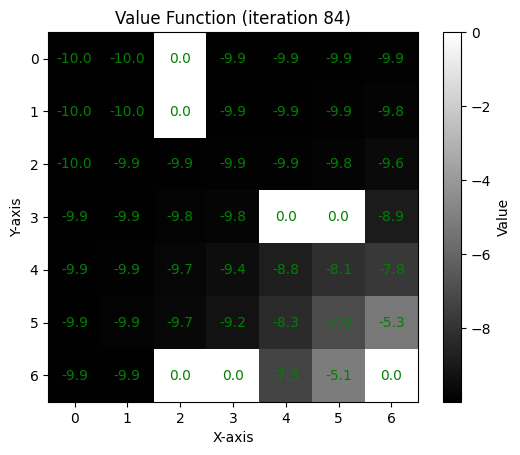

action = 0 V[0, 0] = -1 + 0.9 * -9.980090479009842 = -9.982081431108858
action = 1 V[0, 0] = -1 + 0.9 * -9.972366167452801 = -9.975129550707521
action = 2 V[0, 0] = -1 + 0.9 * -9.980090479009842 = -9.982081431108858
action = 3 V[0, 0] = -1 + 0.9 * -9.978971725705115 = -9.981074553134604
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978971725705115 = -9.981074553134604
action = 1 V[0, 1] = -1 + 0.9 * -9.968510928294766 = -9.971659835465289
action = 2 V[0, 1] = -1 + 0.9 * -9.980090479009842 = -9.982081431108858
action = 3 V[0, 1] = -1 + 0.9 * -9.978971725705115 = -9.981074553134604
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.93910918400987 = -9.945198265608884
action = 1 V[0, 3] = -1 + 0.9 * -9.921487404530886 = -9.929338664077799
action = 2 V[0, 3] = -1 + 0.9 * -9.93910918400987 = -9.945198265608884
action = 3 V[0, 3] = -1 + 0.9 * -9.929671640647378 = -9.93670447658264
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929671640647378 = -9.93670447658264
action = 1 V[0, 4] =

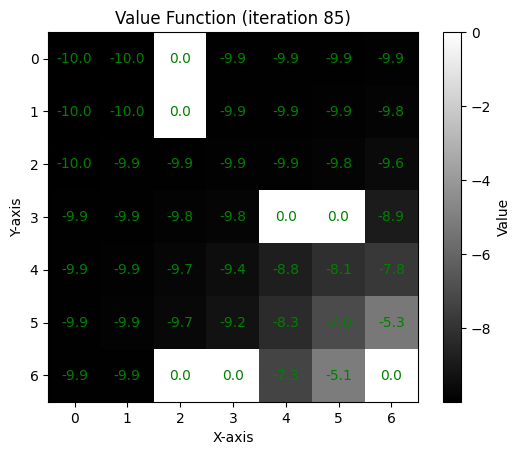

action = 0 V[0, 0] = -1 + 0.9 * -9.980091741514961 = -9.982082567363465
action = 1 V[0, 0] = -1 + 0.9 * -9.972367205297038 = -9.975130484767334
action = 2 V[0, 0] = -1 + 0.9 * -9.980091741514961 = -9.982082567363465
action = 3 V[0, 0] = -1 + 0.9 * -9.97897287727449 = -9.981075589547041
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.97897287727449 = -9.981075589547041
action = 1 V[0, 1] = -1 + 0.9 * -9.968511864488294 = -9.971660678039465
action = 2 V[0, 1] = -1 + 0.9 * -9.980091741514961 = -9.982082567363465
action = 3 V[0, 1] = -1 + 0.9 * -9.97897287727449 = -9.981075589547041
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.939109917969553 = -9.945198926172598
action = 1 V[0, 3] = -1 + 0.9 * -9.921488027300002 = -9.929339224570002
action = 2 V[0, 3] = -1 + 0.9 * -9.939109917969553 = -9.945198926172598
action = 3 V[0, 3] = -1 + 0.9 * -9.929672286378922 = -9.93670505774103
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929672286378922 = -9.93670505774103
action = 1 V[0, 4] = 

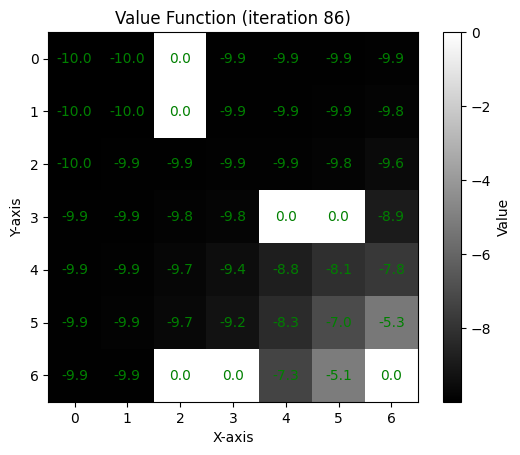

action = 0 V[0, 0] = -1 + 0.9 * -9.980092802260325 = -9.982083522034292
action = 1 V[0, 0] = -1 + 0.9 * -9.972368077192414 = -9.975131269473172
action = 2 V[0, 0] = -1 + 0.9 * -9.980092802260325 = -9.982083522034292
action = 3 V[0, 0] = -1 + 0.9 * -9.978973844791959 = -9.981076460312764
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978973844791959 = -9.981076460312764
action = 1 V[0, 1] = -1 + 0.9 * -9.968512650959212 = -9.97166138586329
action = 2 V[0, 1] = -1 + 0.9 * -9.980092802260325 = -9.982083522034292
action = 3 V[0, 1] = -1 + 0.9 * -9.978973844791959 = -9.981076460312764
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.939110533664056 = -9.945199480297651
action = 1 V[0, 3] = -1 + 0.9 * -9.921488549787744 = -9.92933969480897
action = 2 V[0, 3] = -1 + 0.9 * -9.939110533664056 = -9.945199480297651
action = 3 V[0, 3] = -1 + 0.9 * -9.929672828037297 = -9.936705545233568
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929672828037297 = -9.936705545233568
action = 1 V[0, 4]

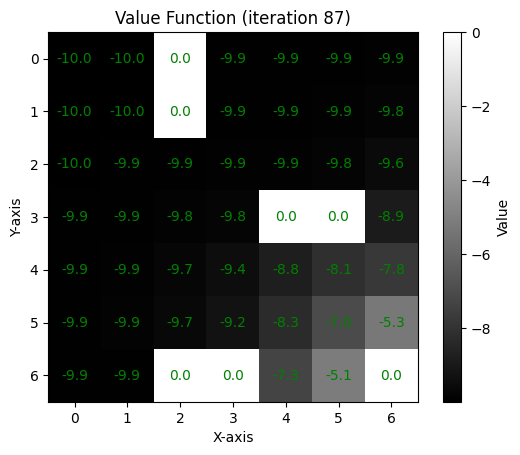

action = 0 V[0, 0] = -1 + 0.9 * -9.98009369346363 = -9.982084324117267
action = 1 V[0, 0] = -1 + 0.9 * -9.9723688096561 = -9.975131928690491
action = 2 V[0, 0] = -1 + 0.9 * -9.98009369346363 = -9.982084324117267
action = 3 V[0, 0] = -1 + 0.9 * -9.978974657651522 = -9.981077191886369
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978974657651522 = -9.981077191886369
action = 1 V[0, 1] = -1 + 0.9 * -9.968513311637047 = -9.971661980473343
action = 2 V[0, 1] = -1 + 0.9 * -9.98009369346363 = -9.982084324117267
action = 3 V[0, 1] = -1 + 0.9 * -9.978974657651522 = -9.981077191886369
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.939111050159461 = -9.945199945143516
action = 1 V[0, 3] = -1 + 0.9 * -9.921488988148795 = -9.929340089333916
action = 2 V[0, 3] = -1 + 0.9 * -9.939111050159461 = -9.945199945143516
action = 3 V[0, 3] = -1 + 0.9 * -9.929673282405089 = -9.93670595416458
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929673282405089 = -9.93670595416458
action = 1 V[0, 4] = -1

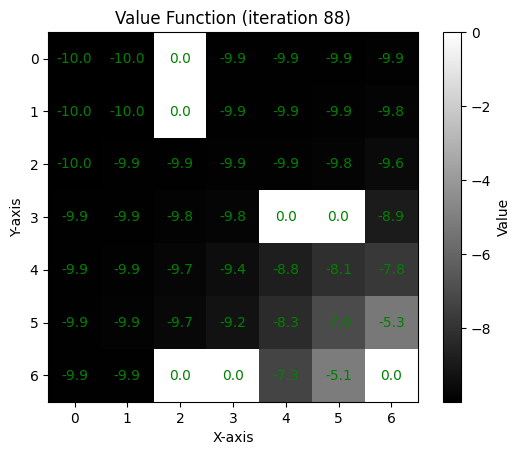

action = 0 V[0, 0] = -1 + 0.9 * -9.980094442202848 = -9.982084997982563
action = 1 V[0, 0] = -1 + 0.9 * -9.972369424971458 = -9.975132482474312
action = 2 V[0, 0] = -1 + 0.9 * -9.980094442202848 = -9.982084997982563
action = 3 V[0, 0] = -1 + 0.9 * -9.978975340557161 = -9.981077806501446
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978975340557161 = -9.981077806501446
action = 1 V[0, 1] = -1 + 0.9 * -9.968513866629692 = -9.971662479966723
action = 2 V[0, 1] = -1 + 0.9 * -9.980094442202848 = -9.982084997982563
action = 3 V[0, 1] = -1 + 0.9 * -9.978975340557161 = -9.981077806501446
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.939111483446382 = -9.945200335101744
action = 1 V[0, 3] = -1 + 0.9 * -9.92148935593419 = -9.929340420340772
action = 2 V[0, 3] = -1 + 0.9 * -9.939111483446382 = -9.945200335101744
action = 3 V[0, 3] = -1 + 0.9 * -9.929673663556944 = -9.93670629720125
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929673663556944 = -9.93670629720125
action = 1 V[0, 4] 

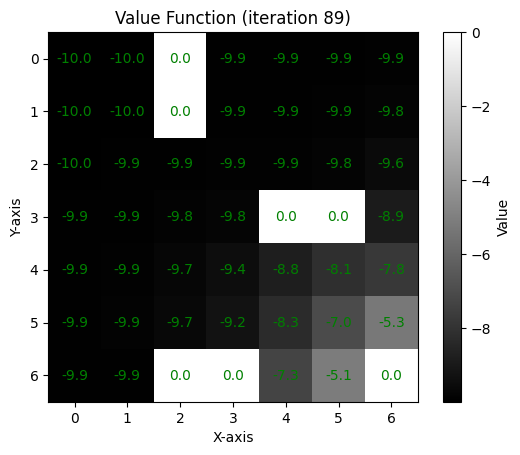

action = 0 V[0, 0] = -1 + 0.9 * -9.98009507123522 = -9.9820855641117
action = 1 V[0, 0] = -1 + 0.9 * -9.972369941863368 = -9.975132947677032
action = 2 V[0, 0] = -1 + 0.9 * -9.98009507123522 = -9.9820855641117
action = 3 V[0, 0] = -1 + 0.9 * -9.978975914270329 = -9.981078322843297
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978975914270329 = -9.981078322843297
action = 1 V[0, 1] = -1 + 0.9 * -9.968514332833168 = -9.971662899549852
action = 2 V[0, 1] = -1 + 0.9 * -9.98009507123522 = -9.9820855641117
action = 3 V[0, 1] = -1 + 0.9 * -9.978975914270329 = -9.981078322843297
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.939111846936378 = -9.94520066224274
action = 1 V[0, 3] = -1 + 0.9 * -9.92148966451116 = -9.929340698060045
action = 2 V[0, 3] = -1 + 0.9 * -9.939111846936378 = -9.94520066224274
action = 3 V[0, 3] = -1 + 0.9 * -9.929673983296802 = -9.936706584967121
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929673983296802 = -9.936706584967121
action = 1 V[0, 4] = -1 + 0.

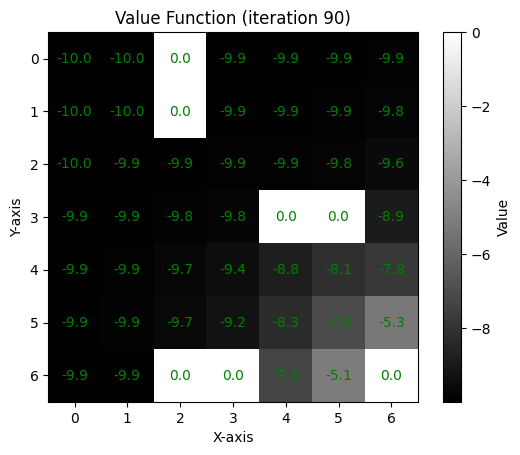

action = 0 V[0, 0] = -1 + 0.9 * -9.980095599685932 = -9.98208603971734
action = 1 V[0, 0] = -1 + 0.9 * -9.97237037606596 = -9.975133338459365
action = 2 V[0, 0] = -1 + 0.9 * -9.980095599685932 = -9.98208603971734
action = 3 V[0, 0] = -1 + 0.9 * -9.978976396238446 = -9.981078756614602
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978976396238446 = -9.981078756614602
action = 1 V[0, 1] = -1 + 0.9 * -9.968514724444216 = -9.971663251999795
action = 2 V[0, 1] = -1 + 0.9 * -9.980095599685932 = -9.98208603971734
action = 3 V[0, 1] = -1 + 0.9 * -9.978976396238446 = -9.981078756614602
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.939112151878161 = -9.945200936690345
action = 1 V[0, 3] = -1 + 0.9 * -9.921489923415244 = -9.92934093107372
action = 2 V[0, 3] = -1 + 0.9 * -9.939112151878161 = -9.945200936690345
action = 3 V[0, 3] = -1 + 0.9 * -9.929674251524471 = -9.936706826372024
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929674251524471 = -9.936706826372024
action = 1 V[0, 4] = 

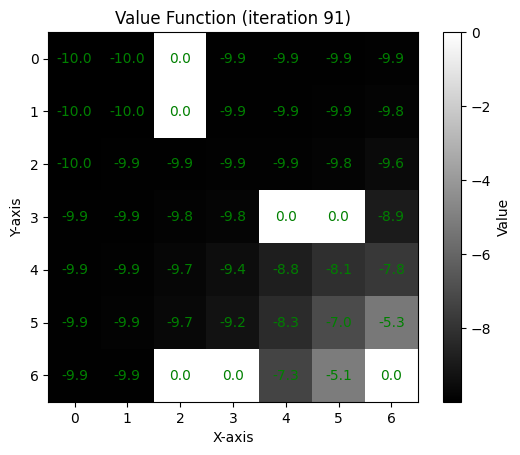

action = 0 V[0, 0] = -1 + 0.9 * -9.98009604362716 = -9.982086439264444
action = 1 V[0, 0] = -1 + 0.9 * -9.972370740799862 = -9.975133666719875
action = 2 V[0, 0] = -1 + 0.9 * -9.98009604362716 = -9.982086439264444
action = 3 V[0, 0] = -1 + 0.9 * -9.97897680112336 = -9.981079121011025
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.97897680112336 = -9.981079121011025
action = 1 V[0, 1] = -1 + 0.9 * -9.96851505339115 = -9.971663548052035
action = 2 V[0, 1] = -1 + 0.9 * -9.98009604362716 = -9.982086439264444
action = 3 V[0, 1] = -1 + 0.9 * -9.97897680112336 = -9.981079121011025
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.93911240770661 = -9.945201166935949
action = 1 V[0, 3] = -1 + 0.9 * -9.921490140645599 = -9.92934112658104
action = 2 V[0, 3] = -1 + 0.9 * -9.93911240770661 = -9.945201166935949
action = 3 V[0, 3] = -1 + 0.9 * -9.929674476542985 = -9.936707028888687
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929674476542985 = -9.936707028888687
action = 1 V[0, 4] = -1 + 

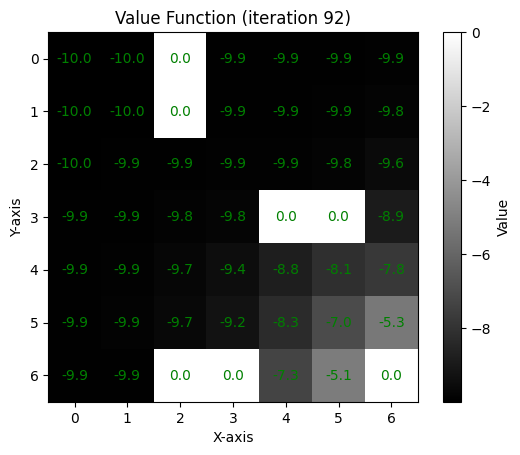

action = 0 V[0, 0] = -1 + 0.9 * -9.980096416564948 = -9.982086774908453
action = 1 V[0, 0] = -1 + 0.9 * -9.972371047173395 = -9.975133942456056
action = 2 V[0, 0] = -1 + 0.9 * -9.980096416564948 = -9.982086774908453
action = 3 V[0, 0] = -1 + 0.9 * -9.978977141245634 = -9.98107942712107
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978977141245634 = -9.98107942712107
action = 1 V[0, 1] = -1 + 0.9 * -9.968515329696029 = -9.971663796726427
action = 2 V[0, 1] = -1 + 0.9 * -9.980096416564948 = -9.982086774908453
action = 3 V[0, 1] = -1 + 0.9 * -9.978977141245634 = -9.98107942712107
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.939112622335406 = -9.945201360101866
action = 1 V[0, 3] = -1 + 0.9 * -9.921490322912664 = -9.929341290621398
action = 2 V[0, 3] = -1 + 0.9 * -9.939112622335406 = -9.945201360101866
action = 3 V[0, 3] = -1 + 0.9 * -9.929674665316313 = -9.936707198784681
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929674665316313 = -9.936707198784681
action = 1 V[0, 4] 

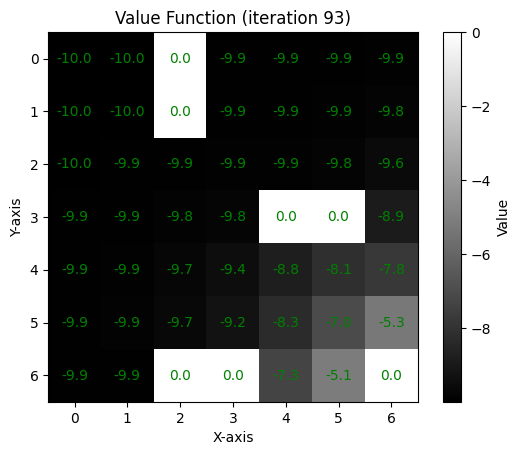

action = 0 V[0, 0] = -1 + 0.9 * -9.980096729848508 = -9.982087056863659
action = 1 V[0, 0] = -1 + 0.9 * -9.972371304519775 = -9.975134174067799
action = 2 V[0, 0] = -1 + 0.9 * -9.980096729848508 = -9.982087056863659
action = 3 V[0, 0] = -1 + 0.9 * -9.978977426958057 = -9.981079684262252
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978977426958057 = -9.981079684262252
action = 1 V[0, 1] = -1 + 0.9 * -9.968515561779055 = -9.97166400560115
action = 2 V[0, 1] = -1 + 0.9 * -9.980096729848508 = -9.982087056863659
action = 3 V[0, 1] = -1 + 0.9 * -9.978977426958057 = -9.981079684262252
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.939112802402452 = -9.945201522162208
action = 1 V[0, 3] = -1 + 0.9 * -9.921490475845877 = -9.929341428261289
action = 2 V[0, 3] = -1 + 0.9 * -9.939112802402452 = -9.945201522162208
action = 3 V[0, 3] = -1 + 0.9 * -9.929674823685442 = -9.936707341316898
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929674823685442 = -9.936707341316898
action = 1 V[0, 4

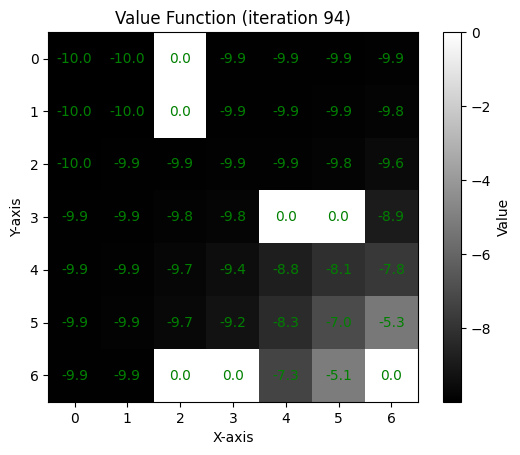

action = 0 V[0, 0] = -1 + 0.9 * -9.980096993014342 = -9.982087293712908
action = 1 V[0, 0] = -1 + 0.9 * -9.972371520680557 = -9.975134368612501
action = 2 V[0, 0] = -1 + 0.9 * -9.980096993014342 = -9.982087293712908
action = 3 V[0, 0] = -1 + 0.9 * -9.97897766695964 = -9.981079900263676
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.97897766695964 = -9.981079900263676
action = 1 V[0, 1] = -1 + 0.9 * -9.968515756714408 = -9.971664181042968
action = 2 V[0, 1] = -1 + 0.9 * -9.980096993014342 = -9.982087293712908
action = 3 V[0, 1] = -1 + 0.9 * -9.97897766695964 = -9.981079900263676
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.93911295347565 = -9.945201658128086
action = 1 V[0, 3] = -1 + 0.9 * -9.921490604167907 = -9.929341543751116
action = 2 V[0, 3] = -1 + 0.9 * -9.93911295347565 = -9.945201658128086
action = 3 V[0, 3] = -1 + 0.9 * -9.929674956549583 = -9.936707460894626
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929674956549583 = -9.936707460894626
action = 1 V[0, 4] = 

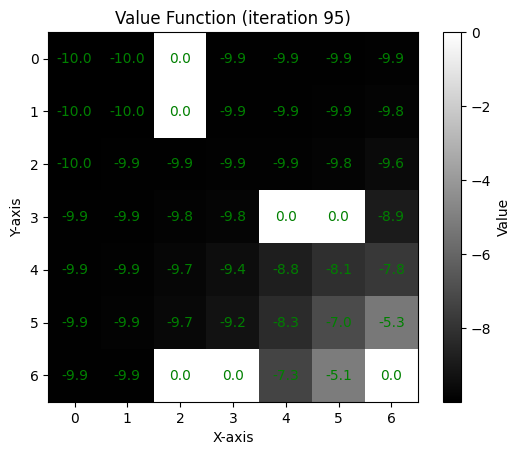

action = 0 V[0, 0] = -1 + 0.9 * -9.9800972140755 = -9.982087492667949
action = 1 V[0, 0] = -1 + 0.9 * -9.972371702243855 = -9.975134532019469
action = 2 V[0, 0] = -1 + 0.9 * -9.9800972140755 = -9.982087492667949
action = 3 V[0, 0] = -1 + 0.9 * -9.978977868559568 = -9.981080081703611
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978977868559568 = -9.981080081703611
action = 1 V[0, 1] = -1 + 0.9 * -9.968515920445263 = -9.971664328400736
action = 2 V[0, 1] = -1 + 0.9 * -9.9800972140755 = -9.982087492667949
action = 3 V[0, 1] = -1 + 0.9 * -9.978977868559568 = -9.981080081703611
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.939113080225479 = -9.945201772202932
action = 1 V[0, 3] = -1 + 0.9 * -9.921490711840775 = -9.929341640656698
action = 2 V[0, 3] = -1 + 0.9 * -9.939113080225479 = -9.945201772202932
action = 3 V[0, 3] = -1 + 0.9 * -9.929675068018103 = -9.936707561216293
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929675068018103 = -9.936707561216293
action = 1 V[0, 4] = -

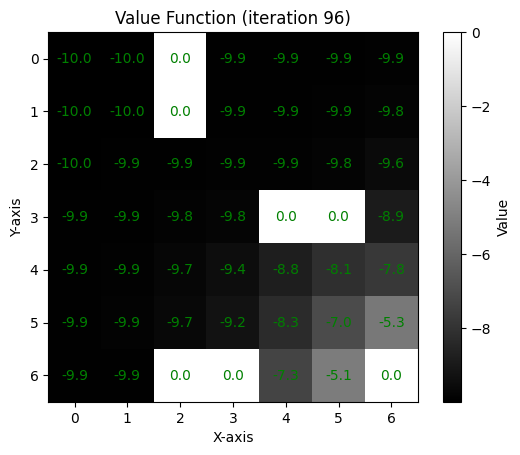

action = 0 V[0, 0] = -1 + 0.9 * -9.980097399764745 = -9.98208765978827
action = 1 V[0, 0] = -1 + 0.9 * -9.972371854744544 = -9.97513466927009
action = 2 V[0, 0] = -1 + 0.9 * -9.980097399764745 = -9.98208765978827
action = 3 V[0, 0] = -1 + 0.9 * -9.978978037899058 = -9.981080234109152
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978978037899058 = -9.981080234109152
action = 1 V[0, 1] = -1 + 0.9 * -9.968516057964484 = -9.971664452168035
action = 2 V[0, 1] = -1 + 0.9 * -9.980097399764745 = -9.98208765978827
action = 3 V[0, 1] = -1 + 0.9 * -9.978978037899058 = -9.981080234109152
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.939113186569713 = -9.945201867912742
action = 1 V[0, 3] = -1 + 0.9 * -9.921490802188428 = -9.929341721969585
action = 2 V[0, 3] = -1 + 0.9 * -9.939113186569713 = -9.945201867912742
action = 3 V[0, 3] = -1 + 0.9 * -9.929675161537926 = -9.936707645384134
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929675161537926 = -9.936707645384134
action = 1 V[0, 4] =

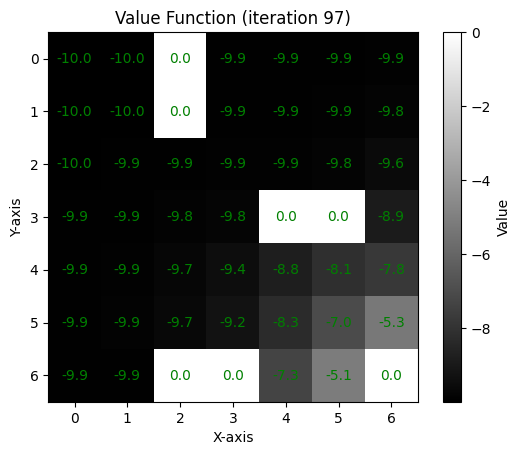

action = 0 V[0, 0] = -1 + 0.9 * -9.980097555738945 = -9.98208780016505
action = 1 V[0, 0] = -1 + 0.9 * -9.972371982832541 = -9.975134784549288
action = 2 V[0, 0] = -1 + 0.9 * -9.980097555738945 = -9.98208780016505
action = 3 V[0, 0] = -1 + 0.9 * -9.978978180137847 = -9.981080362124063
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978978180137847 = -9.981080362124063
action = 1 V[0, 1] = -1 + 0.9 * -9.96851617346648 = -9.971664556119832
action = 2 V[0, 1] = -1 + 0.9 * -9.980097555738945 = -9.98208780016505
action = 3 V[0, 1] = -1 + 0.9 * -9.978978180137847 = -9.981080362124063
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.939113275794801 = -9.94520194821532
action = 1 V[0, 3] = -1 + 0.9 * -9.921490877999538 = -9.929341790199585
action = 2 V[0, 3] = -1 + 0.9 * -9.939113275794801 = -9.94520194821532
action = 3 V[0, 3] = -1 + 0.9 * -9.929675240000396 = -9.936707716000356
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929675240000396 = -9.936707716000356
action = 1 V[0, 4] = -

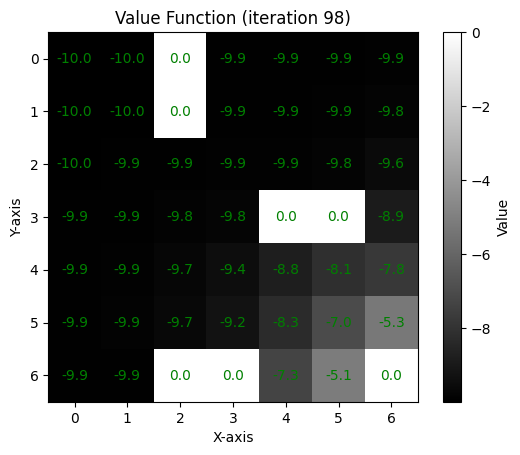

action = 0 V[0, 0] = -1 + 0.9 * -9.980097686750863 = -9.982087918075777
action = 1 V[0, 0] = -1 + 0.9 * -9.972372090414186 = -9.975134881372767
action = 2 V[0, 0] = -1 + 0.9 * -9.980097686750863 = -9.982087918075777
action = 3 V[0, 0] = -1 + 0.9 * -9.978978299610933 = -9.98108046964984
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978978299610933 = -9.98108046964984
action = 1 V[0, 1] = -1 + 0.9 * -9.96851627047481 = -9.97166464342733
action = 2 V[0, 1] = -1 + 0.9 * -9.980097686750863 = -9.982087918075777
action = 3 V[0, 1] = -1 + 0.9 * -9.978978299610933 = -9.98108046964984
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.939113350657646 = -9.945202015591882
action = 1 V[0, 3] = -1 + 0.9 * -9.92149094161374 = -9.929341847452367
action = 2 V[0, 3] = -1 + 0.9 * -9.939113350657646 = -9.945202015591882
action = 3 V[0, 3] = -1 + 0.9 * -9.929675305830868 = -9.93670777524778
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929675305830868 = -9.93670777524778
action = 1 V[0, 4] = -1 

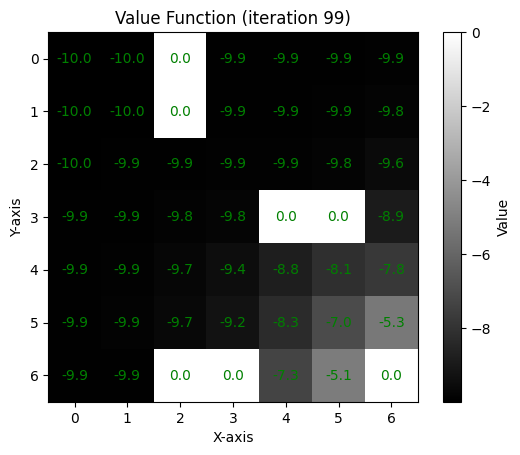

action = 0 V[0, 0] = -1 + 0.9 * -9.98009779679354 = -9.982088017114187
action = 1 V[0, 0] = -1 + 0.9 * -9.97237218077108 = -9.975134962693971
action = 2 V[0, 0] = -1 + 0.9 * -9.98009779679354 = -9.982088017114187
action = 3 V[0, 0] = -1 + 0.9 * -9.9789783999603 = -9.98108055996427
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.9789783999603 = -9.98108055996427
action = 1 V[0, 1] = -1 + 0.9 * -9.968516351949416 = -9.971664716754475
action = 2 V[0, 1] = -1 + 0.9 * -9.98009779679354 = -9.982088017114187
action = 3 V[0, 1] = -1 + 0.9 * -9.9789783999603 = -9.98108055996427
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.939113413470977 = -9.94520207212388
action = 1 V[0, 3] = -1 + 0.9 * -9.921490994993972 = -9.929341895494575
action = 2 V[0, 3] = -1 + 0.9 * -9.939113413470977 = -9.94520207212388
action = 3 V[0, 3] = -1 + 0.9 * -9.929675361063852 = -9.936707824957468
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929675361063852 = -9.936707824957468
action = 1 V[0, 4] = -1 + 0.9 *

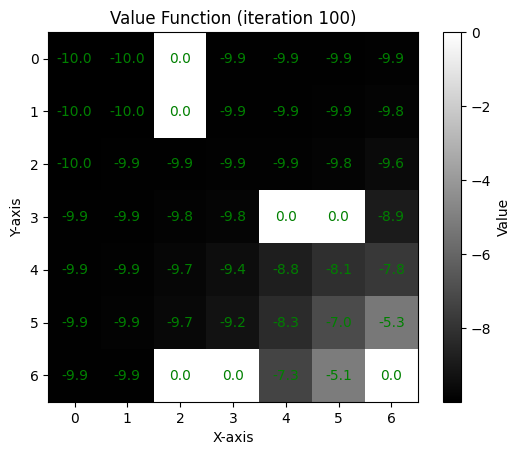

action = 0 V[0, 0] = -1 + 0.9 * -9.980097889221653 = -9.982088100299489
action = 1 V[0, 0] = -1 + 0.9 * -9.97237225665994 = -9.975135030993945
action = 2 V[0, 0] = -1 + 0.9 * -9.980097889221653 = -9.982088100299489
action = 3 V[0, 0] = -1 + 0.9 * -9.978978484245626 = -9.981080635821064
best_action = 1
action = 0 V[0, 1] = -1 + 0.9 * -9.978978484245626 = -9.981080635821064
action = 1 V[0, 1] = -1 + 0.9 * -9.968516420376721 = -9.971664778339049
action = 2 V[0, 1] = -1 + 0.9 * -9.980097889221653 = -9.982088100299489
action = 3 V[0, 1] = -1 + 0.9 * -9.978978484245626 = -9.981080635821064
best_action = 1
action = 0 V[0, 3] = -1 + 0.9 * -9.939113466174952 = -9.945202119557457
action = 1 V[0, 3] = -1 + 0.9 * -9.921491039787146 = -9.92934193580843
action = 2 V[0, 3] = -1 + 0.9 * -9.939113466174952 = -9.945202119557457
action = 3 V[0, 3] = -1 + 0.9 * -9.929675407406028 = -9.936707866665426
best_action = 1
action = 0 V[0, 4] = -1 + 0.9 * -9.929675407406028 = -9.936707866665426
action = 1 V[0, 4]

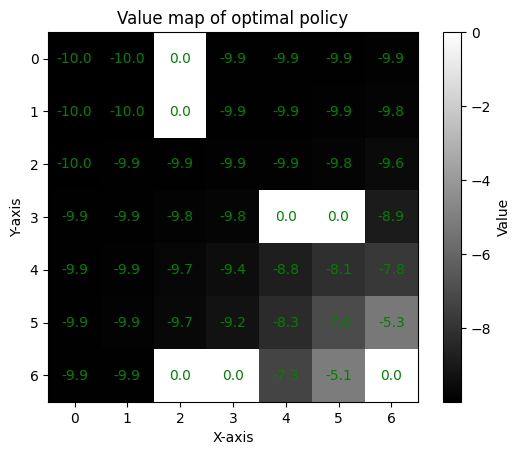

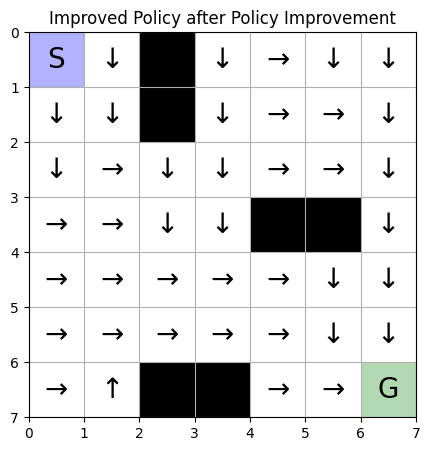

In [23]:
# Policy initialization
random_policy = policy_generator(grid, israndom=True) # random policy 생성
visualize_policy(random_policy, start, end, "Random Policy initialization", True) # random policy 시각화

# Policy iteration 
optimal_policy, optimal_value = policy_iteration() # policy iteration을 통해 optimal policy와 optimal value를 구함
visualize_map(optimal_value, "Value map of optimal policy") # optimal policy의 value map을 시각화
visualize_policy(optimal_policy, start, end, "Improved Policy after Policy Improvement", True) # policy 시각화

# Show value iteration results
### - Given

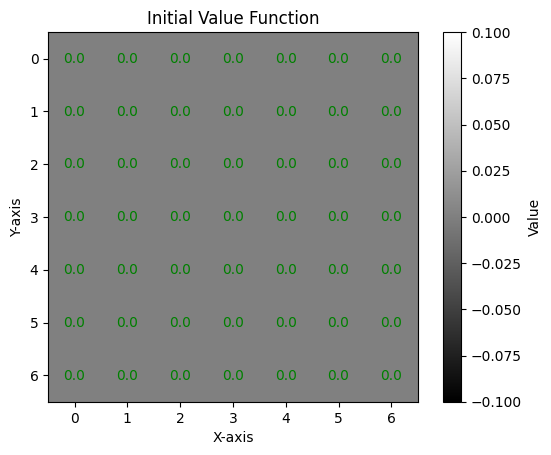

iteration 1


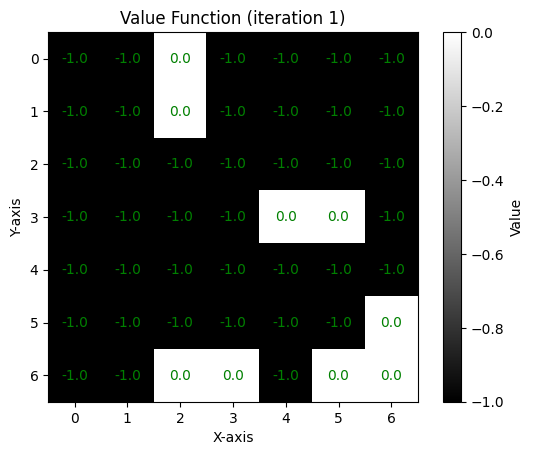

iteration 2


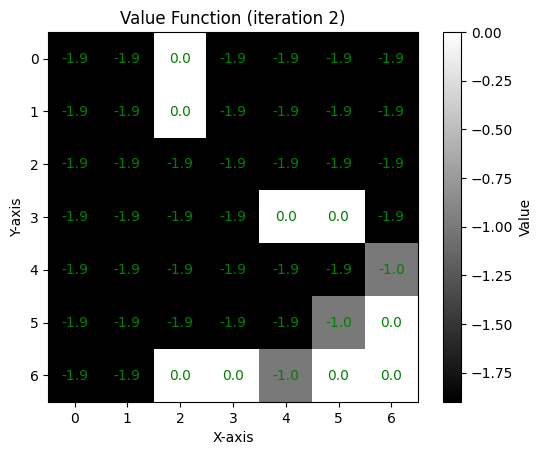

iteration 3


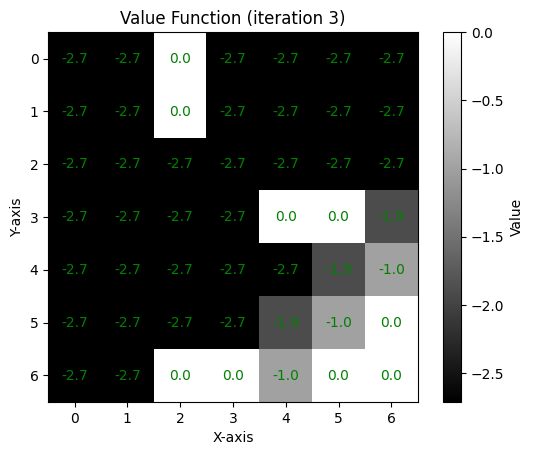

iteration 4


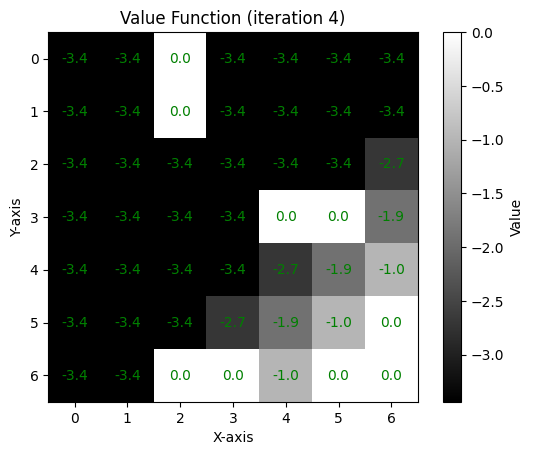

iteration 5


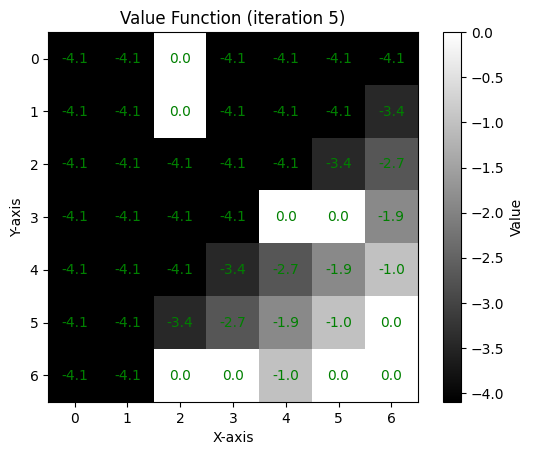

iteration 6


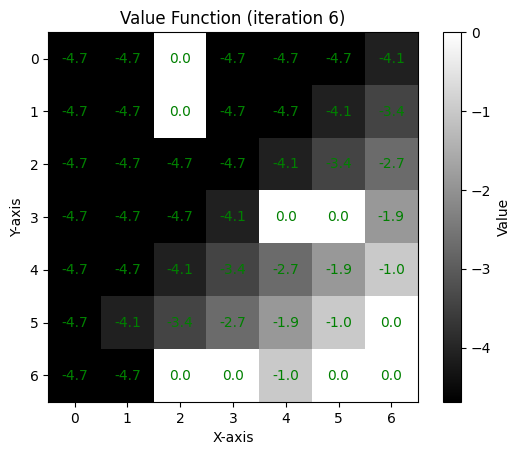

iteration 7


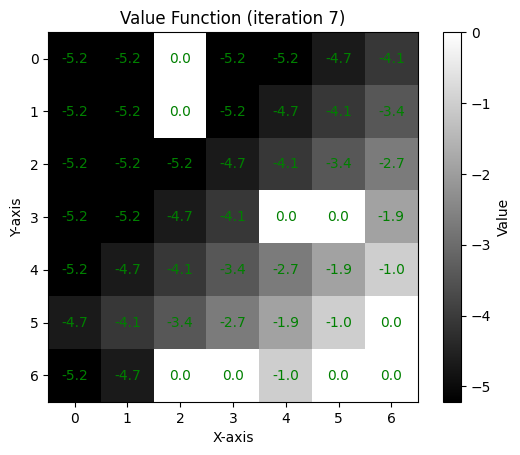

iteration 8


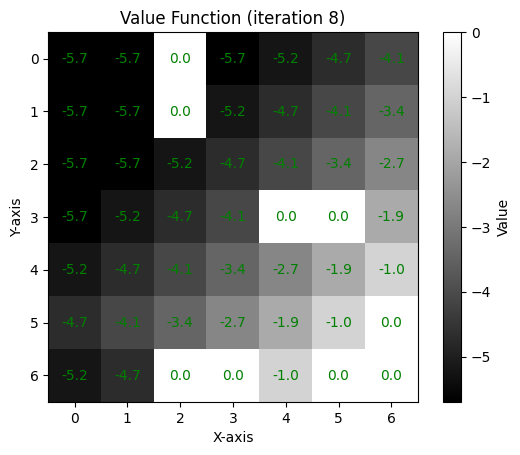

iteration 9


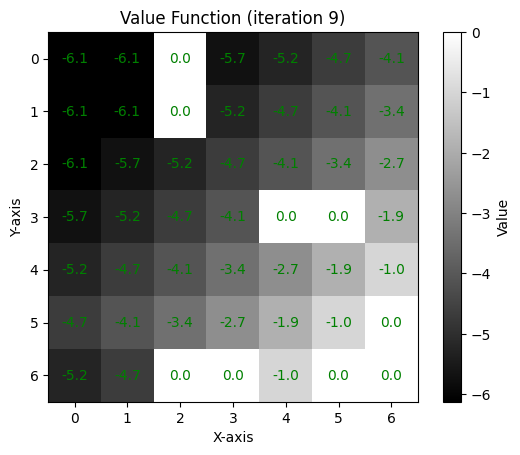

iteration 10


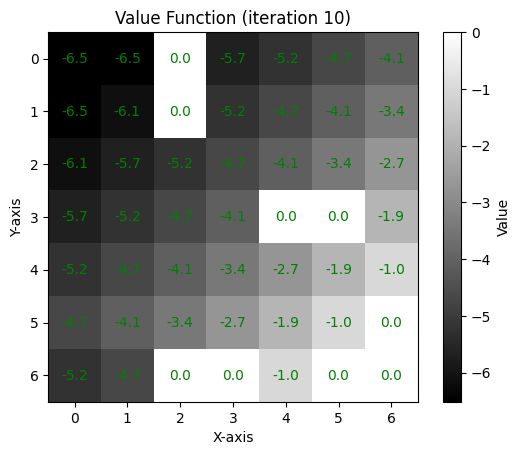

iteration 11


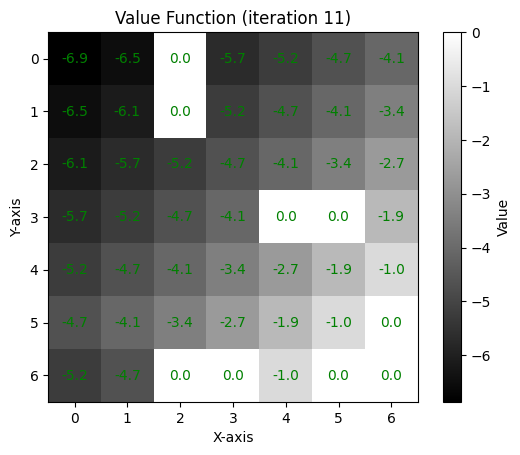

iteration 12


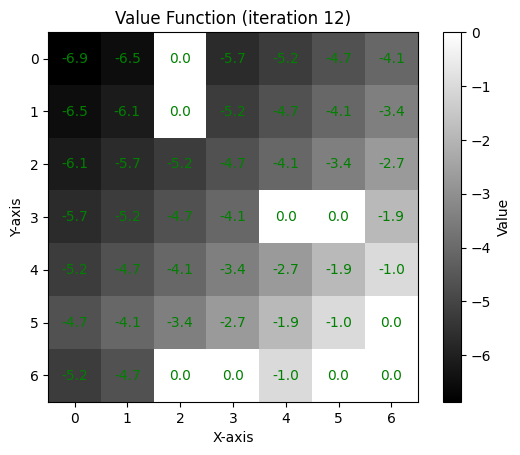

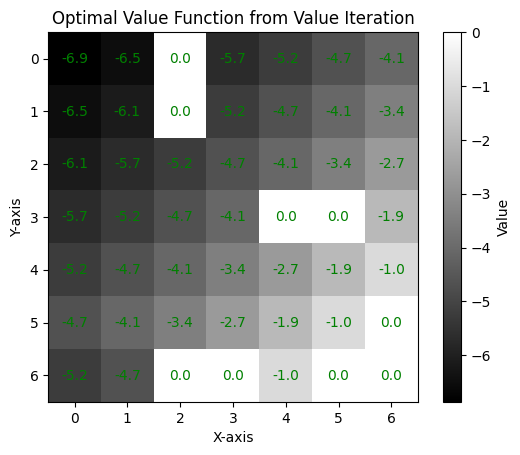

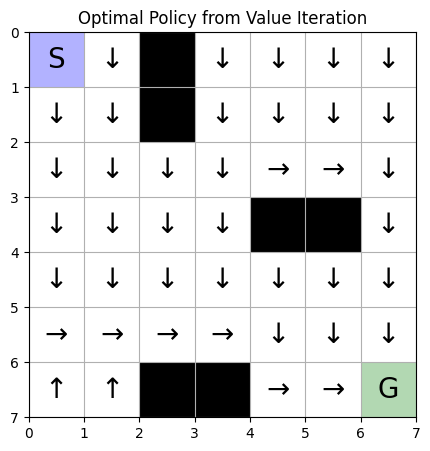

In [24]:
V_opt, optimal_policy = value_iteration(grid) # value iteration을 통해 optimal value와 optimal policy를 구함
visualize_map(V_opt, "Optimal Value Function from Value Iteration") # optimal value를 시각화
visualize_policy(optimal_policy, start, end, "Optimal Policy from Value Iteration", True) # optimal policy를 시각화